In [867]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd

## Import data

In [518]:
# load data

x = rasterio.open('../Gao_code/raster/dTRI.tif')
xMatrix = x.read(1)
xMatrix = xMatrix.T
y = rasterio.open('../Gao_code/raster/Cu.tif')
yMatrix = y.read(1)
yMatrix = yMatrix.T

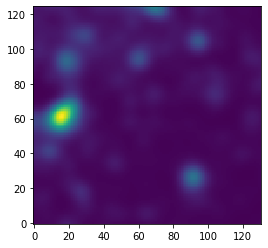

In [19]:
plt.imshow(xMatrix, origin='lower', interpolation='none')

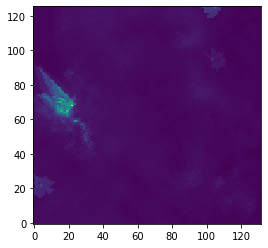

In [20]:
plt.imshow(yMatrix, origin='lower', interpolation='none')

In [26]:
#set parameters

# library sizes
#lib_sizes = np.arange(10,120,20)
lib_sizes = np.arange(10,120,50)

# the dimensions of the embedding   
E = 3                           

array([ 10,  60, 110])

In [519]:
xMatrix.shape

(125, 131)

In [520]:
yMatrix.shape

(126, 132)

## Embedding

In [607]:
from numpy.lib.stride_tricks import sliding_window_view

def expand_matrix(dataMatrix, lagNum):
    # Pad matrix with NA values (numpy.nan)
    return np.pad(dataMatrix, pad_width=lagNum, mode='constant', constant_values=np.nan)

def get_lag_indices(window_dim):
    # used to assign indices to variables of each lag order
    if window_dim % 2 == 0:
        raise ValueError("window_dim must be odd")

    # Create a coordinate grid
    center = window_dim // 2
    y, x = np.ogrid[:window_dim, :window_dim]

    # Calculate the Manhattan distance from the center
    dist = np.maximum(np.abs(y - center), np.abs(x - center))

    return dist.flatten()

def get_lagged_variables(dataMatrix, E):
    # sliding window to get lagged variables for each focal unit
    totalRow, totalCol = xMatrix.shape

    # extracting window of size maxlag around focul unit
    window_dim = E*2 + 1 # window dimension around focal unit
    window = (window_dim,window_dim) # window around focal unit
    
    # pad matrix with nans
    dataMatrix = expand_matrix(dataMatrix, E) 

    # arrays of neighbors for each unit
    laggedVar = sliding_window_view(dataMatrix, window) # gets window around each unit
    laggedVar = laggedVar.reshape(totalRow*totalCol,window_dim*window_dim) # reshape to flatten array

    # layered window indicating position of lag orders (0 focal unit,1, 2,...)
    lag_indices = get_lag_indices(window_dim)
    return laggedVar, lag_indices

def embedding(dataMatrix, E):
    # get neighbors of each unit and position indices of lag orders
    laggedVar, lag_indices = get_lagged_variables(dataMatrix, E) 
    
    # add focal units s
    embedding = [dataMatrix.T]  # TODO instead flatten the original dataMatrix (that is row-major)

    # s(1), s(2), ..., s(E)
    for i in range(1, E + 1):
        lag = laggedVar[:,np.where(lag_indices==i)] # extract neighbors of different order
        embedding.append(lag.squeeze())
        # [0] col x row focal
        # [1] col*row x 8 1st order
        # [2] col*row x 16 2nd order, ...
    return embedding

In [219]:
lag2 = get_lag_indices(5).flatten()
lag2

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2])

In [220]:
np.where(lag2==1)

(array([ 6,  7,  8, 11, 13, 16, 17, 18]),)

In [599]:
xEmbedings = embedding(xMatrix, 3)
print(len(xEmbedings))
xEmbedings[3].shape

4


(16375, 24)

In [448]:
def indices_array(m,n):
    r0 = np.arange(m) # Or r0,r1 = np.ogrid[:m,:n], out[:,:,0] = r0
    r1 = np.arange(n)
    out = np.empty((m,n,2),dtype=int)
    out[:,:,0] = r0[:,None]
    out[:,:,1] = r1
    return out

In [699]:
'''timeseries = np.arange(0,100,1)
lagsize = 1
numlags = 3 #dimension of manifold
Mx = np.zeros((len(timeseries)-(numlags-1)*lagsize,numlags))
for t in range(0,len(timeseries)-(numlags-1)*lagsize):
    inds = np.arange(t+(numlags-1)*lagsize,t-1,-lagsize)
    
    Mx[t,:] = timeseries[inds]'''

## Prediction 2

In [859]:
from itertools import product

def compute_stats(obs, pred):
    """
    Computes performance metrics for how well predictions match observations.
    
    Parameters:
    obs (array-like): Vector of observations
    pred (array-like): Vector of predictions
    
    Returns:
    DataFrame: A data frame containing N, rho, mae, and rmse
    """
    # Ensure obs and pred are numpy arrays
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    
    # Mask for finite values
    mask = np.isfinite(obs) & np.isfinite(pred)
    
    # Calculate N
    N = np.sum(mask)
    
    # Calculate rho (correlation coefficient)
    if N > 1:
        rho = np.corrcoef(obs[mask], pred[mask])[0, 1]
    else:
        rho = np.nan
    
    # Calculate mae (mean absolute error)
    mae = np.mean(np.abs(obs[mask] - pred[mask]))
    
    # Calculate rmse (root mean square error)
    rmse = np.sqrt(np.mean((obs[mask] - pred[mask]) ** 2))
    
    # Create a DataFrame to return the results
    result = {
        'N': N,
        'rho': rho,
        'mae': mae,
        'rmse': rmse}
    print(rho, result)
    return result

def projection(embeddings, target, lib_indices, lib_size, pred_indices, E):
    pred = np.full_like(target, np.nan).flatten()

    for p in np.where(pred_indices)[0]:
        # removes the prediction point from the library to ensure the model does not use its own value in prediction
        lib_indices_ = lib_indices.copy()
        lib_indices_[p] = False

        libs = np.where(lib_indices_)[0] # get indices

        # compute distances between the embedding of the prediction point and embeddings of all points in the adjusted library.
        distances = get_distances(embeddings, lib_size, E, p, libs)
        
        # find nearest neighbors
        neighbors = np.argsort(distances, kind='stable')[:E+1]
        min_distance = distances[neighbors[0]]
        
        if np.isnan(min_distance):
            continue
        elif min_distance == 0: # perfect match
            weights = np.full((E+1), 0.000001)
            weights = np.where(distances[neighbors] == 0, 1, weights)
        else:
            weights = np.exp(-distances[neighbors] / min_distance)
            weights = np.where(weights <0.000001, 0.000001, weights)
            
        total_weight = np.sum(weights)

        # make prediction
        # weighted average of the target values at the neighbor locations, using the calculated weights
        row, col = convert_column_major_idx(yPred, libs[neighbors])
        pred[p] = np.dot(weights, target[row, col]) / total_weight

        row, col = convert_column_major_idx(target, np.where(pred_indices)[0])
        

    return pred, compute_stats(target[row, col], pred[np.where(pred_indices)[0]])

In [682]:
def convert_column_major_idx(emb, i):
    num_rows = emb.shape[0]
    # Calculate the row and column in column-major order
    row = i % num_rows
    col = i // num_rows

    return (row, col)

In [930]:
def get_distances(xEmbedings, lib_size, E, p, libs):
    distances = np.full((libs.shape[0], E+1), np.inf)
    for e in range(len(xEmbedings)):
        emb = xEmbedings[e]
    
        num_rows = emb.shape[0]
        # Calculate the row and column in column-major order
        row, col = convert_column_major_idx(emb, p)
        row_lib, col_lib = convert_column_major_idx(emb, libs)
        distances[:,e] = abs(emb[row_lib, col_lib] - emb[row, col])
    return np.nanmean(distances, axis=1) #take row mean over all lag orders

In [730]:
def GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E):
    x_xmap_y = pd.DataFrame(columns=['L', 'rho'])
    pred_flat = [np.ravel_multi_index(pred[i], (totalRow,totalCol)) for i in range(pred.shape[0])]

    # sliding library window
    for r, c in product(range(totalRow - lib_size + 1), range(totalCol - lib_size + 1)):
        # initialize flatten mask arrays
        pred_indices = np.zeros(totalRow * totalCol, dtype=bool)
        lib_indices = np.zeros(totalRow * totalCol, dtype=bool)

        pred_indices[pred_flat] = True # mask which pixels in the total matrix should be predicted
        if np.isnan(yPred).any():
            pred_indices[np.isnan(yPred).flatten()] = False # ensure prediction indices do not correspond to NAN values in yPred

        # mask for pixels in current library
        lib_rows = np.arange(r, r + lib_size)
        lib_cols = np.arange(c, c + lib_size)
        lib_ids = np.array(list(product(lib_rows, lib_cols)))
        lib_ids_flat = [np.ravel_multi_index(lib_ids[i], (totalRow,totalCol)) for i in range(lib_ids.shape[0])]
        lib_indices[lib_ids_flat] = True

        # Skips to the next iteration if more than half of the values in the library indices are NA
        if sum(np.isnan(yPred.flatten()[np.where(lib_indices)])) <= (lib_size * lib_size) / 2:
            pred, stats = projection(xEmbedings, yPred, lib_indices, lib_size, pred_indices, E)
            x_xmap_y = pd.concat([x_xmap_y, pd.DataFrame([{'L': lib_size, 'rho': stats['rho']}])], ignore_index=True)
        else:
            print('skipped', r, c)

    return x_xmap_y

In [961]:
totalRow, totalCol = xMatrix.shape
E=3
lib_size=110
yPred = yMatrix.T
pred = indices_array(totalRow,totalCol)[4::5 , 4::5, ].reshape(-1,2) # filter every 5th pixel

In [962]:
pred

array([[  4,   4],
       [  4,   9],
       [  4,  14],
       ...,
       [124, 119],
       [124, 124],
       [124, 129]])

In [ ]:
x_xmap_y = GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E)

0.03348870344977444 {'N': 650, 'rho': 0.03348870344977444, 'mae': 9.774363, 'rmse': 22.1106}
0.04221828940928689 {'N': 650, 'rho': 0.04221828940928689, 'mae': 9.814374, 'rmse': 21.945766}
0.05072588068718219 {'N': 650, 'rho': 0.05072588068718219, 'mae': 9.765205, 'rmse': 21.869076}


/tmp/ipykernel_54766/2221422188.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  x_xmap_y = pd.concat([x_xmap_y, pd.DataFrame([{'L': lib_size, 'rho': stats['rho']}])], ignore_index=True)


0.04129821043384917 {'N': 650, 'rho': 0.04129821043384917, 'mae': 9.57993, 'rmse': 21.720001}
0.05135547021394755 {'N': 650, 'rho': 0.05135547021394755, 'mae': 8.856491, 'rmse': 21.284937}
0.04545676387373797 {'N': 650, 'rho': 0.04545676387373797, 'mae': 8.077042, 'rmse': 20.790886}
0.07923956270708482 {'N': 650, 'rho': 0.07923956270708482, 'mae': 7.85913, 'rmse': 20.446207}
0.09867412911267576 {'N': 650, 'rho': 0.09867412911267576, 'mae': 7.851954, 'rmse': 20.42431}
0.11470393279598677 {'N': 650, 'rho': 0.11470393279598677, 'mae': 7.8732495, 'rmse': 20.393938}
0.13412946797791822 {'N': 650, 'rho': 0.13412946797791822, 'mae': 7.9493117, 'rmse': 20.346254}
0.12374337470388944 {'N': 650, 'rho': 0.12374337470388944, 'mae': 7.966337, 'rmse': 20.35209}
0.10842572576429273 {'N': 650, 'rho': 0.10842572576429273, 'mae': 8.011153, 'rmse': 20.356356}
0.09368368580704708 {'N': 650, 'rho': 0.09368368580704708, 'mae': 7.9994426, 'rmse': 20.378456}
0.0779095324729182 {'N': 650, 'rho': 0.077909532472

In [871]:
x_xmap_y_r = np.array([ 0.0335072086784798, 0.042122429428938, 0.0503809342802391, 0.0413559292295293, 0.051351792110651, 0.0453481678043678, 0.0775749373275531, 0.0988185810668408, 0.114704206120007, 0.134129367482096, 0.124035767661485, 0.108726805119331, 0.0948122295999124, 0.0791369352847651, 0.0805364161502769, 0.0738093601410022, 0.047820586923697, 0.0399899306338175, 0.0199323943085819, 0.0220549476649518, 0.0316917727746058, 0.0578052925369255, 0.0550336402433913, 0.0640762193619302, 0.093586798329812, 0.0946792630796804, 0.092024767349218, 0.0923679950182536, 0.0942369777663774, 0.0760611120292369, 0.0776663712830493, 0.0707241387807552, 0.0308045567358214, 0.0512380936749106, 0.0712376976855058, 0.0712566421762985, 0.0838829292663966, 0.0833074015847476, 0.0744174123663451, 0.0760245427350935, 0.0704299324616396, 0.00665538241544452, 0.0405794417152979, 0.0448602855882088, 0.0677149416347923, -0.0249554074068355, -0.0819915920016086, -0.102278876595264, -0.106177555598802, -0.110674627545541, -0.135306847388612, -0.113247581936861, -0.0664420294214401, 0.0268381459948169, 0.0836107347164297, 0.106026429731804, 0.0958059394394632, 0.0860313570721571, 0.0949236992656144, 0.0776266690957912, -0.0476063219903214, -0.0103446323278705, 0.0453435459124878, 0.0773356462346398, 0.0822412889358152, 0.0798588348851918, 0.0794946975866298, 0.0586758473856779, 0.0162818084310156, -0.0233393933180208, -0.00235541508681174, -0.00051707607798877, 0.00771805215167119, 0.0208228801993595, -0.025230782417806, 0.00781028825222463, 0.0304327745832299, 0.0690611665006666, 0.0661990317864471, 0.0167955445152252, -0.00801292218414552, 0.00530990285778221, -0.0392390378018437, -0.0743883606118156, -0.0601794884139731, -0.0701087515998796, -0.0513289400843585, -0.0481363293088446, -0.0639993691697205, -0.0395759716755408, -0.0573287217201659, -0.0660228068210086, -0.0603237877374529, -0.0619995377672881, -0.0725337430092925, -0.0768265297732923, -0.072392647190982, -0.0686618768878762, -0.0618542726732908, -0.0629202020691417, -0.0493534852007337, -0.0252516263951977, -0.0413444359344949, -0.0538616327092055, -0.073709788094773, -0.0793387763592801, -0.0829566481516195, -0.084989394522051, -0.0968876848128301, -0.06083142409493, -0.0555841423497864, 0.0014480519301054, 0.0494419511059462, 0.0868348842592552, 0.0953041408677758, 0.0956518068800221, 0.068409890732301, 0.0447186422783819, 0.0391156815440779, 0.0207327295309966, 0.024831419185913, 0.0138589116456815, -0.0942285407919022, -0.0738866512533223, -0.0482593472500713, -0.0203820108574515, 0.0219833667627994, 0.0173263778361452, 0.0641645436155809, 0.104849386910348, 0.119465381312185, 0.112551112677527, 0.122976430870356, 0.118448832386966, 0.100558505133964, 0.0921004705932834, 0.102504468086691, 0.0966054516837426, 0.0944800764320929, 0.0912165459203945, 0.0981088858407212, 0.098213651978879, 0.0922468824799513, 0.0772270526434502, 0.0837489532130697, 0.0756831127859489, 0.0669550474891111, 0.0684970653010804, 0.0741260826799898, 0.0483520854881209, 0.0397961700482826, 0.035547410478249, 0.0414871741319581, 0.0403744740004344, -0.00631053493608003, -0.0264662619454103, -0.0118639392736877, 0.0489300845188643, 0.0658124962685158, 0.0798056549934284, 0.085919286543221, 0.0963768903500009, 0.100562630141595, 0.0476987755703499, 0.086817406422778, 0.0658978057019019, 0.0902045067402192, -0.0393224883450829, -0.118511890026631, -0.125460277839028, -0.115689728488915, -0.113762074765913, -0.135045295698627, -0.124703197756762, -0.116394885043751, 0.00372852213984564, 0.0547070181932637, 0.0709861470446492, 0.076271329490058, 0.05486641668188, 0.0731518192652491, 0.0527471896149387, -0.0546293178698258, -0.0524172046925737, -0.0288787829901363, 0.0427071290479545, 0.0534847528349603, 0.0646905898198389, 0.0734251673352377, 0.0590224866508721, 0.0141315300181042, -0.0152525346904327, -0.00283965157192187, 0.0143928119878221, 0.0454003389055544, 0.0434074654871642, 0.0109612417590286, 0.039956402484078, 0.0941428906677752, 0.103092980429993, 0.106225270801142, 0.120286275725912, 0.0269506003711294, 0.00667512064361236, -0.0474599293569402, -0.078693299973201, -0.0613366696438189, -0.0865816136607603, -0.0454199727279741, -0.0418473583143136, -0.0466759413347193, -0.0490294149343106, -0.0356412032486443, -0.052493059825536, -0.0686815213928814, -0.0653114026144891, -0.075549152158452, -0.083773872233544, -0.0813800646244145, -0.0687949558829592, -0.0438298872783278, -0.0889142268774777, -0.0845910860482282, -0.0724154298630575, -0.0776387326461822, -0.0792341240816371, -0.0913934616078231, -0.0950210502616355, -0.089340646383589, -0.0927055546576198, -0.0954480845600343, -0.0490316499112846, -0.020592282360012, 0.0731513081307529, 0.0358609201173227, 0.0910977747739708, 0.120421642894115, 0.150200391953401, 0.057877104184587, 0.0398996065595825, 0.0484714345788249, 0.0434716535781504, 0.0254266093690608, 0.0185637225230026, -0.0835540132090023, -0.115490053392716, -0.0858615333959192, -0.0833652780754971, -0.0223917847719943, 0.0032102360034119, 0.0483506670074879, 0.0878180299394157, 0.0743102385889516, 0.0589466167539572, 0.0609335426032642, 0.0918419493550234, 0.0796650268019518, 0.073627886644713, 0.0860516824528093, 0.0793240275734188, 0.080141953382898, 0.0833838138324131, 0.118840448667927, 0.130420603063695, 0.1289229995329, 0.100377927743207, 0.0944678787123865, 0.0866789221515685, 0.0767032535233434, 0.0373190408278351, 0.0495238163344557, 0.0104779014501421, 0.00799271026496814, 0.00533764294729645, 0.011005021793921, 0.0127496884080154, -0.0248250314698838, -0.0321050636180114, -0.0424372543872028, 0.010180655607223, 0.0807567941985938, 0.0933054162981393, 0.0804055189790414, 0.096400436653676, 0.0854427913553811, 0.0715063635369821, 0.0744824491138336, 0.0924389493076361, 0.0895369902183442, -0.0798257373602769, -0.115554752107503, -0.114169664716269, -0.118899516544548, -0.120650031324952, -0.145955213577814, -0.135795465308549, -0.114021355223261, -0.000524513038462947, 0.032440079562243, 0.0343224480916814, 0.0409642296666096, 0.032914389391951, 0.040065244438551, 0.0421824907776553, -0.0530757330206253, -0.0645093923307138, -0.036591877757472, 0.0352511197282842, 0.00317081900544833, 0.0511674552772905, 0.0817146553989356, 0.054255785057901, 0.00519909698727588, -0.0188571647931645, -0.00582393149261518, 0.0124693937673327, 0.0662656574469437, 0.0264481920998213, -0.0559039393253533, -0.00543291253046836, 0.0612194731212444, 0.101575832038407, 0.11669227986511, 0.130097459394353, 0.0374936036726898, 0.0242663309434686, -0.00395953786202291, -0.107135350418763, -0.103028280476007, -0.130115808507393, -0.0678837533970234, -0.0550250693522886, -0.0553848634493782, -0.0646191510238839, -0.0534531259066122, -0.04757482391942, -0.0605814087186316, -0.0520695869509635, -0.0770732248091902, -0.087122601221744, -0.0801940547270948, -0.071369518720023, -0.0595069091246892, -0.0530897350457381, -0.0632844096068107, -0.0838959950383607, -0.0885383705167262, -0.102283160034881, -0.120501572840814, -0.121346747983884, -0.10264149347214, -0.100304960468957, -0.096762931231992, -0.058249672100033, -0.0380771456333737, 0.0416006030401327, 0.0490455739329512, 0.0360522713297574, 0.0414646543792322, 0.0537815152608118, 0.0917590204754907, 0.0562976036758472, 0.0461157965544412, 0.0496461577951165, 0.0510606788510965, 0.00519757477577309, -0.0718808108765646, -0.0884186433979055, -0.0782414839780927, -0.0797314909969408, -0.0705228278024025, -0.0737522154269885, -0.0638995970851529, 0.0325113334145627, 0.0450822451024554, -0.00160414305605105, -0.0150397383059251, 0.021788368064408, 0.00957380553010088, 0.00620622356415694, 0.0192054982198638, 0.00299863235929133, 0.00498988653602721, 0.0410999014496943, 0.0765926137735981, 0.118853442752902, 0.126428483394536, 0.109978723945231, 0.0958118636711847, 0.0801640069136849, 0.0641473101711183, 0.0245745909889524, 0.0274399899650631, 0.01619847572155, 0.0315941196055042, 0.0478956447486758, 0.0471151790305321, 0.0525786965963218, 0.0205856319423227, 0.0263553917946017, 0.028181878337942, 0.0272480419347363, 0.0964991801370109, 0.11037153480254, 0.105402701320608, 0.122929817850328, 0.0943386827091909, 0.0712293211295823, 0.0614377812756095, 0.0556815945425972, 0.0254471082601306, -0.0615559989292124, -0.102207358420208, -0.0778558496328383, -0.0536428777312044, -0.0582417526038269, -0.100203541261858, -0.0940481787727882, -0.0572122129590172, 0.0570989818174615, 0.0787615489008566, 0.0856161118179272, 0.0880955012944029, 0.0795611094981179, 0.0818781089409979, 0.0900884965970326, 0.0559374342925888, 0.00807300834042592, -0.00843825398355771, 0.00638888346209071, 0.0159246075732315, 0.0380960817461785, 0.0618724471112266, 0.0694342244395348, -0.0194189177146957, -0.0303732896958128, -0.00721947461407811, 0.00579979793319871, 0.0741283084002823, 0.0226753485941438, -0.0386093109475506, -0.0464178660139662, 0.024714934014753, -0.00618049207835102, 0.0622628663661498, 0.103622634716839, 0.0501991556265376, 0.0763409684660607, 0.0344406851054268, -0.0580159945210354, -0.0990443115059589, -0.121819930113708, -0.0630434417557554, -0.0368693295482478, -0.0328751378294458, -0.0418618582483101, -0.0298178038562185, -0.0297004214218499, -0.0444326703089892, -0.0386010040938621, -0.0663429879089314, -0.098992608537445, -0.1052838682598, -0.103724151983864, -0.104687311035731, -0.113680599496474, -0.10366793785581, -0.0784338596441525, -0.0974857852357966, -0.103744310635553, -0.119932634455746, -0.129277378731885, -0.088772195814786, -0.106811826785772, -0.10341602612096, -0.0598210509782016, -0.0162804586312132, 0.0406630414506648, 0.0531327508639833, -0.0474918100633729, -0.0484803017808983, -0.0338700332386322, 0.0675788265165259, 0.0553943690159918, 0.0568543390901677, 0.0569474386459528, 0.0481377502879655, -0.036440659503925, -0.0829118242720759, -0.0916521465713175, -0.0910949408196209, -0.108091080395219, -0.0630283656894544, -0.0767238828403836, -0.0722727739184157, -0.0274638292014023, 0.000174824788944677, -0.0309313312869234, -0.0620967775343491, -0.0410608041203674, -0.0520458591856924, -0.0512214729412959, -0.0596550854197019, -0.0676050614293821, -0.0618362212003323, -0.0529174668399885, -0.0167655176094991, 0.0517965178272996, 0.104367396623692, 0.0800502571522075, 0.0712928390515432, 0.0514505258215308, 0.0269677240124938, 0.0269695603864334, -0.0250203229645947, -0.0687138217151994, -0.0821637041586129, -0.0638781582269586, -0.0286585913504811, -0.00311930709576171, -0.0741111190056126, -0.0614135985068284, -0.0399721495431199, -0.0646835727621228, 0.0705359713276989, 0.0836591477015885, 0.0830120247028535, 0.0992230424089205, 0.0849465662892606, 0.0689179307398751, -0.0112646750835552, -0.0589531194447296, -0.048399110653807, -0.0987773138994704, -0.106286527758016, -0.0660630068746077, -0.0334113574788939, -0.0364248078945277, -0.0878815459014282, -0.0798515438790829, -0.0402077361965821, 0.0713955124818926, 0.0913130055936291, 0.100881654350198, 0.102350577053759, 0.10154960275344, 0.102230101954503, 0.101769280561976, 0.0816152819599113, 0.055721046734666, 0.0347384002493859, 0.05112578792183, 0.027070080050549, 0.0313399427790257, 0.00667605214450878, 0.0322089128075467, -0.0121621062254056, -0.060321360724316, -0.0784621904621562, -0.0105316409571395, 0.025015861444398, -0.00306429774398244, -0.0662578468560663, -0.0674597608440214, 0.0025938869248562, -0.0774612710737828, 0.0447755559444816, 0.0608299392022918, 0.0585076975236839, 0.0472972191598947, 0.0218421301508426, -0.0332163503708364, -0.0909178116814934, -0.125296811013124, -0.0768700031328563, -0.0297321160788231, -0.0562302823305774, -0.0687539723369821, -0.0561991156198314, -0.0550928779501949, -0.0760064013389966, -0.0699451408650027, -0.0823028553472625, -0.0960683005904835, -0.102174755071746, -0.112566848090124, -0.114230022856294, -0.109800903857397, -0.10783701751749, -0.0845979104581085, -0.101583707469604, -0.119616416349894, -0.142278172735477, -0.148738952075798, -0.111040888676007, -0.0995201216090553, -0.100963159602615, -0.0222580274215803, 0.0234532792779695, 0.0387281406077735, -0.0732798421802348, -0.0669623564391229, -0.0798426338724214, -0.0644184520008244, 0.0423559571841023, 0.0584051071560377, 0.064043479219125, 0.0878749562165427, 0.0813378457838088, 0.0715555487537769, -0.0833548017997648, -0.0966889406462193, -0.103725974786513, -0.106612904743253, -0.0594858894201652, -0.0563216279485828, -0.0530210436625152, -0.0601698578089445, -0.0539909254105238, -0.0252843206439034, -0.0544120877017391, -0.0150492928799507, -0.0137807544788399, -0.0286653279938849, -0.054213526900602, -0.0652490652580173, -0.0706512547337292, -0.0610953360618256, -0.0202551681125969, 0.0266889933967663, 0.0780502217228836, 0.0545267511688159, 0.0449532618737724, 0.01828664485622, 0.0106214330581291, -0.0029025039636069, -0.0297366260814183, -0.0570887659235395, -0.0676531847391717, -0.0879739254278777, -0.0792046450852628, -0.0600271031486368, -0.100896634504477, -0.0852614394638513, -0.061879178017462, -0.0837689249642386, 0.0476160240627615, 0.0682150019937687, 0.071175091517348, 0.0877907049792655, 0.0848910744861014, 0.0895148844412481, 0.0234414669014975, -0.0693516812260205, -0.0365184667759458, -0.087417277892469, -0.123656614023453, -0.089460053246156, -0.0444883460709931, -0.0670237384376535, -0.0567082414205218, -0.0362052446498711, -0.00590548569038252, 0.0895451724360928, 0.111119396583332, 0.121161788089504, 0.123786413483234, 0.117832619187465, 0.119350308259115, 0.117516852234601, 0.0991842536508034, 0.104576261537951, 0.102944548645012, 0.0665846806159011, 0.049234170622649, -0.00483886955629694, -0.0440683625473164, -0.0800305497946286, -0.0375810660439446, -0.0437275503667758, -0.0969260203755668, -0.0862410221012567, -0.0161126135997488, -0.0364272023772037, -0.0751823111982048, -0.083073425448717, -0.0568158582114443, -0.0267972414558376, 0.00500360769202557, -0.0357589224200883, 0.00560729016452107, -0.0177605524869478, 0.00142104973206192, -0.0124012673105149, -0.0688402278590476, -0.117215104350488, -0.0958057196317258, -0.063227383089046, -0.0566520549242142, -0.080439550287154, -0.0726500107606432, -0.0589118631471657, -0.0780462973112456, -0.0674976550046873, -0.087155395524339, -0.102278693370299, -0.103512013930697, -0.12298000785036, -0.132282147775333, -0.147423722627449, -0.144369692716555, -0.0990564068424377, -0.110309157825588, -0.132647603543063, -0.133035830128347, -0.129651522526933, -0.11069294744676, -0.103951499562662, -0.109508561426694, -0.0206601939370572, 0.0127835039154858, -0.00878715627236931, -0.0628351012435739, -0.0441632136359963, -0.0461435375673497, -0.0262516989811123, 0.0565911564208388, 0.0720227011532592, 0.0849202519033185, 0.0943621976650414, 0.0881825868548132, 0.0803443347584398, -0.0921486722896854, -0.102027480553424, -0.114183944356171, -0.0928074056038612, -0.0468774922152808, -0.0595365451344798, -0.0720774011242827, -0.0899172541748367, -0.094726091376693, 0.0133413399151067, -0.0609346154081644, -0.0206442849024971, 0.00238268890439728, 0.0143829450175799, -0.0245689834218706, -0.061452130790757, -0.0637008628426719, -0.0476945115585111, -0.0136891515609699, 0.013356255290671, 0.068703335507196, 0.0498320543040918, 0.0383703108457251, 0.0368309994179811, -0.0284323628990308, -0.052909344368375, -0.0556173489200041, -0.0681446721484683, -0.0727413293516585, -0.094814014283886, -0.0773721257695489, -0.052118998417789, -0.0243827499706704, -0.0334711308833229, -0.00773171678579076, 0.00619313344739978, 0.0811143590487639, 0.0962761472133877, 0.0944939529392182, 0.0998247946291792, 0.100146772539577, 0.0667671951309668, -0.014709684759127, -0.0823001048353574, -0.0836996979761182, -0.12286342647838, -0.124172342237305, -0.118717502646922, -0.0520147990277561, -0.0596376311006897, -0.0501163483244308, -0.0346705294338505, -0.00630996745504015, 0.0890471222792675, 0.105171320355074, 0.114128107153071, 0.116471490740283, 0.113187251051513, 0.116079921725618, 0.113462091865972, 0.0972287270922631, 0.100583444170776, 0.10609382372879, 0.116718953215701, 0.108026503430938, 0.0966662753874912, 0.0324776358702186, -0.0813111758778966, -0.0983036594166835, -0.0574512132585313, -0.032395240855141, -0.0313219269331147, -0.00760477240864579, -0.00187687956456823, -0.0442535771949008, -0.0632733959844089, -0.0602428739336493, -0.0382560413436973, -0.0309118309494782, 0.011205739957518, 0.0018121747623004, -0.00551235110930828, 0.000429513383764945, -0.0100640945870889, -0.0227060468480652, -0.0359070889897454, -0.0548296030619133, -0.0424861457640152, -0.0799976897769048, -0.0901450625627707, -0.0763624706140984, -0.0534329077195488, -0.0611477857763573, -0.0536830206880093, -0.0641046556397896, -0.0676600593375415, -0.0859683223398992, -0.0831943693797447, -0.0711858097567157, -0.0467247987235315, -0.0324083545236662, -0.0346240011729758, -0.0574813733486752, -0.0709598858673029, -0.0772140589867932, -0.132051032447576, -0.128771210265469, -0.0975908790457895, -0.140430164724836, -0.0471751340833736, -0.00276229953067172, -0.0517121365345539, -0.0548727166948065, -0.0448533523685657, -0.0147679551063344, 0.0132146725655216, 0.0826991867205464, 0.0690548287156674, 0.0802465049223773, 0.0974228639137071, 0.0874562131058309, 0.0888960383127226, -0.0846252240849512, -0.0925130677256104, -0.107505746189424, -0.0705836743726485, -0.0543813892109768, -0.0624741848073007, -0.0837927112615227, -0.0919007005200779, -0.0957857496140253, -0.0183634480507216, -0.0482850185729354, 0.0227524592511453, -0.0654013619586038, -0.0024435051954596, -0.024782798970293, -0.0724886829655528, -0.0702867889514005, -0.0463940299780637, -0.0191982989708527, 0.0204046904251393, 0.0703495186447064, 0.0449095969437927, 0.0348230071184107, 0.0373576120800752, -0.0125213806956629, -0.0767076518762962, -0.0804855931254604, -0.0905698036095829, -0.085110632573755, -0.0715970641585463, -0.0772050708526181, -0.0402598878076731, -0.00180384685619145, -0.00791454317280848, -0.0127879318444141, 0.00793060212270776, 0.0819252398882117, 0.0922341071721891, 0.0887806673025978, 0.100461581560849, 0.0873634029369639, 0.0372389330912448, -0.0516170019725636, -0.0687444114080709, -0.0616639676331698, -0.0961190896315441, -0.105356054536558, -0.123184895807908, -0.104137678218133, -0.0742700693318268, -0.0611570351386342, -0.0356416923335796, 0.0390993596046625, 0.0956043180529803, 0.109174900612108, 0.115159259737351, 0.11607830698013, 0.111186806872327, 0.111794980355845, 0.110271798041007, 0.0941851217996367, 0.0989945550098165, 0.1018968931716, 0.098688093597313, 0.113908047137267, 0.113050463239628, 0.0963620726893539, 0.0290618196441627, -0.0524315947647577, -0.0506096280462854, -0.00559508161368953, 0.0475178495645606, 0.0572813063914823, 0.0474457630719057, -0.013459279886447, 0.000256952166474569, 0.0908997901367155, 0.0894426713782134, 0.0171746103402027, 0.0375205438801985, 0.0325686685132427, 0.0234001517647444, 0.0358126588314726, 0.00240917037032131, -0.0311993994664576, -0.0313144817082864, -0.0440712843662908, -0.0428252046683292, -0.0375892338569577, -0.0607537656294326, -0.0351685196021352, -0.014660837201282, -0.0090605224542548, -0.0185141364198313, -0.0366357402609911, -0.0271015394886959, -0.0352184280278896, -0.0454452318942811, -0.0351749437249805, 0.0348260287318333, -0.0291932722922028, -0.0356007525427117, -0.0609328318108782, -0.0478122544365385, 0.0440809317829973, -0.0759207680144034, -0.118619872823388, -0.0603921918157868, -0.122447752594472, -0.0297426306040872, 0.0082696181082159, -0.0566418028758095, -0.0680589755068792, -0.0534056990187091, -0.014156759155868, 0.0186799567413513, 0.0875365701129478, 0.073088221230138, 0.0848210617739907, 0.096897484187, 0.100062916882433, 0.0914631859385309, -0.0449682988347455, -0.0498134974453164, -0.0555078721434627, -0.0462146240396542, -0.0492214136058912, -0.0611633452068482, -0.0813844995318468, -0.0940498303248682, -0.0616962144146211, -0.0235832941588223, -0.0197652606664619, 0.00235423852778649, -0.0802866703484832, -0.0881192458467209, -0.0879943070785196, -0.103650537653019, -0.0781647742381561, -0.0544162009724601, -0.0515358961258471, 0.0128399158228946, 0.0646170623260232, 0.0360321298367453, 0.0273455990825981, 0.0302290618748617, -0.0089327956540021, -0.0727583203777931, -0.0604160031993054, -0.0725173659387213, -0.0963171538181658, -0.0783370577699243, -0.0825634313891054, -0.0387268528389067, -0.0433238527459719, -0.0266362650662472, -0.00809854955105475, 0.0214335664418533, 0.0864570856194944, 0.105505055984011, 0.094363761758526, 0.0953434440528588, 0.0770230392727514, -0.0278483062476742, -0.0675754511198682, -0.0949094861358544, -0.0995695677842961, -0.106240580039347, -0.115820391490682, -0.132815606319099, -0.114575924328067, -0.103268459874976, -0.0902930877985046, -0.0576056313267527, -0.0111317877564176, 0.0891920147652371, 0.104532017696763, 0.109507170654117, 0.112667491043012, 0.11159439778734, 0.114001205915311, 0.107541375314627, 0.0929365339688052, 0.0970022576390233, 0.107185421419116, 0.109399430043033, 0.117972897689277, 0.116795152517277, 0.116880044097374, 0.074465254424329, 0.0569479505072633, 0.123096339487377, 0.0874269279501815, 0.0441383150904475, 0.0360299020634811, -0.0294657180309725, -0.0309446617198383, -0.00153349885741595, 0.0755629790481517, 0.0447680123686878, 0.00261459834176894, 0.0437301206236205, 0.0550435773160044, 0.0305750350438479, 0.0447015612837064, 0.0459754847911658, -0.0403071982356791, -0.0302607206296743, -0.0686513661182487, -0.0747599503760864, -0.0770061753119636, -0.0466932431029797, 0.000753572068639846, 0.0230336900487747, 0.0131983197408334, -0.0809968168353888, -0.0921349795426296, -0.0932642601267744, -0.0999114838205105, -0.0322441119966993, -0.0444977150036448, -0.0941427627451867, -0.065968435939592, -0.0656688840946045, -0.0893080817097294, -0.0835553833503876, 0.0235842436355274, -0.00218259650470289, -0.110842937290056, -0.0575430488588246, -0.112787027285447, -0.00698773382944039, 0.0195263362989013, -0.0275769188034069, -0.0474336653399409, -0.0415646064585502, -0.0203240539454556, 0.0098885604431358, 0.0911138470517095, 0.0385274067495396, 0.0566173722369947, 0.0648035906564521, 0.0660452279956222, 0.0556578312543614, -0.00695785492373262, -0.00202192195599636, -0.0706098565466203, -0.0432320071239093, -0.0473687878183639, -0.0611231823001679, -0.0764204464377902, -0.0885040409470758, -0.0845643741736328, -0.0365073692226875, -0.0300596616140085, -0.0285554072814664, -0.0704697305947205, -0.0838102954823184, -0.0803138855901225, -0.0937390207459896, -0.0780137230627476, -0.0510698159054772, -0.056783305653489, -0.0489833590472809, -0.0180898725605902, -0.0287975151486413, -0.0340774607779878, -0.0341918197805984, -0.0499652917331469, -0.0688507145692232, -0.0551800118103282, -0.060706819580365, -0.0775313889720387, -0.0741480886855014, -0.0862292876222898, -0.0346608429643799, -0.0278539208794063, -0.0587817799567733, -0.0219880911703349, 0.0144483702129634, 0.0717440072209252, 0.0851797994157182, 0.0648486448054457, 0.0902534456992416, 0.0658269313633019, 0.0600759807455784, -0.0466949657161261, -0.0590713042006877, -0.0586220007683838, -0.0590773092018044, -0.0460919293314383, -0.0407561890841223, -0.0490273343646164, -0.082001768872611, -0.0861303396288796, -0.0635347325511026, -0.014058616205601, 0.0803400609632891, 0.108645871893044, 0.110557106421375, 0.114120092044709, 0.112900510113039, 0.112659218824189, 0.107177415469976, 0.0949677523990225, 0.0971064716356645, 0.103885549864073, 0.106757306249219, 0.10993570051008, 0.108778740763622, 0.0968944331821046, 0.0784709227297399, 0.0648698902212065, 0.113007003996487, 0.115713872473872, 0.00205241976080863, -0.0369302774019252, -0.0754908956662213, -0.0457694659630573, 0.0203564093468285, 0.0142670381906423, -0.0102015308503137, -0.0614456138028003, -0.0472211052334845, -0.0100582874282854, 0.0288862059758433, 0.031507170311359, 0.0361964864031407, 0.0293920455103868, 0.0136021688868584, -0.0683690669931827, -0.0840581728064389, -0.0889013221499123, -0.0908080182419984, -0.0708373159932822, -0.0355918296729953, -0.057164487331365, -0.0526668918591263, -0.0787153106429466, -0.0918958540330592, 0.00874777030084127, 0.04320832259213, -0.0100414464260175, -0.0612024855525808, -0.057570616071222, -0.0396586336871019, -0.0650804337906144, -0.0570009709167592, 0.0629769035971832, 0.056491664786557, -0.00933847274325391, 0.0336505412650337, -0.0611093546305499, 0.080264790262954, 0.0718746411834064, 0.0124143292806065, -0.0131317524781196, -0.0242156874042357, 0.058557370051783, 0.114148235327525, 0.100641220762793, 0.0332117210234645, 0.0418093686329558, 0.0465658233074713, 0.0470389414254066, 0.0427152742695207, -0.0756745261889925, -0.0733373521272147, -0.0838899882290698, -0.0685204056447772, -0.0609984130849892, -0.0580913233482695, -0.075000167699647, -0.0935872344433945, -0.0963975219057527, -0.0528642465708787, -0.0444706069587576, -0.0593623540555863, -0.0732239819654033, -0.085114896182523, -0.0847348407844922, -0.0838771379856829, -0.0745331745085838, -0.0581299943098739, -0.0523710076446633, -0.0558263754668621, -0.0519171536776181, -0.0565604093234627, -0.0564821239032196, -0.0531208197209757, -0.0571564569493244, -0.0674198212389418, -0.0664041653728129, -0.0578175058111255, -0.0687470374236439, -0.0764794443402359, -0.0731043322830594, -0.0602411500952714, -0.0576470482557634, -0.0620388219532071, -0.0248319259698501, 0.00652953044206747, 0.0297723743075208, 0.0632544040416398, 0.0808746054374331, 0.0780601009948794, 0.0953231702638959, 0.0612088805633363, 0.0258205584311599, 0.0166836854358782, -0.000283982079010696, 0.00527721416810534, 0.0117770525427759, 0.00096854303207175, -0.0179713541946716, -0.076928108247538, -0.072611570300034, -0.0780165843078553, -0.0517963483532066, 0.0784106359902467, 0.104288576561403, 0.109090503818638, 0.11000262984295, 0.109520857291854, 0.110046083445799, 0.109804782843152, 0.101253301691292, 0.10171184653594, 0.108837305148996, 0.110074324497713, 0.110270746914594, 0.0907384399329775, 0.0914878567083666, 0.0739774098479328, 0.0629004193187683, 0.0850436032392683, 0.113955956300756, -0.00917144077626982, -0.0337102518205701, -0.0660286163289568, -0.0316392437116996, -0.00382602447278136, -0.0106503032181456, -0.0337077030183286, -0.0752396071803548, -0.0712821953327831, -0.0784918737418923, 0.0268066411211594, 0.0385839291009921, 0.0383758304189085, 0.00517501939404377, 0.000311800634445498, -0.038932409281508, -0.0742414023571568, -0.0934560025377136, -0.0919425078964082, -0.0991091837737747, -0.0731462531354367, -0.0659574621230349, -0.0499306449662663, -0.0677134306098179, -0.00970029924587321, 0.0704500349230446, 0.0757106452580836, 0.00603897457604029, -0.0486588546044303, -0.0315774603981123, -0.0587590678063448, -0.0855003734530644, -0.0849266216363627, 0.0604195317691661, 0.0835053472442195, 0.0425551429170568, 0.027425498609782, -0.038325607269383, 0.0304570734264601, 0.0752859025531279, 0.04647649354808, 0.010460886490943, 0.0210099214510961, 0.0481234926165262, 0.0683882292804201, 0.0837735611865262, 0.0257906070537476, 0.0364314183718937, 0.0414703737358426, 0.0409543354346345, 0.0357741410324409, -0.0696307026323754, -0.0846920898474053, -0.0833675864480844, -0.0779883662689489, -0.0789793612899072, -0.0731297183027767, -0.0712530411162074, -0.0923854849372269, -0.0936301156613584, -0.0480815828018996, -0.0509146324594964, -0.076122663158139, -0.0791316005122323, -0.080881624450663, -0.0781136702323767, -0.0765818455833054, -0.0719628758115536, -0.0674560901299986, -0.0600225186610487, -0.0559908497982722, -0.0628120172689204, -0.0597698793029542, -0.0609771587991718, -0.0563957343018022, -0.0576325879700072, -0.0638089943814596, -0.0641102528068086, -0.0607836693711422, -0.0639380058603492, -0.0677146033657361, -0.0643321533322134, -0.0307321252624772, -0.0697978042886879, -0.0428080069895012, -0.0106692444522556, -0.030970404914418, -0.0604955117847233, -0.00810986401717842, -0.0094957088823295, 0.0465018125266553, 0.0322294169014011, 0.00857177695980105, -0.0493705001361692, -0.0567307697070073, -0.0735561560903516, -0.0925440529835052, -0.0776997386300823, -0.0609550731610976, -0.0362794330047567, -0.0638220127420802, -0.0600597656903111, -0.101676628976025, -0.0473523192548455, 0.0645626745046219, 0.103374401755286, 0.108932540503954, 0.108952621640732, 0.107281437352161, 0.107783351524502, 0.107547059050498, 0.102728699412508, 0.104164440372567, 0.107714551913305, 0.105231639777612, 0.107276442035155, 0.0825490785229326, 0.084767434623215, 0.0703044790592772, 0.0667071924224789, 0.0725134979552095, 0.0632698201548337, -0.0268945435389113, -0.0350771006718841, -0.0544816106403474, 0.00103237346830401, -0.00110022013987624, -0.0160049888039572, -0.0358185511985864, -0.0794336749726753, -0.0905515546299249, -0.092396760016852, 0.038407206091752, 0.0456842510688051, 0.0544184816922407, 0.0230479397527009, 0.00641626270641922, 0.0262066258354833, -0.0697595164600115, -0.0821785254324839, -0.0858012902563299, -0.0671624820819546, -0.00533627006971452, 0.00720601485907039, -0.0315139882237689, -0.0621181045083524, 0.0687139457853914, 0.0599095264516458, 0.0724436824066112, 0.0402379914659712, -0.00548277548305373, 0.0196040551288379, 0.001613249516349, -0.0702020525288668, -0.0749978419256623, -0.0041063933872009, 0.0377407012442354, 0.0308659723877059, 0.0222318136114631, 0.0174038609203611, 0.0251207558769774, 0.08900307144706, 0.0678335461371333, 0.0253571198190841, 0.0190765537252027, 0.0399935497301291, 0.074643468879824, 0.0841553815639635, 0.057956325240017, 0.0527968335187395, 0.055750207677743, 0.0590374373527525, 0.0859375056896359, -0.0657048894059968, -0.0745460992937581, -0.08707088110198, -0.0816978463603401, -0.0788177454642811, -0.0721661529655545, -0.0775870395956124, -0.09047720765625, -0.0953126064542658, -0.0431968484710289, -0.012211170368743, -0.0686679060089968, -0.0643566180742239, -0.0566390746364854, -0.0599307525796188, -0.0550759013761532, -0.0474869824231547, -0.0466795471008831, -0.0423460835485826, -0.0504874698245847, -0.0579566928571571, -0.072411615327389, -0.0662121315599983, -0.0615646125031158, -0.0603095725918349, -0.0631641164241092, -0.0682932796483606, -0.0645276690400031, -0.0648568222055452, -0.0658913865583469, -0.0651895988868127, -0.0152584671522939, -0.0594494961646458, -0.0444890325432953, -0.0510312328271821, -0.0999594029560149, -0.0649846618513422, -0.0511201286846807, -0.0108002363655632, 0.0710403322047381, 0.0337456000213107, 0.0475986319938252, -0.0127988632235914, -0.0179530660210869, -0.0431093742759237, -0.0585463917895502, -0.0336928879264506, -0.0239503629818787, -0.045051140494194, -0.0537968307907806, 0.0023700731274443, -0.0631207232842083, 0.0365728197402907, 0.0946043229352, 0.100593433128822, 0.121262500589481, 0.116942997068473, 0.117913270894784, 0.116163676817991, 0.112824334870877, 0.103471506728494, 0.107836428307172, 0.117221882886124, 0.119783593990735, 0.117303470998419, 0.0938055335097207, 0.083850605736448, 0.0775722127834457, 0.0736515871167824, 0.0682354228365573, 0.0130546368898321, -0.0467965826792146, -0.0623262072980019, -0.0347260906986628, 0.0117048375010795, -0.0180048275675033, -0.0371519632776241, -0.0450165176172766, -0.0835984364544585, -0.0975706467871428, -0.0979284309305567, 0.0515585148425821, 0.0679175321522788, 0.0554890795355812, 0.0524218332660992, 0.0554989555316591, 0.00224327484484827, -0.0102481928483021, -0.0843657949067775, -0.0876455715197114, -0.0702119150727437, 0.0413733729116862, 0.0803773506218689, 0.0175462772174929, -0.0310934084250764, 0.0680296900926737, 0.0491503117075278, 0.066543688370047, 0.0158322486006486, -0.00685462720356287, 0.0111671310376951, -0.0055894649744411, -0.060193773393859, -0.0689486126993477, -0.0507365545155572, 0.023481874727455, 0.056972357119139, 0.0343430550617446, -0.000219123690543807, 0.0534042124099365, 0.0674609797863572, 0.0295337463345788, 0.000450351798481094, 0.0394476906471645, 0.0998222012217131, 0.103337761331823, 0.0907604014703366, 0.0778317941106541, 0.0784625478335341, 0.0816933215645983, 0.0817373863826661, 0.0809264322352869, -0.0947362992508382, -0.0902123830133602, -0.0911602167959714, -0.0934581354620225, -0.101464739368848, -0.100534846074085, -0.0911512593306893, -0.0871909174243402, -0.0905485559386422, -0.0398139309268153, -0.000166714942509456, -0.0355206008172674, -0.0221879231964626, -0.0377360083389994, -0.0404382357344295, -0.0361003844200451, -0.0310552438772295, -0.0353220977442874, -0.0280573348647501, -0.0153288037825448, -0.0453253438916689, -0.0632570678759048, -0.0790541357133559, -0.0706591084855424, -0.0614094856694077, -0.0671690588576416, -0.0671854715400463, -0.0695472201303606, -0.0662193313084923, -0.068798270988985, -0.0703577735014575, -0.0314895378891256, -0.0651916631028158, -0.0763236067343482, -0.0915478487088277, -0.100715177211245, -0.0816300294653025, -0.0969052070833597, 0.00848441798313348, 0.0433138492162223, 0.00610732248390447, 0.0282437721556382, -0.0334151967652114, -0.0550871059884637, -0.0902358400147461, -0.0931268650133464, -0.0951713984961564, -0.0746350215837977, -0.0623299479463674, -0.0829386925868604, -0.0396692791113965, -0.0551780893233796, 0.0163977383196094, 0.109119317696545, 0.132245631516236, 0.162491479051392, 0.147798115424096, 0.142353832396483, 0.142782088619136, 0.137132697404314, 0.121794146954442, 0.115431257687918, 0.125584622714765, 0.125583240347023, 0.114153931438423, 0.0821738521732021, 0.0692866392013644, 0.0646693140266855, 0.0596103179621349, 0.0566282372918273, 0.0147961972090882, -0.0069195518529518, -0.00941589279960454, 0.035500818058047, 0.0424058855564892, 0.000769641732602035, -0.0164838631459634, -0.0304448758111301, -0.0446956703580546, -0.0545391358687311, -0.0687740603592769, -0.00760908912149791, 0.0388395283085311, -0.00612978988873619, 0.071492200907082, 0.0602424513486118, -0.0212563074526614, 0.00821592406932864, -0.00203993603133989, -0.0582376385334427, -0.0236191077800536, -0.0344734624728735, 0.0373534567931408, 0.0565916408903118, 0.0338888757745106, 0.0800816484516765, 0.0681984577160826, 0.0822033871089162, 0.0457655287149629, 0.0170742327720284, 0.0281590045438803, 0.0107869934104034, -0.0240082208097573, -0.0492694364106966, -0.0694202245115314, -0.00603941772943226, 0.0236400088891706, -0.0039839043708438, -0.0416519440195035, -0.0359993403197147, -0.0391289196743373, 0.0161095941694589, 0.00506966208315458, 0.0357808645138797, 0.0343477021609201, 0.0601447363312432, 0.0847273002771152, 0.0908917787390452, 0.0608790896349445, 0.0456656503655737, 0.0514695522250312, 0.0623691650602602, -0.0691789672603229, -0.089158958655227, -0.0894239840354958, -0.0831112651495762, -0.102182134379241, -0.107002096460703, -0.0953045288920008, -0.0837706489391868, -0.0838164974809213, -0.031109357237339, 0.0201496859627126, 0.0434964120309345, -0.00762769401548776, -0.0178904955604372, -0.0365881310946194, -0.032848835079184, -0.0266078403062343, -0.0274651802161746, -0.0138793344214727, 0.00472471657607761, -0.0280943712467423, -0.0309123414933696, -0.0620117978999135, -0.0651902795798386, -0.0396617390852888, -0.0379614548409624, -0.0667732128287506, -0.0703498319912039, -0.06886524424788, -0.0698091293028263, -0.0738544173549505, -0.0692091059703646, -0.0931280917439946, -0.0828702162971698, -0.0791099814014882, -0.0694316006441596, -0.0963194138171291, -0.104750662093995, -0.0858303480965159, 0.0157759488591056, 0.0183668260131715, 0.0250600925260213, -0.0210415402715081, -0.0293951225787699, -0.0443236539153753, -0.0636199481428592, -0.0861063326811738, -0.0757052647859956, -0.0347607624516616, -0.0701207949586093, -0.0108926257773768, -0.0675978327734902, -0.092153392597456, -0.0652833723929096, -0.03983115411569, 0.0886509761495854, 0.141155668682712, 0.140923448220253, 0.13862080119539, 0.138719133541901, 0.121359070239683, 0.118973062405488, 0.120917259313655, 0.117297621998651, 0.115541851999915, 0.0934915310823453, 0.0828186773635822, 0.07526814227508, 0.0592331304214112, 0.035934349535618, 0.0100335646919673, 0.00403853697792258, 0.0326982583099437, 0.068845360090575, 0.0528728924695924, 0.0304079584560463, 0.0136735719677981, -0.0130562937381804, -0.0467583864317344, -0.0716017707983697, -0.0973282476199753, -0.0996101497846315, -0.0867000077103035, -0.102206065813644, -0.0402035194349789, -0.0616467647165513, -0.0517575292600554, 0.0587660296441712, -0.0122180172308156, 0.00466353403193254, -0.0420251941378799, 0.00712732827254468, 0.0224938544134117, 0.0706450352105161, 0.028759076981533, 0.0861186408901126, 0.0684303095186428, 0.0859177560088446, 0.0462884571977519, 0.0174994839220899, 0.0323327468489963, 0.0140619524573485, -0.0182601488921911, -0.0464905824609357, -0.0746285492662714, -0.0414767329391314, -0.0285286700687989, -0.0581823559826344, -0.13651904718804, -0.135171223982022, -0.0291191864882542, -0.00647022542469791, -0.00672397147362689, 0.0142194215109293, 0.0137985704731656, 0.028565783701533, 0.0351500354704419, 0.0809289391084982, 0.0627440203347703, 0.0329211239363731, 0.0209132161039518, 0.0323010885084871, -0.00446506568547188, 0.0168693593924291, -0.00559263722603586, -0.0854895324410112, -0.0911885877201685, -0.10623782336451, -0.103654035497336, -0.08198006272121, -0.0731808536104897, -0.0240636052132413, 0.0253350861879582, 0.0344865440024268, 0.0245854956571983, 0.00654545474337643, -0.0354815649178001, -0.0293562813611039, -0.0221002226925252, -0.0118036756338337, 0.0482122380197767, 0.0506740993980037, 0.00712126637451211, 0.00112802482116888, -0.0321098221031391, -0.0509123908552597, -0.00205826345938345, 0.0160788390548319, -0.00383492837025235, -0.00875168800661579, -0.0488137581014768, -0.0768455750698855, -0.0829420693106328, -0.0852634725268617, -0.096100078060006, -0.0962555841252511, -0.0953816378577665, -0.0768520054458573, -0.0443899126801691, -0.0772340260538667, -0.0907698055056048, -0.0666321881240779, -0.0711044376207345, -0.0727581171297325, -0.0946376139492816, -0.0962219135836617, -0.111225485874324, -0.0819982752076421, -0.0385143292276824, -0.11251703280946, -0.0183770088411075, 0.0453149492193353, 0.0520453444068403, 0.0279256126475154, -0.119571731738722, -0.0808681462247097, -0.0978460956897583, -0.00215016093531337, 0.0157775806726454, 0.0302188518628517, 0.027945488210345, 0.0816513418751734, 0.0884137391990945, 0.105059602215573, 0.114570637529065, 0.121043465555939, 0.120793353960795, 0.103241610661866, 0.0976475762354851, 0.0925749106163967, 0.0766432734618659, 0.0519113061466288, 0.0348478995568479, 0.0455946415495054, 0.0782717098827906, 0.0702743746234193, 0.0508147366055765, 0.0172976471919814, 0.00196552710174064, -0.0410214086199675, -0.0927990015916403, -0.0975134416246208, -0.10933473919069, -0.0983214256391444, -0.0960799515047584, -0.103517892759386, -0.0860988916636574, -0.0560537272902856, -0.0562159596651293, -0.0476159271217727, -0.0254347100801552, -0.0154743426754562, -0.0450287136800883, 0.0328251667565811, 0.0113437949276973, 0.0711000016936622, 0.00518110276450523, 0.0849243898572081, 0.0641992856040754, 0.0805391883051468, 0.0371836707321897, 0.00232371481905427, 0.0170839265614569, 0.00832098691808865, -0.00711168571270644, -0.0237421613446717, -0.031598827519112, -0.0180678970742513, -0.0595638997261397, -0.117598030355778, -0.157002955919502, -0.161396171527593, -0.0777897068081989, -0.0449405919335255, -0.0244118915671726, 0.0131992135014535, 0.00710703672912655, 0.0323702476476106, 0.0451227050493722, 0.111035269827485, 0.0574359197711665, 0.0292876311416723, 0.0425204285868188, 0.0459751188408348, 0.0303105741889787, 0.0624115527459618, 0.0537098609521008, -0.0400730616404098, -0.0957746166624098, -0.0953915319788361, -0.113240692094035, -0.109575564538134, -0.099504403281262, -0.0451872174396897, 0.0108994689043389, 0.0108349174499608, 0.0106923408016068, -0.00875443680620213, -0.0383187068044654, -0.0347889239917246, -0.0203401384136535, 0.0112032420260655, 0.0500081689737326, 0.0640175466763586, 0.0601525872935701, 0.0380226615669911, -0.00407359470007657, 0.0135746625995872, 0.0206667823724842, 0.02021442648083, -0.0268371815702673, -0.0482005132434827, -0.0692013468663225, -0.0723952617617625, -0.0755496687536475, -0.0576367825803209, -0.0663281906598879, -0.0628920794798624, -0.0972316487270736, -0.10015964859512, -0.0789878562981091, -0.0637535436428105, -0.0634005065947668, -0.0816983994095036, -0.11828230413104, -0.115106355947519, -0.122495230399828, -0.119575478692057, -0.128627229549088, -0.137803057300311, -0.138342601858632, -0.131112392150187, -0.0500201608821671, -0.0424638196978163, -0.00902956464167672, -0.00158343801164634, -0.0287751005511075, -0.0925716379566423, -0.0806427067836571, -0.0097664951256625, 0.0614458099648702, 0.0764295408982816, 0.0652516076608528, 0.0659903431779981, 0.0745668022949682, 0.0768952188521852, 0.0863767072543998, 0.106876356614371, 0.136725416443915, 0.10924081180024, 0.0974592855408577, 0.090844945914972, 0.0693159411074296, 0.0436977256932724, -0.00296118712272716, -0.0366010103072401, 0.063277818248088, 0.0788358143366784, 0.0664828411735538, 0.0199711825252645, 0.0163475330943578, -0.0186647912624905, -0.0656551104933344, -0.0719065670174035, -0.0878843298264526, -0.0770041637324579, -0.0582688100201514, -0.0833239669596269, -0.081142071976437, -0.0762645700143921, -0.0644011906147918, -0.059513953433153, -0.0616279838067567, -0.0447205664818054, -0.0584379432268768, 0.00354415321106664, 0.0308323845757288, 0.0733875315814242, 0.039246953676092, 0.0773182112682768, 0.0568901510257475, 0.0729602957480482, 0.0291700901792742, -0.010559214532286, 0.00763701277661731, -0.00358417264978624, -0.0112055836104531, -0.00687819181352029, 0.00304790426114461, 0.0409232556805067, 0.0230147736331851, -0.054080348127825, -0.116812268716972, -0.127808323121407, -0.112956212875734, 0.0250340297650279, 0.0207458455523844, -0.0160768471324763, -0.0215296966815878, -0.00946475813183996, 0.0043994042877521, 0.0161198675685453, -0.00956810551100453, 0.0314171465018397, 0.00526878851479727, 0.0124459049279168, 0.0641177119964729, 0.087981641059036, 0.0762426394715462, 0.0150813025248083, -0.102504590461733, -0.0877906577346397, -0.110390516391606, -0.115171038428671, -0.01676186464102, 0.013604047521468, 0.0629791961954978, 0.0574785939705766, 0.0489623585392472, 0.0163363086739516, -0.0294604471886658, -0.0259268891808608, -0.00324216965044522, 0.0319244361347865, 0.0474100641347997, 0.0773404670265414, 0.0735715493984777, 0.0574800846567231, 0.0344519327782809, 0.02539861487795, 0.0243262811556564, -0.0445446972773674, -0.0790881434838208, -0.0668169945847499, -0.0831087025689931, -0.0719851110096215, -0.0712681747931591, -0.0514356092482029, -0.0526955078488043, -0.0495165902653874, -0.0904593558430886, -0.0845458528204514, -0.0587434789349732, -0.0608671228145498, -0.0657323984219116, -0.10333545346807, -0.114739900754483, -0.0906747077898134, -0.115612421836974, -0.119030347631105, -0.120126445144341, -0.139929486921093, -0.130076436995052, -0.110328492390748, -0.0979520470222492, -0.0312686913927639, -0.0355427455629438, -0.0706121466434727, -0.0284435086168907, -0.113230089274535, -0.100739682596524, -0.0395044833391915, 0.00184066502910507, 0.114221610943181, 0.111271005051623, 0.108803426676565, 0.0993444602661869, 0.0673199644717113, 0.117207042723049, 0.0906942464709755, 0.110495977544444, 0.0976425839682418, 0.102986190668896, 0.111212457906187, 0.107191935580056, 0.0765538277802471, 0.0395630604654739, 0.042600503439368, 0.061537773473075, 0.0738266999550699, 0.0591513024557969, 0.0257485247885209, 0.0159348446461849, -0.00707673755198527, -0.0541148982258554, -0.0540974841392856, -0.0743033598106195, -0.0767418065668706, -0.0631911970106552, -0.0662157452507114, -0.0769959376915493, -0.07020087135972, -0.0716207404638073, -0.0500550533877794, -0.052850702525671, -0.0451062793437342, 0.00743600800254257, 0.0141789183393932, 0.0206845562331919, 0.0802313899190772, 0.0700172601021207, 0.0852300716859835, 0.0863439400122051, 0.0626138899840239, 0.0162676332387277, -0.0079999457571195, 0.0128823207061746, -0.00731443457958698, -0.0120039154211132, -0.00543529118621086, -0.00530706472966544, 0.0450106015532621, 0.0628212785575548, 0.00769464288324135, -0.00241846534918955, -0.0420557693635639, -0.0868183351803055, -0.0269236166442649, 0.0306982112959338, -0.0426750041418991, -0.0444001385869308, -0.0377819315867408, -0.0270554864389511, -0.0141416084406123, -0.0517366643556043, 0.0256541672461045, -0.0397937313780428, -0.0403161828531508, 0.0440583752521229, 0.0749962274797318, 0.0704412101858591, 0.0143694392076263, -0.107203519294689, -0.0891997769672803, -0.107537300886008, -0.114455181433156, -0.114533722165616, -0.102440344891754, -0.0269627072855004, -0.0315042819963132, -0.0247464462121143, -0.0335604793238598, -0.0464660347321144, -0.044061472116432, -0.0268079015264087, -0.0234419843032794, 0.0261290668230043, 0.0548049594958666, 0.0692140576036787, 0.0274628351885951, -0.0154547087625457, -0.0128354198321987, -0.0204689864724804, -0.0325678084964099, -0.0748422782956357, -0.0742189056236, -0.0914627532051865, -0.0888984983764046, -0.075550837401577, -0.0466835755364288, -0.0452674942450955, -0.0437490032164644, -0.0967771023941303, -0.107940828658301, -0.100036227987238, -0.102806848088219, -0.120817581801035, -0.135406960946223, -0.144465376485489, -0.144136364994291, -0.150372611325922, -0.142721674309611, -0.141369813227961, -0.132757917842592, -0.140156508741759, -0.0583889742836938, -0.0348609966501139, 0.0157971419060494, 0.107066503450408, 0.0233766875657523, -0.00254674057994291, -0.0986129970184166, -0.0923247079618178, -0.0338479597993257, 0.0002086507769313, 0.069394426277834, 0.0762875637824949, 0.095454791021534, 0.0790455573917375, 0.0748775860929562, 0.115200121101287, 0.118340452051845, 0.12576948698301, 0.0495794154703942, 0.0430886739955975, 0.032367103536018, -0.00112845751415276, 0.0774814522520041, 0.0689799825920614, 0.0214810325144319, 0.0568377174313743, 0.0529070140614674, 0.0526913900435122, 0.0114416583010524, 0.00829268419440555, -0.000381795368369743, -0.0279009569943673, -0.0461782030116374, -0.0501507251675728, -0.0591428704636157, -0.0500817665156741, -0.0413254683792709, -0.0575127743066542, -0.0529189243776002, -0.0540513087570374, -0.0433250470590385, -0.0389091618798908, -0.0187607168155615, -0.0250464706297068, -0.016652029261828, 0.0140686688245987, 0.0641756299627122, 0.0687038140455131, 0.0814306814412037, 0.0883356182535118, 0.072908414422246, 0.0469618824535729, 0.0111051449231044, 0.015177909774805, 0.00639787546044837, -0.015900867197176, -0.00188618769020432, 0.00478594517076278, 0.0700978023409583, 0.0485369716156036, 0.0246436975383318, 0.0196209766532196, -0.0233591111245225, -0.0168671441908629, -0.048148862503631, -0.0619023161184542, -0.0457219480169801, -0.040785788348558, -0.0406070489800083, -0.0252489132710903, -0.0112048371460708, -0.0548747567121589, 0.0237204210181765, -0.0448770876722466, -0.0434975474440962, 0.0495161773379862, 0.0737887229038741, 0.0732471331723659, 0.0182481492683524, -0.105706712702423, -0.101062918432842, -0.0873822406724193, -0.0899821454797497, -0.0731414738702529, -0.0446445067991862, 0.0206827054077998, 0.00856635574425413, 0.010662534848192, -0.0127596926254245, -0.0414560071158333, -0.0414774007420613, -0.0433460961011142, -0.0468236482081409, -0.0126336505749162, 0.0664009969520582, 0.0293463274250678, 0.00418612756560832, -0.0275134575278006, -0.0263967040421983, -0.0348227523732024, -0.0135038142650796, -0.0646283491295181, -0.0795324249688428, -0.0917579071692174, -0.0840975900229826, -0.0769672475584734, -0.0537845833534071, -0.0516316042769653, -0.0395008233708, -0.099091175663332, -0.113731409773318, -0.100772823485112, -0.0962542578267062, -0.109087641891129, -0.07437555522669, 0.0107163148753041, 0.00848479186692419, 0.00702614332058015, 0.0270628752767287, 0.0401505180766703, 0.0303788508605883, 0.0463963260136631, 0.0827184728623465, 0.107209077862015, 0.118295880388483, 0.120604404459044, 0.116483975756716, 0.120222113524153, 0.0571787115816709, -0.0271516876292872, -0.0313761122597289, 0.00466857842861228, 0.0772315941191854, 0.0850401690053432, 0.103388595652521, 0.102839780872314, 0.11325750732769, 0.14582336854518, 0.140770934315201, 0.146635773848159, 0.104259150500328, 0.095624183718243, 0.0751388229845539, 0.0391113853940465, -0.049666046148769, -0.152679042564895, 0.00398414007100426, 0.0239354116830403, 0.0420418380814752, 0.034477388401888, -0.000568814411618135, -0.0208551088610063, -0.00648509684863371, -0.0194023394576686, -0.0540076139574566, -0.0745530106232518, -0.0886172178913251, -0.0920886089819635, -0.0660048191602676, -0.0595330877529044, -0.0625407922130717, -0.0609327997526222, -0.0599586424233259, -0.0148469121621032, -0.0130900020770471, -0.0159515507235959, -0.0480015473412163, -0.024016863116612, 0.0566628933256918, 0.0722679112359762, 0.0759890807116527, 0.0831354144822186, 0.0770588258299207, 0.05773010282164, 0.0308238588342025, 0.0380094455295997, 0.0481827143558282, 0.00688096826097639, 0.0027863344133775, 0.000904692180024659, 0.0785767552377695, 0.058975290468623, 0.0479972460351409, 0.0514152899365254, 0.0382345071499562, 0.00947151981091828, -0.00489733107618704, -0.104270683120846, -0.0830132081933104, -0.00828437013291608, 0.00400678818856454, 0.0415469483839838, 0.0446842132153409, 0.00114610213829179, 0.0639920361448915, 0.0149599869838207, 0.0521185240858382, 0.0790139539266068, 0.0900857361255975, 0.0910142880553354, 0.0503968697763556, -0.0942721109128783, -0.0928126310350538, -0.0711894686514988, -0.0570413229862433, -6.61517078913279e-05, 0.0576722832431116, 0.0579575492068037, 0.0767640786287289, 0.0453506053955391, 0.00124483923651604, -0.036031706535415, -0.0420640183048855, -0.0417272748504631, -0.04377150554735, -0.0394506454012415, -0.00796729517094905, -0.0247001947019544, -0.0208419352615147, -0.011309093472852, -0.0126802722971307, -0.024492970137998, -0.0319522617321753, -0.0594428452806623, -0.0735693251465671, -0.085388713743773, -0.0813827406531211, -0.0764302229147714, -0.0743628330731401, -0.076827562711642, -0.0402473826626827, -0.0931075138699695, -0.109585060891297, -0.0832469971134058, -0.0812347427954755, -0.0292807129363689, 0.0297794197947537, 0.0192052470469821, 0.0104997918929382, 0.0102460584772487, 0.0333428783447019, 0.0649373700143458, 0.0537130525977247, 0.0848319947424222, 0.100936778613613, 0.117412797639476, 0.130484854838471, 0.131060459415623, 0.130174482634905, 0.137362722205916, 0.0923193825490792, 0.0814263726063651, 0.0400337079616433, -0.0285689520979408, 0.0436469791850592, 0.0473354631992949, 0.058770141129229, 0.0528956846605402, 0.0664726196817188, 0.0821594055370267, 0.117987626978588, 0.125271622955994, 0.120961099442652, 0.132165764500125, 0.119021961457453, 0.100139596355264, 0.000223121987344114, -0.0785408810171188, 0.0799512669434747, 0.0639198129674265, 0.0733242318815481, 0.029465197244491, 0.0260460056210577, 0.0200628092478071, 0.0184406825668574, 0.0277118524723175, -0.0313783830446629, -0.0592737602716736, -0.0853052442465447, -0.0835466945253109, -0.0844721226475647, -0.0527763093939108, -0.0601461610864673, -0.0638385072513641, -0.061479664611302, -0.0363740891645465, -0.0398143044779991, -0.0491002421612044, -0.0389714961602848, -0.0346760746764966, 0.0287024617673997, 0.0615162092514439, 0.0748645986022077, 0.0799405236389579, 0.0918462445600054, 0.0822433043646365, 0.0728072276865153, 0.0860194423618848, 0.10791069118544, 0.0923160187140287, 0.0592456599042015, 0.0265138402030147, 0.0731845967858512, 0.0654801068406512, 0.0665954875077868, 0.076192539977053, 0.0694942105537514, 0.0543704907423946, 0.00330872366518166, -0.108766781233633, -0.151397011970876, -0.13346278440297, -0.00284776136426974, 0.013807897850193, 0.0240287069392403, 0.00637548262152946, 0.0668738282136093, 0.06573261867772, 0.0777776880852494, 0.104796566423843, 0.117438043682005, 0.122720209814541, 0.123530034052612, 0.0616911104664526, 0.0672537460746102, 0.0802599055850943, 0.0791738598310587, 0.0722461360978445, 0.0473945479687246, 0.0681928813899476, 0.0910637237376879, 0.0899298005870061, 0.0300181378392335, -0.0263159748471651, -0.0404137815869808, -0.0411556010741613, -0.0444687856457935, -0.0417895744873675, -0.036607654372937, -0.0281725573291651, -0.021516000617782, -0.0163311792422868, -0.0123399623176662, -0.0183780597576639, -0.0252960612087305, -0.0500857960288629, -0.0689389704615725, -0.0789440290683169, -0.0746868566849021, -0.0668511563544291, -0.0770254898466542, -0.0893664141448832, -0.0757375101203322, -0.0991912541630593, -0.102774814635905, -0.0790342544791526, -0.0129657578164185, 0.0614722441182369, 0.0502225677209959, 0.0371896338031961, 0.0240150962840455, 0.0151000178379213, 0.0344775410636308, 0.0730267340455791, 0.0853374768001602, 0.0927030030623391, 0.11266502238397, 0.125787584544481, 0.129697964146927, 0.141153407330342, 0.134707758861063, 0.143305447801683, 0.111699878706223, 0.0953555108169098, 0.0295924348204245, -0.0942140389233052, -0.0114196035506558, -0.0108063714257036, -0.0206335627155008, 0.00670590889895009, 0.00307476588784364, 0.0140012218525798, 0.119277560593988, 0.132089130800812, 0.135745257360776, 0.144393050070721, 0.124617287753727, 0.0976490668783612, -0.0303267102794028, 0.0179422748678136, 0.0977778520596259, 0.10874927657077, 0.0896816216179612, 0.0487091660042044, 0.0779538977899117, 0.0722629325235636, 0.0660072714880034, 0.0691633693730463, 0.0063226710834086, -0.0358018189148983, -0.0876414419061725, -0.084213643153196, -0.0927742677190324, -0.0823183572350955, -0.072408101415369, -0.0699707274369632, -0.0661191848681521, -0.0546394713478349, -0.054993354901593, -0.0171284824807468, -0.0274409603568698, -0.0277065521125932, 0.0190653764279282, 0.0454992697490174, 0.0701161822819888, 0.0827555945295792, 0.0831634968679483, 0.0915928888835228, 0.0947779285770562, 0.105986236917098, 0.119320826372567, 0.11215799551973, 0.127257898577971, 0.0913026531968399, 0.064234423533276, 0.0591632496219518, 0.0495273091129733, 0.0649957438168442, 0.0493925591797299, 0.0263874918082833, -0.0384082732968189, -0.141242641724545, -0.149500845606541, -0.138046543753984, -0.155839865720404, 0.00523743966922758, 0.0134180239790667, 0.0200265676088836, 0.0764399393107412, 0.0984704886074831, 0.0747624218646474, 0.100876692761996, 0.114975974437742, 0.12031174673782, 0.119266764344152, 0.0652787718056813, 0.0700804555374377, 0.0805854295374016, 0.0788715807586865, 0.078235844265569, 0.0661561868987166, 0.0636537704845846, 0.0813202481601181, 0.0854197073989197, 0.107720549973792, -0.0252960841450716, -0.0376891977380399, -0.0411671821915255, -0.0440496662708784, -0.046456373242069, -0.0458321803184921, -0.0451516144955678, -0.0376348679928282, -0.0315492703546306, -0.0207706265309665, -0.0171753398384109, -0.0256693785861844, -0.0472944090576046, -0.0672972935053045, -0.0778122057927302, -0.0780933115940015, -0.0736917006699872, -0.079907104150438, -0.0811383631740763, -0.0867453420691747, -0.0904958694876987, -0.102953970979758, -0.0483141341266961, 0.0857169658853817, 0.094129486891303, 0.0624703887106254, 0.0509546621664333, 0.0364841550538695, 0.0308820967365023, 0.0480488497998141, 0.0858912022289397, 0.094532822416042, 0.097687814345132, 0.117083145172579, 0.126786305464803, 0.13304441583143, 0.142475044854499, 0.12819661046172, 0.132122541498208, 0.116032493550545, 0.0985813869209467, 0.0817194131154449, -0.0326454821349762, -0.000350514316509915, -0.0112916701466929, -0.0173775993852998, 0.00611320767408036, 0.0143048631544363, 0.0650483049902993, 0.139924724973576, 0.139867120717336, 0.165245514094256, 0.154595808504015, 0.137395546456542, 0.110367277258648, -0.0106178909433822, 0.0915979858865223, 0.108884671279252, 0.118370766162536, 0.140754310263147, 0.102853926823863, 0.12509682141968, 0.12083002231243, 0.104374438158983, 0.105038276780967, 0.0198462751972279, -0.024107111387837, -0.078344221647069, -0.0804739170262336, -0.0756758348443801, -0.0798337095714555, -0.0755371430300671, -0.0679397344380307, -0.0621890855494937, -0.0538168112853544, -0.0550650187243436, 0.00294683874939402, -0.0277219908148073, 0.00307173525442802, 0.0361468996410226, 0.0459732175136255, 0.0488903923455356, 0.0575015149213488, 0.0726917213426467, 0.0952515213896315, 0.100742007979871, 0.11747039787473, 0.126202787156346, 0.0748454018422437, 0.0978827213883524, 0.0853633325706216, 0.0491959571952748, -0.00467294367905583, 0.0130210002158335, 0.0191224995387918, -0.0132928241385264, -0.0373411626595574, -0.101244885541028, -0.162986129685194, -0.174488763426935, -0.180152520329049, -0.128577616208663, -0.0112277523855493, 0.00950514619306594, 0.00975273513311271, 0.0257608478658444, 0.0475229030099157, 0.0355576865582734, 0.0975960184446271, 0.112183376450598, 0.123089344945193, 0.121762464387089, 0.0654150003872226, 0.0724190821123341, 0.0837553537294998, 0.0853937214005917, 0.0855877565669706, 0.0759122269816105, 0.0697091933005699, 0.0863663160235782, 0.0833750781051504, 0.0898341273172883, 0.00974350405905442, -0.0319727245496357, -0.0414967839375489, -0.0495725148014728, -0.0457170197936479, -0.0450886034018011, -0.0441428201099418, -0.0449455069292453, -0.0355160248569901, -0.0223619655984127, -0.0112701292752054, -0.0159223297246848, -0.0393573458076998, -0.0633717434576217, -0.0750777251556481, -0.0762176089688955, -0.0745051252969367, -0.0822712338042818, -0.0882646119765789, -0.0803667720449599, -0.0792534697802276, -0.0772577297799975, 0.0013774316590723, 0.0696959646618116, 0.0800861293916538, 0.0427875153287366, 0.0222924455154959, 0.0220238808565354, 0.0175697158288374, 0.0299720849219394, 0.0589993298213796, 0.0671269610623175, 0.0751207720567999, 0.088955341345313, 0.100790903374512, 0.11050536574264, 0.105124598549065, 0.0959206216272818, 0.106648592473673, 0.0875820528555592, 0.0722806842580719, 0.0594606359912918, 0.0525008795044793, 0.0374912960592094, -0.0400114516510999, -0.0473635293393129, -0.0199449224675316, -0.0150905721598413, 0.00529625694292019, 0.0944439321128994, 0.132344277008142, 0.154799136372909, 0.149080207034427, 0.149442735887933, 0.0905947533677897, 0.00493195021204438, 0.1038418698187, 0.118623538232342, 0.115758334201089, 0.118949083592964, 0.105698140724531, 0.108401204465398, 0.0937828151657981, 0.0837664367656167, 0.0689832216534076, 0.00794147225416338, -0.0241686860596804, -0.0753097155532187, -0.0691105349584654, -0.0143288514760858, -0.0824901223820925, -0.0751087950962235, -0.0688433812556703, -0.0532504238847507, -0.0481328392177168, 0.0287078433904749, 0.0624907705329646, 0.0548505910958914, 0.0403661722130838, 0.0483789522516265, 0.0433941310934001, 0.0231103106652963, 0.0210242017741273, 0.0659222076846007, 0.0581720304291716, 0.0421992785366318, 0.0757299679436595, 0.0926254322000851, 0.0220863750327995, 0.038728285084687, 0.0525376735603876, 0.00952786550426395, -0.0305278301197437, -0.0211536348712779, -0.00306442132563157, -0.0383160683314483, -0.0781342370894023, -0.162095709408969, -0.15708888937147, -0.140627478803121, -0.180273048741343, -0.107515832782071, -0.020164779383269, 0.0139930437876929, -0.0182040346949906, 0.00520950815890439, 0.00432349880970684, 0.0625933655690367, 0.0929674595287363, 0.106258718650063, 0.127143744391103, 0.123716638538493, 0.0592557846676285, 0.0681324651668976, 0.0798794460841285, 0.08576542823381, 0.0846701550507108, 0.0790565582592864, 0.0752128895991832, 0.0804245164605738, 0.072169943814781, 0.0818355466642693, 0.0658962531887135, 0.0697701268492079, -0.0298183946653326, -0.0536560054745011, -0.0486654986528777, -0.0525321585421978, -0.0518508556553087, -0.0534511257124838, -0.0498000663554726, -0.0419775759382134, -0.0313380610031871, -0.0313708679055323, -0.0445107305502412, -0.0639908170931067, -0.0758585671275552, -0.0767854080816311, -0.0747261419751871, -0.0887145945834417, -0.089674668141975, -0.0882603643970445, -0.0780713064410924, -0.0600212794153765, -0.00593880584783426, 0.036147802000277, 0.0442919813589001, 0.0399079557306624, 0.0469659116292917, 0.0292832442866409, 0.014354153445112, 0.0287620582437603, 0.0510505895831296, 0.0484625430292581, 0.0383709914667945, 0.0407230652019478, 0.0549786002161911, 0.0785060879761717, 0.0804928512348195, 0.0972635722164678, 0.0962227119194046, 0.0923189844469327, 0.0813328731974759, 0.0624824320594782, 0.0668968510207588, 0.0927790305923341, 0.0556630495326157, -0.03073790172092, -0.0105724669346972, -0.0139517718767216, 0.0233283624124283, 0.0856705272884523, 0.123862459989825, 0.140207359733961, 0.130675571995785, 0.0990336491155078, 0.0395392452705689, -0.0652095048883695, 0.0517416471269743, 0.0992027012555157, 0.116249966242119, 0.123324122154429, 0.116982786609991, 0.114747426438871, 0.102359090140399, 0.111706849536636, 0.0949381738858898, 0.0420137548885964, 0.0235952590398386, -0.0352984656483207, -0.0479910122149513, 0.0113415800523589, -0.0624134684653941, -0.0632648426242305, -0.0572781439472564, -0.0500740953019874, 0.0363010988625767, 0.0681364403916943, 0.0682160233457914, 0.0681248029638793, 0.0667663978416195, 0.0865716171048355, 0.0797910776544049, 0.0840871042040872, 0.0125346086511446, 0.0819780196292753, 0.0306726463711238, -0.0480549068562577, 0.013774621006647, -0.0204902447520909, -0.0394408860223206, 0.00983174171938061, 0.0182647175393889, -0.0537547022776394, -0.0577890295889351, -0.0300336774098994, -0.00538602563117059, -0.0486677067913339, -0.0926077694838218, -0.14454531152218, -0.0713244164276527, -0.135961614214584, -0.147807779107403, 0.0671412487282447, 0.0867311875856966, 0.0349165976727473, 0.0112266662219083, 0.0588571889318289, -0.0283071246383511, 0.0939767984898986, 0.0871072109060199, 0.0788658624274009, 0.110962867843509, 0.128564872796977, 0.0666503210071505, 0.0770732441986948, 0.0834613669489011, 0.0767596437919456, 0.0732361879399881, 0.0744756743574838, 0.0567767663864414, 0.0677375139251752, 0.0698669685566948, 0.0736130811867092, 0.0583540608699812, 0.0622288284151089, 0.05522508885987, -0.0553931746887717, -0.049377915141341, -0.0527015447958819, -0.0513752899440518, -0.0536583473946625, -0.0493512869738897, -0.0413979459021071, -0.0266375625461557, -0.0300111853380834, -0.0473471538892868, -0.0673430739514184, -0.0759641433593114, -0.0767433610863595, -0.0733588235605519, -0.0891044394492743, -0.0906315612295951, -0.0880202891808071, -0.0589329475188293, -0.00309510955171953, -0.019538031022768, -0.00506910296959465, 6.95795564111124e-05, 0.0223661714429912, 0.0373701241089142, 0.0288179103220828, 0.0200164997126889, 0.0159079449770817, 0.0312953559594998, 0.0290477691754924, 0.0226676388318192, 0.0312433040046466, 0.0452609807254982, 0.0587816584311764, 0.0607289706268698, 0.0682828138678614, 0.0722427418194606, 0.0731790834145916, 0.0751897541755604, 0.0717227326074142, 0.0667372295245816, 0.101634604956553, 0.090168902641543, 0.0405089017228704, -0.0429164472957998, -0.0446739000592682, -0.00593711622554588, 0.0529968607946588, 0.106415430208398, 0.139278291706283, 0.117070675304661, 0.00786244761360278, 0.00294413200936333, -0.0963612673058415, 0.0626801142962568, 0.0954755637233099, 0.116054461522061, 0.120800492143782, 0.118134097063081, 0.113681257576607, 0.101209131563109, 0.109394081483727, 0.0918648849349208, 0.0425892240199936, 0.0527231403864868, 0.0298491104060299, -3.79650820154862e-05, 0.00641574056378673, -0.0545293984014143, -0.0697309405533196, -0.057600501255629, -0.0537295394247834, 0.0285090128541508, 0.0590590649026686, 0.0631248825645073, 0.0675170563368282, 0.0642428864491956, 0.0644534442732082, 0.0785155677079875, 0.0947967919166444, 0.0807123386890558, -0.0365331746241518, -0.0976329308535156, -0.102354958579199, -0.105472977086868, -0.114854410615966, -0.107044579861731, -0.0638068757886869, -0.0382372116964759, -0.0952895085005375, -0.10002691643298, -0.075967288960609, -0.0553448157208933, -0.0941620595978327, -0.120005957066324, -0.104426883197699, -0.00494308903106079, -0.0553821212276577, 0.0125477811714649, 0.0527071234439872, 0.102824248214215, 0.00882615788716097, 0.0538446586791532, 0.0797942354057264, 0.0290827401956858, -0.00147507089772051, 0.0792080459342206, 0.0920568375909296, 0.116469375165555, 0.116953194715292, 0.0471576166606442, 0.0604521202832511, 0.0674734275492576, 0.0615133749733331, 0.0643229309295796, 0.064704588134551, 0.0503259603992325, 0.0763333309100825, 0.0783922172676631, 0.0724833830716061, 0.0720338032954615, 0.0716045479706709, 0.0759980819097933, -0.0585167814820287, -0.026520020895967, -0.027640184278158, -0.0236555423472173, -0.0286454222728627, -0.0160718833286532, 0.00478627050015805, -0.00935948278015507, -0.0327935763905419, -0.0492075361671961, -0.0671221611557707, -0.0761562150112546, -0.0809427829626449, -0.0807467510711146, -0.0916975312876123, -0.0923323803571429, -0.0930470111406064, -0.0310857873769191, -0.0528493334449073, -0.0575148768379915, -0.0714160944871898, -0.0668011460978863, -0.0247916134933805, -0.0028779296645061, -0.00189594849467772, -0.00530168072167739, -0.00103480064871896, 0.012327473122815, 0.012026208547461, 0.0107945572173534, 0.0226667260385363, 0.0354786352803036, 0.0530805043053378, 0.0596920796758141, 0.0661247511138074, 0.0594736234286696, 0.0636126499549447, 0.0758123673823074, 0.0861415323668382, 0.104860197671476, 0.11101001361841, 0.0630422340221618, 0.0366090973092257, -0.0749127061697581, -0.0789703330187494, -0.0441004315728113, 0.00708184741418744, 0.0605221552419112, 0.0876591296379471, 0.0345181609550113, -0.0357230687166247, -0.0588966681462131, -0.0975727518925329, 0.0569376153854787, 0.0974483940303704, 0.112355044175395, 0.114054918153309, 0.110471785569229, 0.108918158224072, 0.0940023728549636, 0.0999139203187021, 0.0854894461276057, 0.0321081253539671, 0.0585847015395292, 0.0279142892351988, 0.0315622800647987, 0.00494858761369427, -0.0218743458363873, -0.0547664050312971, -0.0614583427689734, -0.0353981953540564, 0.0444210011229573, 0.0468068062467648, 0.0635902683133895, 0.064902725469544, 0.0646690576674065, 0.0556660934721997, 0.072464613073111, 0.0890201748555351, 0.0904401205051552, -0.0733744590657977, -0.0913191787364089, -0.100531014444346, -0.118129000620778, -0.133292261906858, -0.140100692030452, -0.104009484511172, -0.0813678734009702, -0.136973025224413, -0.146398307512124, -0.126082025890194, -0.100503051985549, -0.134798487901912, -0.147468131422598, -0.0282108745269036, -0.0235442825413344, -0.00612776979819292, -0.0158683308738612, 0.0452154705146715, 0.0813700522152272, 0.018869263072388, 0.0925086347674964, 0.118658415572592, 0.115367846555072, 0.0995307651063265, 0.0746850524202677, 0.0801552221390742, 0.0915708755402858, 0.0807085393567206, 0.0493203753317187, 0.0533936159033614, 0.0585296649654458, 0.0645413931102393, 0.0679258589930579, 0.0724795157206451, 0.0524549007305583, 0.0476417476552671, 0.0728520515032549, 0.0852305389099869, 0.0674035371223205, 0.0609016116734201, 0.0816746861322925, 0.00889864386073939, 0.0541901239991382, 0.0329159136396007, 0.0293471397832871, 0.0260096107927115, 0.0555692060825121, 0.0907515818892286, 0.0503962170562005, 0.0317986035077812, -0.00847684775719362, -0.06482247217619, -0.0764154587914642, -0.0716058364157418, -0.0533966111938382, -0.0652754793323115, -0.0872730149515114, -0.0543319524744187, -0.0399218617347577, -0.045981203016101, -0.0525078922635234, -0.0679347366448524, -0.0816853926951, -0.0454445122475035, -0.0157907545535709, -0.0165073843977654, -0.00999855452125903, -0.0353534818440761, -0.0288903434525966, -0.0202130154928684, -0.00448767480286027, 0.00422227520981264, 0.0233371523140951, 0.0490388665995697, 0.0625165808974453, 0.0641738065625576, 0.0743913206920427, 0.085149498293058, 0.0991257766968989, 0.115376316682766, 0.108444969310164, 0.107041498182524, 0.0639642016962675, -0.087379161358717, -0.133602214299215, -0.156624752776851, -0.143495553455484, -0.11438052482922, -0.0807089049323337, -0.0693033958580679, -0.0701309051696915, -0.0922302516612638, -0.10033897258465, -0.0858778633793609, -0.0455143522046369, 0.0741512755031161, 0.108263049199992, 0.0987131855675683, 0.0992123925595321, 0.102340512175792, 0.0867115521857491, 0.0812956207687185, 0.0726295229659127, 0.0196014446221339, 0.0537203149700162, 0.0495072935345723, 0.0634297369036605, 0.0391380156881343, 0.0349599622193529, 0.00289349628881503, -0.0184074756325128, -0.050694248511259, 0.00915581826044016, 0.0303779313703171, 0.0525775158173334, 0.0465803550119563, 0.0546139807966717, 0.0584560531293964, 0.0752847517853759, 0.0937167343380718, 0.0915152613726753, -0.0247201616879617, 0.02076532378076, -0.0386582519350089, -0.0742215052623796, -0.110224900127404, -0.120289632243454, -0.106456589704545, -0.0578010170689774, -0.118776850879353, -0.129061640932099, -0.127282899116495, -0.115679592914736, -0.0317097745879035, -0.0263634723432294, -0.00708637355416813, -0.00218871178477618, 0.00786007413552684, 0.0122823484808738, 0.0378997357980201, 0.0947686078063698, 0.0467367385098258, 0.102414330347768, 0.119861402783971, 0.129215371135531, 0.112369314722061, 0.0730130061539423, 0.0892340089508167, 0.0970202101884576, 0.0913982857239111, 0.0800049140178754, 0.063292484913342, 0.0588811122731181, 0.074335664635538, 0.0724248245020118, 0.0710488811621491, 0.0672943435895447, 0.0784710538241181, 0.0766430771813653, 0.0733359789055214, 0.0847701002718246, 0.0802172318394193, 0.0839392574331936, 0.00894438318212805, 0.0312962010037708, 0.0145454711884022, 0.0208259912749159, -0.0205682680752203, 0.0446321514449932, 0.0950524517758041, 0.119131114940525, 0.12137955173749, 0.0149083377612789, -0.0395591308917199, -0.0668338921995879, -0.0432416717098026, 0.0145987584767235, -0.142573507007439, -0.160058959341631, -0.128001417914459, -0.108615535351201, -0.118372885179986, -0.0840577325342597, -0.0673748520676659, -0.0773657070143023, -0.060385290696794, -0.0422344403999041, -0.0516345976514424, -0.0129324841753064, -0.0393745514682271, -0.0428817669752476, -0.0497026411467691, -0.0375975076124524, -0.0311275553055449, -0.0128331805392261, 0.0138123528326156, 0.0327825790882737, 0.0575176324362059, 0.0633913606916573, 0.0658763276914031, 0.0904944263622464, 0.104552852049843, 0.100830523629182, 0.0991754413748188, 0.0844604148822408, -0.114869383759977, -0.14007224596767, -0.154358208595583, -0.147965399709786, -0.135955193655981, -0.125878713839627, -0.117379207348669, -0.122182186577668, -0.115491960607504, -0.125008942571386, -0.136047695844801, -0.115731228086188, 0.0728903421471811, 0.0994711901670649, 0.0885104994466751, 0.0789328652622717, 0.0846070249997635, 0.0752369050532344, 0.0668211682313206, 0.0584547125906495, 0.0244428059813974, 0.0506229242230705, 0.0534357268383195, 0.0771877752958341, 0.071246741792909, 0.0685934502430759, 0.0685269470808903, 0.015257380884413, -0.035834497941925, 0.0141378974993315, 0.0601944720298874, 0.0776672998830333, 0.0655591214287263, 0.0645642805497079, 0.0605729565265175, 0.0774363138102972, 0.0968763629108974, 0.0908044983278803, 0.057638080299609, 0.0719619729323545, 0.0115339310742977, -0.0100158837527723, -0.110658342379113, -0.117118747579577, -0.113908975752596, -0.0768380958378288, -0.1144745067544, -0.123665488166529, -0.123000743741817, -0.0495474242584159, -0.00444539447281083, -0.00991228108951696, -0.000673625184526283, 0.00276790375440522, 0.00996088362037441, 0.0200279396341985, 0.0385340904196903, 0.057309625230321, 0.0429217596640923, 0.0930035011762774, 0.107468263254896, 0.116845408435957, 0.1025152127261, -0.0549617267078064, -0.0370389634464056, -0.0126462696162814, 0.02737152129061, 0.0633095535986757, 0.0743496623680391, 0.074716989818885, 0.0757561449953559, 0.0743720619967213, 0.0778307589622632, 0.0781422359594126, 0.0688670350463152, 0.0789590775273865, 0.0798135940241612, 0.0818823288416923, 0.0899342094177348, 0.0822528313427486, 0.00313351317340922, 0.0307105768958898, 0.0178161341167379, 0.0126712145283598, -0.0151097335832522, 0.0206866616732695, 0.0787280511921337, 0.113072704153629, 0.118987087402867, 0.124866787259482, 0.122261517343691, 0.104674426727787, 0.0801171282873651, 0.075772532234764, 0.0702396396579386, -0.0358121208045136, -0.0516855838299268, -0.0431705039582059, -0.0400932396761336, -0.0577528386986575, -0.0983149269895405, -0.083699824403505, -0.060347968093378, -0.0513451453642393, -0.0567722555419806, -0.00246514695224109, -0.0394380827370896, -0.0507980981356078, -0.058279619777762, -0.0500672810376582, -0.0530193326484099, -0.0509388313054434, -0.0393976861929649, -0.0141797589463441, 0.00962991437911484, 0.0266372586242762, 0.037692893871296, 0.0696510037355926, 0.0694240705307047, 0.0784112347680672, 0.0811119342011598, -0.0172047216265559, -0.112673096341234, -0.13802542265303, -0.119949437221896, -0.104670629519984, -0.0967979157857427, -0.0873870115628203, -0.0779704542202954, -0.0824116752045449, -0.0957378235801892, -0.110402602574318, -0.11376514160727, -0.0926339845192142, 0.0834582194389747, 0.0988236566616026, 0.0824168757928881, 0.0670433921605229, 0.0734557176667892, 0.06967923173994, 0.0620235546268483, 0.0513735446962731, 0.0321359017680048, 0.0556027031360661, 0.071840326347565, 0.0835052473240714, 0.0812468124075535, 0.0769674753971037, 0.0773626933639465, 0.0698682981727791, 0.0626933684974593, 0.0675825533702797, 0.062591525762057, 0.0863807714633532, 0.0822559567889221, 0.0746146925446732, 0.0700076421081065, 0.0538223605790319, 0.0755319934979766, 0.0699277837303941, 0.0627264283564518, 0.069544345497571, 0.0464526827472099, 0.0725753875766039, -0.109704606560793, -0.11614389070044, -0.119523763849059, -0.097304259308377, -0.111794817514406, -0.120777139005599, -0.133371238684211, -0.028255716060613, -0.0120238230163671, 0.00459633620195586, 0.0102909783546845, 0.0134899660445179, 0.0187781465800886, 0.0298979516431341, 0.0485573774174361, 0.0495994210379039, 0.0563319636885972, 0.101240336345952, 0.114749671156889, 0.115270883704992, 0.102431291705053, -0.0485542847553717, -0.0229380268419646, 0.0137090252389018, 0.0424215827800336, 0.0480102282655551, 0.0648040966177764, 0.0716510470066566, 0.0762029545792656, 0.0715236741304902, 0.0700654813161347, 0.0701996160747588, 0.0616811629256385, 0.0756819765087809, 0.0785274640261516, 0.0777269568524429, 0.0893420366610824, 0.0679894044663353, 0.00330855310697691, 0.0313712950391211, 0.0231755430451224, 0.0160619754138042, -0.0155209386286315, 0.0222653421041952, 0.0630780872869759, 0.106325643227108, 0.112002333761742, 0.126182785413551, 0.12470777635581, 0.111059646729997, 0.100594276157408, 0.0956268143804102, 0.0814967718088961, 0.06580575923026, -0.00276877174637583, -0.00863928289933687, 0.000943889036667843, -0.00392737486648359, -0.0497706967396107, -0.0812988953677481, -0.0611595848540685, -0.04277622728193, -0.04263132476062, -0.00476453285787391, -0.00727788240458542, -0.0577061991688126, -0.0736835875192343, -0.0628586805600965, -0.0536221023993195, -0.0663746967057406, -0.0400403160236008, -0.0254385590852774, -0.000789004789864644, 0.0375726303153088, 0.0415459257682276, 0.0644036065553513, 0.068365231663612, 0.0696125867417837, 0.0729671956314426, 0.0460789699658399, -0.123612200074109, -0.142233626766093, -0.12290821766965, -0.119986369822862, -0.115997259810617, -0.109429849526672, -0.103207981626619, -0.10118993829541, -0.0902758934075267, -0.108935599508817, -0.111650195896369, -0.106263820336087, 0.0785843065040812, 0.0855826609823926, 0.0819539257122426, 0.0693340394408264, 0.0746940786049397, 0.0675640554440068, 0.0612158617411226, 0.06113249993225, 0.0583087614738277, 0.0679685064689369, 0.0791679053872757, 0.0947033038176815, 0.0940452766932126, 0.0883639545985563, 0.0911529079852651, 0.081000497420723, 0.080745151318556, 0.0918229110067007, 0.0792292033539597, 0.090727406056612, 0.0961356494327477, 0.0942696093823631, 0.0736033466281645, 0.0729017313903661, 0.0797589682196061, 0.0759048168849788, 0.0198755020065611, 0.0600176964433297, 0.0485980137517881, 0.0674680847747816, 0.0594927010653594, -0.116228375936963, -0.111187637274919, -0.0958464757805879, -0.104191352033122, -0.121141941056711, -0.118361209563747, -0.0646873690620275, -0.0506387715658488, -0.018277576725592, -0.0088785900358377, 0.00521815088197423, -0.0017812113711804, 0.00557793155696036, 0.014861338378133, 0.0362992888552003, 0.0471409450357327, 0.10607594544832, 0.126147204079883, 0.125492419104218, 0.117427417564422, -0.0255038008699623, -0.0255699368199311, -0.0245490897194322, 0.00215545014094203, 0.00909568165809083, 0.0277580301815847, 0.0627780699691205, 0.0883851170113952, 0.0855303529442216, 0.0831113889894348, 0.0803291681690843, 0.0802893594427301, 0.0842022266431582, 0.0816851137029798, 0.0860863535601348, 0.0795096282106967, 0.0196440293164494, 4.25612883297863e-05, 0.0193111840194112, 0.0206261742474861, 0.0146618898777003, -0.0116249516730711, 0.0314807394978003, 0.0721842686222698, 0.110661599043952, 0.122393177079064, 0.12868356485031, 0.132725462471402, 0.120068785802392, 0.111933916956982, 0.112102771913247, 0.0996508709855441, 0.0926947934757356, 0.0874391815621579, 0.0366549658994682, 0.0255896712934046, 0.0274389987811369, -0.00432208017123308, -0.0443925535427227, -0.0612956779770163, -0.0120811586359369, -0.0106129095096551, 0.010867223343475, -0.00770583208633836, -0.0586605306700749, -0.0667874871320428, -0.0634404521016378, -0.062271697509963, -0.0769840815075885, -0.0608364979469522, -0.0238482426055943, 0.0038675472872408, 0.0471149480068405, 0.0555668776424915, 0.0684217797697338, 0.066829337274096, 0.072778535454429, 0.0734278859085254, 0.0452481304614345, -0.125017031903995, -0.135586437536507, -0.114219461471687, -0.11845710075772, -0.112602485615417, -0.106338662206632, -0.0611117861723539, -0.0677403168077491, -0.0797762627782273, -0.103676609683572, -0.0980248728575742, -0.0939958258881499, 0.0765658576532588, 0.0782516033537799, 0.0746988406643421, 0.0660369755789951, 0.0698488109318017, 0.0634029009501386, 0.0522134675395861, 0.0464735511629535, 0.0494922913229499, 0.0559995830167876, 0.0736504075537292, 0.0918269377709063, 0.101245678833743, 0.100006617741431, 0.104887109234261, 0.0938417540497592, 0.0899547154967463, 0.0818439293620502, 0.0815433596943568, 0.0516099464880923, 0.0750480144633073, 0.0732234824964649, 0.0839959100546705, 0.0259225072339145, 0.015599877033664, 0.0192745068479795, 0.0200205222136479, 0.00784100727581393, 0.0100524056597801, 0.0189093200156159, 0.0261230851294211, -0.1363130064802, -0.118848047832417, -0.107083061781433, -0.112254932017068, -0.121338356389245, -0.113461176384082, -0.115955049571858, -0.0537244153614212, -0.0874536318143918, -0.0550009996113099, -0.0441827499033055, -0.0150102142372462, -0.0156337733133334, -0.00346024751586015, 0.0443928854504014, 0.0363804436686777, 0.106022560390296, 0.12775075143461, 0.126333048846507, 0.120221285568758, -0.0291714729486028, -0.0197217450245412, -0.0119236546604119, -0.00580599257638817, -0.0326121778187074, -0.0449600630089729, -0.0188050642882274, 0.0450531271350683, 0.071890213307355, 0.0682541566195027, 0.0624910590434329, 0.072727450666339, 0.0743464179361611, 0.0676189087648836, 0.0308854451081159, -0.0583114511019536, -0.0306592566123555, 0.00246454827036352, -0.000733172494689923, 0.0158630698479422, -0.014708066735809, -0.00908026943551377, -0.0633398624879061, 0.0260208967459543, 0.103546529488126, 0.122836799741636, 0.129651707843524, 0.131247169176907, 0.116763706986824, 0.108009941998211, 0.107008441905369, 0.0928613817756903, 0.0872755275946258, 0.0877103230184479, 0.0589636053711936, 0.0274894038399289, 0.0238083921457038, 0.00309247694839483, -0.019546858404987, -0.0150934748509989, 0.00707086866581545, 0.024100879176748, 0.0122509602959713, -0.0414142781246994, -0.0660101421754442, -0.0677593089354742, -0.0487392973102801, -0.0572278898239582, -0.0805175152678962, -0.096843343202621, -0.0459379642803366, -0.0199908208267603, 0.021501386921347, 0.0380603576230082, 0.0621968236890337, 0.0598909834253439, 0.0699291779345143, 0.0664354008520336, 0.0367064513842439, -0.127510409169385, -0.0946246129820715, -0.0951627042945444, -0.0934527380040628, -0.02337978799288, 0.0165591289128087, -0.0031898902026203, -0.0148254813859362, -0.0462433425436399, -0.100818309663355, -0.10004788606053, -0.0970638530859402, 0.0647894638931207, 0.0662098195839009, 0.0618507843063845, 0.057134204570052, 0.0549426137223984, 0.0562911698895202, 0.052877092866785, 0.0503564051245737, 0.0640848089359508, 0.0627208278662039, 0.0792673103868383, 0.0988879513428849, 0.100029925720787, 0.103744270909077, 0.110137667082549, 0.104576883818147, 0.10010412112639, 0.0838647778247505, 0.054829419823562, 0.0552200197025581, 0.0956502917862108, 0.1085726307569, 0.0836094765392867, 0.0142201176227229, 0.0177117094404969, -0.0305203114181104, -0.0320954143252388, -0.0163227587720562, -0.017130320095428, -0.0142444918968799, -0.00334313114847858, -0.0704150667254125, -0.131948402173815, -0.120828141787835, -0.11646591300401, -0.126698503288765, -0.114721944257067, -0.0884473886119736, -0.0714317237525119, -0.0708763666888812, -0.0691050023895951, -0.0678977233126245, -0.0601399074359436, -0.0764030907646499, -0.0700346697476944, -0.00196300224719481, -0.00196046631575061, 0.0890526791726594, 0.118927951847145, 0.115515866168632, 0.112661229521863, -0.0353911074531132, -0.0199252506928255, -0.0155656322249974, -0.0196906461535212, -0.0356717653611482, -0.0556968978154789, -0.0592164865193807, -0.0514498681935715, -0.0179805589436533, -0.0364935610185456, -0.0610486618293917, -0.0547403367628982, -0.0480263361585413, -0.0552571733409481, -0.0575299385278567, -0.0763435201993973, -0.0811342862007141, -0.00433829404282939, 0.0190984372710324, 0.016796460328113, -0.00169361398057269, 0.0120805149993097, -0.0557697047593355, -0.0765880075167089, 0.0792077635413761, 0.117833589664882, 0.12071455281812, 0.120475915097749, 0.100044869652608, 0.0882255747931032, 0.0937075595023836, 0.0795462475338738, 0.0867975897399939, 0.0920952149872908, 0.0808556605602084, 0.0402129403370287, 0.0316009335902268, 0.0189277933443496, 0.012655569850752, 0.0211285193321403, -0.0134933902946752, -0.0506360469927761, 0.0596584080019073, 0.00597060346668626, -0.0269198386489882, -0.0403456002660349, -0.0113812105098854, -0.0216920290557814, -0.0352382082508457, -0.0564400387280492, -0.0726323915911243, -0.0286049672733675, 0.0173228625760491, 0.0324211779389093, 0.0314363730365542, 0.0247834888466139, 0.0460520445413451, 0.0437577433231818, -0.042761427040771, -0.119910483341044, -0.0935497590472718, -0.0960699114864928, -0.0636121863524775, 0.0269650063538433, 0.03882085266849, 0.0328008343861277, 0.00187012287720194, -0.00157227218426231, -0.112324198269664, -0.106832453369961, -0.0992621582841392, 0.0568551254685546, 0.0591298624236443, 0.0576360106846411, 0.0629322826007619, 0.0608977477653369, 0.0626297246912431, 0.0599509824578781, 0.0592880508498781, 0.0666616766533446, 0.0639866657898208, 0.086914999069566, 0.09835078655219, 0.10261750503799, 0.103133002817842, 0.110273661934601, 0.105838205625551, 0.0952161342643716, 0.0805299035636761, 0.0566298043399518, 0.0318790056221731, 0.0393671352776581, 0.0607968349803917, 0.0605707418825426, -0.00426819531444557, -0.00480875259577712, -0.0811456497494681, -0.0811250638385937, -0.0542265939907817, -0.0523445972854823, -0.0497204756127136, -0.0336329249371367, -0.0416182273141146, -0.116170986138102, -0.124045935883157, -0.120264912971554, -0.13237916563959, -0.125614987992128, -0.113287082076681, -0.0843121240709525, -0.100092688210847, -0.0747954706351917, -0.0737512366640551, -0.074372491215359, -0.0960984106345163, -0.0898692027670698, -0.018244482438076, -0.00907998685904094, 0.0772994198938391, 0.11069295675378, 0.113251645957549, 0.103781239347994, -0.0342064960582921, -0.0314408073655354, -0.035794795405024, -0.0333187440911749, -0.0280280842561024, -0.047981923490808, -0.0516595181743989, -0.0531217236590436, -0.0532856942132609, -0.0567133930078675, -0.0227369105730701, -0.00909006564502287, -0.0193014335296339, -0.02518083051502, -0.0336898533919131, -0.0660017549989979, -0.0653538749574184, 0.0211023201525614, 0.0344339659383771, 0.0374194574136385, 0.0283939690997633, 0.0316863053467567, -0.0101031197986469, 0.0330155899196272, -0.00688241997397652, 0.0653259706012363, 0.0919330808442033, 0.0932147077803414, 0.0738003049764755, 0.0612454768485522, 0.0659809375624111, 0.0722267187727558, 0.0782484474618734, 0.0844388658209075, 0.0891519228659998, 0.0507105877562914, 0.0379119985916657, 0.0234878739384014, 0.0254632525367778, 0.0526535709205654, -0.0820668837856894, -0.0717341957870314, -0.0646794717098071, -0.0584947411686195, -0.0585935685316052, -0.0400057430858701, -0.0338879428223494, 0.0191433994728361, 0.00467793344271273, -0.0224531189211992, -0.0390816011677231, -0.0191693294681679, 0.0444973672693127, 0.0285194610629361, 0.0287770373302224, 0.015126446772286, 0.0309045098680082, -0.0125698031069963, -0.0934819006414197, -0.115000828924366, -0.106283876581573, -0.0830625560351626, -0.0738569290470448, -0.0370702690559584, 0.0527313577947452, 0.0637064265011994, 0.032502638571276, -0.0684333664827722, -0.102065452815939, -0.0934505560101764, -0.090807121116437, -0.00688716972693915, 0.0272389704422646, 0.0202419419667322, 0.0265676810285093, 0.0290712988590462, 0.0378391464606616, 0.0483282912920375, 0.0583926881483732, 0.0674508106928715, 0.0701171105404436, 0.0866188920189384, 0.0985149523397298, 0.101398270021742, 0.105158837956889, 0.111961506308807, 0.109708609147883, 0.105809641383049, 0.100732755214089, 0.0746700335183459, 0.0557319078293969, 0.0527429186401243, 0.0530225554661909, 0.0558489149118528, 0.00260739447783875, -0.0160963737106435, -0.0930429641411194, -0.0887906328827087, -0.0690627472106144, -0.0768320914427605, -0.0722377376586556, -0.0680062209519197, -0.0570593027739269, -0.0993827870439907, -0.11668634581947, -0.124741370934958, -0.130191356807299, -0.126975519337559, -0.108680328960367, -0.0763938916634699, -0.0934940127723374, -0.0740482032618196, -0.0575710375738316, -0.0414060348406165, -0.00460931821951216, 0.0273538923273628, 0.0922200016395902, 0.10364697494755, 0.0924038398094088, 0.10837614977125, 0.112016403267312, 0.104307080067268, -0.0329162631452328, -0.0311116157908958, -0.0338816088441797, -0.0439395261768715, -0.0336730769738557, -0.0447711719388511, -0.06032036570818, -0.0610809508222329, -0.0619505753619067, -0.064871227217737, -0.0592447238341378, -0.0432806925226291, -0.00762881396400195, -0.0108408107094575, -0.0243112287517872, -0.039571878825665, -0.050045157153098, 0.0350009840688776, 0.0362079257683173, 0.0636892086960869, 0.0595218413755459, 0.0183905203836121, -0.0771549648689686, -0.0032056767730356, 0.0225099448996019, 0.00676145126840962, 0.0551221824123434, 0.0956516424367797, 0.074539430085006, 0.0615546883417797, 0.0588167819005906, 0.0754589579764117, 0.0951726048049246, 0.089246608859332, 0.0938637308116836, 0.0801298605061952, 0.0611005548458592, 0.0525444852997365, 0.0541887600562276, 0.0245733061094108, -0.0847829022003926, -0.0778883850473793, -0.0828139736756916, -0.0836314832504785, -0.0570132071172898, -0.0366489683796242, -0.0368434058691501, 0.0339331553501871, 0.0479118156223783, 0.0515626274969986, 0.0578888620253978, 0.0880332857556455, 0.103925882298475, 0.0669555121195206, 0.0599255838979197, 0.0559459529719793, 0.0485816711940558, -0.0767065974398555, -0.0957459736186186, -0.111878798162773, -0.110240717435358, -0.0986453296098526, -0.104532184747618, -0.0863666004457306, -0.0576077644624362, -0.0412322044881747, -0.0211555471275912, -0.0613642017444247, -0.0751821742217944, -0.0858708714542248, -0.0821928217437676, -0.00133359784118341, 0.0223591761675206, 0.00969263577257352, 0.00304127363087016, 0.0143818976697585, 0.0215308448654121, 0.0483537248357116, 0.0783650190730629, 0.0852076562806284, 0.102275736107097, 0.108081158578798, 0.116011539107812, 0.11170167093485, 0.117097097957236, 0.122585358051526, 0.1137411470361, 0.113601817827524, 0.108580675590178, 0.107611562666354, 0.099285745089418, 0.0973456750976164, 0.109854188214464, 0.114608053659234, 0.0884723765758514, 0.0874889735318305, 0.0726227817660903, 0.0131885860912689, -0.0451656692495461, -0.0631653448657017, -0.07641260223751, -0.0862873182493628, -0.0851142688131737, -0.0665344055309052, -0.0934991725605098, -0.115617336027756, -0.131998476050631, -0.124648313218494, -0.106095973136869, -0.0737319854586547, -0.0888520522805439, -0.0801119690937042, -0.0691444241465183, -0.0750974406126111, -0.0665424871767863, -0.0695236475889869, 0.0779431617826297, 0.111728098868517, 0.0978592967398852, 0.113925482553438, 0.11662344718926, 0.111611025656992, -0.0127765781152718, 0.00860726152575193, -0.0210492257422774, -0.0317418801611347, 0.00952115649392064, -0.0288463618423378, -0.0522614167528785, -0.0586867762824272, -0.0626598475692052, -0.0667633401685439, -0.0665869454050698, -0.0452750636659419, -0.015611099462408, -0.0111942269086194, -0.0231636441444771, -0.0305641971650263, -0.0400810528982515, 0.0504576974495496, 0.0428952855400863, 0.0672644247881195, 0.044707939528016, 0.0484231322797116, -0.0471841737995687, -0.0824755275224067, -0.070462673546146, -0.0760597388026634, -0.0615487556001147, 0.00979322970620912, 0.0263027270755158, 0.0139909514442169, 0.0180062829543617, 0.0451992619360813, 0.054081133320059, 0.0674715537680704, 0.0665411193719795, 0.0790141616467922, 0.0734194158383321, 0.0593146452345196, 0.0756588994952906, -0.0232504977770749, -0.0816719326225521, -0.0804285841604177, -0.0857684494166319, -0.094426949625487, -0.0837460352833323, -0.0711545474332316, -0.0443540157150875, -0.0164657251676634, 0.00933368502379967, 0.0577732074531171, 0.0761376323875009, 0.107092826228828, 0.132582283601319, 0.102313300492678, 0.091637545924541, 0.0590361190122551, -0.0594999732497608, -0.0530089624198805, -0.0777950385718763, -0.0953357719388343, -0.0769732604053321, -0.0412944168919744, -0.0473364883306319, -0.0975493989296561, -0.0751036294198698, -0.0872026621563946, -0.0934444065683003, -0.115383033690871, -0.0861091790485347, -0.0863360713861268, -0.0801175431785365, -0.0147487884239679, 0.00343150067958445, -0.00480080708552692, -0.0172505670776718, -0.0116322150096411, 0.00155160232559407, 0.0366868879637234, 0.0626501622042702, 0.0778163415593898, 0.0990693551561888, 0.124500446568446, 0.133598458698931, 0.129669218806853, 0.122638250191618, 0.127145015822932, 0.118697826405639, 0.121784534513677, 0.122664050431752, 0.119231081795973, 0.114001895795881, 0.115537598027298, 0.1185477526665, 0.130307053479668, 0.101686582492998, 0.106676774431456, 0.0972133210723962, 0.0638792938123861, 0.0322102303852708, -0.0106537508263639, -0.0557386244451711, -0.104652732940101, -0.105831836291883, -0.0909697544957576, -0.0875427779153258, -0.115678336313929, -0.108642877771739, -0.0588600814916734, 0.000908088398870736, 0.0390134855683816, 0.0205314851221594, 0.0348060347690255, 0.00503116069170244, -0.0224779696232766, -0.0683690690584326, -0.0859984743199271, 0.00653400886932938, 0.0712448647597326, 0.0874809351474581, 0.107540572953062, 0.102019726475284, 0.0963908941806549, 0.0231958131026643, 0.0680067620980678, 0.020466188114236, 0.0298767085563648, -0.0287094603092198, -0.041242352631749, -0.0601834363228309, -0.0655082303101619, -0.0590709015822387, -0.0642502331021168, -0.068715702518913, -0.0545083303246201, -0.0273838068470232, -0.023195139834454, -0.0378026881505776, -0.0453043766537811, -0.0540681257887691, 0.0313696024000241, 0.000727694776603045, 0.0337738910383186, 0.0164668862063205, 0.0276633836635768, -0.0561865557323142, -0.0888183045368107, -0.0793654008141588, -0.0711911378706788, -0.0560676423066326, -0.0454423288486751, -0.0228783851166039, 0.0219906511023809, 0.0351981476489314, 0.0538607552673984, 0.0649484011836076, 0.0709347733644492, 0.0901335516791657, 0.0645372797874595, 0.0206231365097473, -0.0283560852705118, -0.0472135013424814, -0.0383437834396854, -0.0635725534904572, -0.0614370227947745, -0.0649548707514602, -0.0796597131155838, -0.0831422917822417, -0.0808898976559776, -0.0620970556991991, -0.0600941520012058, -0.0437491541605668, -0.0323953933378346, -0.00830882654406654, 0.00754519376032246, 0.122017500729038, 0.0838310978351888, 0.0671788398792048, 0.00280039654316093, -0.0293272566727251, -0.0512007354546572, -0.0792030537721145, -0.0935044057998724, -0.0427104783157677, -0.0265740494084194, 0.00375309425239408, -0.027812649089043, -0.025887194129005, -0.0683670506289726, -0.11307075277999, -0.137875575155191, -0.135474151806218, -0.11931768219447, -0.0785904059362873, -0.00838640819838339, -0.0115927734677546, -0.0164772769224554, -0.0101106852598973, -0.0105063214733124, -0.00381586463675773, 0.0347439284086372, 0.0663234274951744, 0.0808710425285971, 0.104543884142268, 0.119178377515714, 0.122596751558038, 0.123968095530925, 0.124490440107854, 0.126093115677302, 0.117783595070316, 0.118422940724576, 0.11987612016237, 0.126543855592882, 0.119471208951108, 0.124098140827654, 0.125825599715716, 0.132960418069547, 0.124972755929143, 0.12620364123668, 0.11898207871273, 0.0843964134412813, 0.0759314995352716, 0.0213821356846173, -0.067056414210047, -0.127305969813275, -0.12560826288294, -0.0887606349795054, -0.0741988912889569, -0.103571855476744, -0.0923642015060969, 0.0392611054470481, 0.0726805146965084, 0.0897161422878277, 0.0793617575716822, 0.0845590045108192, 0.0829746695394827, 0.0753138835293551, 0.0536282844970384, 0.0739324613716023, 0.104853811891849, 0.0783560834628472, 0.0767129151154353, 0.0912373935971367, 0.0992534114986022, 0.096981651623551, 0.0327658591555303, 0.0505436810791983, 0.0494179131815533, 0.0603438809847051, 0.0446768629724113, -0.0417968820636483, -0.0561012420395195, -0.0655540197706111, -0.0595476709012606, -0.0705860805215297, -0.0589391564966632, 0.011460805554318, -0.0540681871900521, -0.0542348346010854, -0.0640408339206574, -0.0663586056182763, -0.0774180774325751, -0.0504065718530466, 0.0131894014055552, -0.00871971749499512, -0.00422495359696838, -0.0586981652290254, -0.0530132180375823, -0.06284053399625, -0.0560138468518322, -0.0583130276023846, -0.0581071273846727, -0.0614900912478148, -0.0781808045368842, -0.0663049401372237, 0.00824087532320531, 0.0477779809859261, -0.0354583453414231, -0.031950100258551, -0.0535575425451048, -0.0463858621414445, -0.0546596468930307, -0.0711838897920195, -0.0512115054284794, -0.0260382519748592, -0.00281716685680159, 0.0085948663160724, -0.0246333810585302, -0.0837520775684588, -0.100054239655073, -0.081199150733247, -0.0763322774784993, -0.0579477343143892, -0.0557697320950752, -0.0564182957819357, -0.0442423820225363, -0.0582828021578784, 0.0917443476800888, 0.0712290160787302, 0.0236096857536043, -0.0205471998790201, -0.0353462031018593, -0.0405480417791537, -0.0615145931522416, -0.0752504953521117, 0.00504432539435239, 0.0113349283007738, 0.0309247165036922, -0.0221507444313949, -0.0175936144307385, -0.0217905398133119, -0.120700473358339, -0.168753941850709, -0.139961977327447, -0.147083426084865, -0.123498551114982, -0.111484203067419, -0.0541463986099715, -0.0242684674233844, -0.027147748957506, -0.019439080943188, -0.00952815135241953, 0.0191434702717461, 0.0452676942645568, 0.0621810192330162, 0.0800103164403476, 0.109913574275458, 0.120960746664089, 0.119989900390305, 0.124653853352098, 0.126012719780044, 0.121048039616019, 0.121036422748311, 0.126875127272504, 0.13394438389972, 0.133638042510158, 0.134413355350507, 0.138273675367943, 0.147204246370176, 0.13565635887479, 0.142088992204938, 0.136130049707862, 0.124549969515869, 0.101269714150626, 0.0492439933279536, 0.00464300923386867, -0.0683974888995146, -0.111574411060811, -0.101594736441984, -0.0672015376468785, -0.0772507219267905, -0.0442605213729318, 0.0388746193727087, 0.122285045664466, 0.120694402272879, 0.10802449941746, 0.11187358561637, 0.113614457245337, 0.115538214876647, 0.115827738098404, 0.113769277019312, 0.102291189938668, 0.0409908669539444, 0.0327744828857282, 0.0722571862591084, 0.114489978615538, 0.104146504148511, -0.0883150962705418, 0.0172014444219214, -0.0116240296850582, 0.032940912687042, 0.0108003211652496, -0.00043464800586761, -0.0374120423081381, -0.0648052359566138, -0.0621778623380485, -0.066401253730352, -0.0600899017885627, 0.00872190524926238, -0.0769408905939425, -0.0623491851054582, -0.0694984737005691, -0.0786251512291352, -0.0870775605882427, -0.0848478872120512, -0.0646285284928887, -0.0169403104158324, -0.0535713382277192, -0.0646283166695732, -0.0584239608523963, -0.0601153400009743, -0.0551833982048339, -0.0480110872847519, -0.0554771021767389, -0.0589754916836406, -0.0783220661804447, -0.0811925850027401, -0.073976499885604, -0.0269366624058121, -0.0511647097316333, -0.0644249092467727, -0.0490544985788057, -0.0370600400902902, -0.0507570044137707, -0.0380474502604483, -0.0107031920766991, -0.0136242883498575, 0.00908149881119911, 0.0375726373131594, -0.0153917671717538, -0.0674467312286341, -0.0857431591518067, -0.0948069214787177, -0.0886968579777542, -0.0808912444200161, -0.102792978896245, -0.0959329622883788, -0.0856966186233938, -0.0834945619827359, 0.0521334185097098, 0.0429595685794511, -0.0135850167039409, -0.0408146465802678, -0.0485033110748181, -0.0435197619368674, -0.0391361100496509, -0.0336451914782061, 0.0496315262233519, 0.0647199495803501, 0.0689394481196278, 0.0107224250386514, 0.0101278750953217, -0.00356265473698106, -0.0817127046800827, -0.129985809163189, -0.0735767392696323, -0.0876377207392336, -0.0882476971326224, -0.0661057279837673, -0.0761201488668078, -0.0443102068084161, -0.0257465541197641, -0.027107344754755, -0.0190464630446214, 0.00854234008446769, 0.0261580199810813, 0.0460163472581634, 0.069745329532923, 0.111416791409595, 0.128880902859771, 0.130547756022273, 0.136796281963474, 0.135102222907132, 0.132587575263719, 0.131743766623424, 0.137541096580206, 0.143442878222512, 0.142251625994229, 0.139737607968168, 0.142073880893401, 0.152714341414407, 0.143626541291226, 0.143377396314789, 0.148342743231124, 0.127080899776742, 0.0793130871489041, 0.0325305262059943, 0.0203525276742933, -0.0155888390997523, -0.0623693702787259, -0.0469379954617072, 0.0168162292753335, -0.0481481802779833, 0.00919688772455941, 0.000923340176176975, 0.132304538409265, 0.131168363387017, 0.128118582454175, 0.131926289837289, 0.131006231603513, 0.134814284026971, 0.134450642084321, 0.0812936336903544, 0.0794921474749629, 0.0552079578506222, -0.0213418030899206, -0.0803620804974092, 0.0115114544289929, 0.0297556780794013, -0.0644016235765836, -0.0569751091403569, -0.0581581506449808, -0.0387969330473407, -0.01985568796654, -0.04791424816603, -0.0552104482726456, -0.0637582566622952, -0.0659850696099, -0.06160393267267, -0.0676469911908326, -0.0107450683294284, -0.0646319426664721, -0.051394136989636, -0.0719371082507185, -0.083842579209299, -0.0826563177653011, -0.0918210812221201, -0.0899154993346767, -0.0910391276349902, -0.0912931451362835, -0.0901740938814128, -0.0905843774154336, -0.0878801888807175, -0.0713220617487604, -0.0590203328016807, -0.0510715269548079, -0.0500809518676696, -0.0721698981905155, -0.0805634474972139, -0.0861274982148436, -0.0598723473604292, -0.0670622623029318, -0.0548042480996441, -0.0471583721086467, 0.0188411612591948, 0.0138803788224769, -0.00758418179855551, -0.0250605522327819, -0.0115167581181743, 0.00778534461398506, 0.0487133070586525, 0.059245090600047, -0.0227396487277996, -0.0595048228691504, -0.0332107423122145, -0.0690546197692032, -0.0864570830980285, -0.107852521225428, -0.105919327134116, -0.0964811846931873, -0.0837791816584625, 0.0325407063971625, 0.0195190618731901, -0.0422897817425973, -0.0508154722313139, -0.056712098287644, -0.0512092206971647, -0.0440282042550803, -0.0275022187486341, 0.0695641577220472, 0.0840922673096659, 0.0826755329995365, 0.0282215269837363, 0.0195369699547684, -0.00167158173447584, 0.00888893881234856, -0.0535219670019002, -0.02686339931951, -0.0148145195094643, -0.0610097611641613, -0.0391693669997217, -0.0831699924785149, 0.0185781377420019, 0.00224599935539074, -0.00871233718139166, -0.0197304188975677, -0.00928948493975666, -0.002855862556796, 0.0183519953597739, 0.0519551442006912, 0.102450678090034, 0.131594630136026, 0.130135908778401, 0.130773460897316, 0.120966311396755, 0.121368654955002, 0.126129459265057, 0.135389531206182, 0.142670083295202, 0.136348132190799, 0.128006197244411, 0.134851079051919, 0.145357947780591, 0.13815053236506, 0.141237455849012, 0.142258976553013, 0.0748050754593506, 0.04273807351145, 0.0102291981021955, 0.0188283131825321, -0.0500042000304405, -0.0743675365608767, -0.0681424545889494, -0.0255867725303361, -0.0554268877672402, -0.0332005410650145, -0.0197411037848537, 0.104448580199425, 0.124645752246026, 0.12140261516226, 0.126752820865588, 0.127734185287397, 0.12719267270765, 0.0465107304813277, 0.0344046434501353, 0.0576234960119471, 0.0326509967468963, 0.0486905150671572, -0.0390352057783165, -0.0782360925310332, -0.0722279029799687, -0.060461512045754, -0.0568618423253382, -0.0579231155161617, -0.0485986291394013, -0.0413351226889144, -0.0408197986225756, -0.0488343776566616, -0.0601117138619265, -0.0626642061875213, -0.0614882836409165, -0.0620384308438004, -0.00455619305557575, -0.0550783605716949, -0.0695579368888253, -0.0844579597794847, -0.0926302185959998, -0.0884850588834616, -0.101142937068392, -0.101564119480433, -0.102603983735114, -0.104603917738703, -0.105171912157574, -0.103522521785378, -0.096484455111399, -0.080351952406315, -0.0704381700382368, -0.0510795916281977, -0.0241765666447353, -0.0715889812615694, -0.0795368620787854, -0.0904645762876691, -0.0906511543811498, -0.0816985893353899, -0.0645721738377897, -0.0524401633576589, 0.0116222924631809, 0.0232972960099486, -0.0281662642591501, -0.0206338735595361, -0.0353836139682933, 0.0132083962882069, 0.0712768442638858, 0.0504459399989997, 0.0368086458652826, 0.020610984024079, 0.0191272575235978, -0.0291432087826742, -0.0708876378957673, -0.104063215901395, -0.107198705977361, -0.0871403703835026, -0.0412581711983599, 0.0499303486249446, -0.00833661903599097, -0.0429986978657143, -0.0534645265274382, -0.0790366669785215, -0.0728673110092684, -0.0587303643700591, -0.0257535496472603, 0.0619826776361692, 0.0710470807572426, 0.075707568380009, 0.0141296482641517, 0.0119546849103517, -0.000384753806649003, 0.0117514433841574, -0.0617002078721842, -0.0198879315069988, 0.0133422652722734, 0.0104671271754397, 0.0426995984121485, 0.0223733193199696, 0.104890526753443, 0.0911049831555938, 0.079117381334851, 0.0822776699630405, 0.0929717269843646, 0.0990262924459072, 0.108097234838417, 0.126944830985434, 0.146730626831898, 0.201410384825667, 0.148853817528866, 0.146404895637958, 0.129239763132724, 0.131611173495391, 0.138392499095518, 0.148949784561408, 0.152277867984032, 0.144207560955045, 0.119540675222566, 0.118964101521533, 0.123060578124423, 0.105505665313474, 0.0762116932036476, 0.0841066184777117, 0.0438487901011691, 0.00447848349891928, -0.00379991739463053, 0.00199249135314331, -0.0443213613807307, -0.0568448782341118, -0.0567238466573512, -0.0145887729952958, -0.078964537370038, -0.0542302785649522, -0.0281360541053196, 0.0363139635739854, 0.122179414767355, 0.128452615388813, 0.133619956610103, 0.12450188106329, 0.0743410382295619, 0.0379087191317618, 0.0394377517979501, 0.0700355355278666, 0.0702608899530377, 0.0429555002864796, 0.0295886700824931, -0.00109049161286458, -0.074044607235012, -0.0525612965469742, -0.0542925650793647, -0.060347684672035, -0.0472898945923874, -0.0391258655419486, -0.040743723938513, -0.0415566268124977, -0.0654991692733514, -0.0645186077561654, -0.0643143006510635, -0.0636201880352012, -0.0587784454165359, -0.0576078692024804, -0.0662724367568508, -0.0769813024007147, -0.0849528122481975, -0.0937500843506823, -0.0943889848334151, -0.0947394650305878, -0.096411883453606, -0.0980011330875566, -0.10088857872688, -0.103803927231363, -0.103113407371052, -0.086579097119228, -0.0593624393926989, -0.0438274327596913, -0.007308386655, -0.0690195272811326, -0.0766963489135659, -0.0967307731234254, -0.0883088856716268, -0.0984664759081595, -0.0853082555567435, -0.0745785820233595, -0.0217467563764746, -0.0188913721480801, -0.0391108295033324, -0.0672108604399772, -0.0728282954493065, -0.0559819633269673, -0.0323624306924235, 0.0441714372376139, 0.06471606837229, 0.0680748782578229, 0.0786304029218326, 0.0456389472026541, -0.0136572259892962, -0.067668667495878, -0.10217050155417, -0.0624534951164548, -0.0324216898769845, 5.79350014418994e-05, -0.0215965325092357, -0.048732978219855, -0.06437870287917, -0.0942773001125197, -0.0841488236773746, -0.0735092471234218, -0.0398514641648908, 0.065915380307591, 0.0653329747669988, 0.0874696112601938, 0.0276039786083405, 0.0146632887965148, 0.0200576966056673, 0.0475186063477447, -0.00821526443393025, -0.0402391944651459, 0.0227163999178203, 0.00774927281844694, 0.0661851528654553, 0.0495182553568929, 0.0393159967014972, 0.0252989994963472, 0.0366991947483335, 0.035267312102754, 0.050393405044758, 0.100300729584131, 0.114287863676799, 0.121051791815737, 0.130162936845547, 0.141217378858755, 0.104712311357536, 0.120331519464632, 0.143102834825616, 0.143987566767719, 0.153719830527609, 0.16710407065851, 0.178438087308199, 0.1453824494859, 0.055684356112802, 0.0434180425770669, 0.0532888816972177, 0.059759309738964, 0.0382945913367453, 0.0405102856146896, -6.87844137387366e-05, -0.0556680680892091, -0.0381372068933079, -0.0241447351236981, -0.0547588433903542, -0.0736992003728355, -0.0433596489242836, -0.0442568997138526, -0.0750400002587357, -0.0688956313328399, -0.0339464519247718, -0.0290513484306026, 0.0840068321114942, 0.117916320455055, 0.13048541482294, 0.0969005878776096, 0.0225314706919712, 0.0195515157012692, 0.029396607051609, 0.0476924365100843, 0.0637768017990529, 0.00865940880577579, -0.0461748993635203, -0.0330329086460071, -0.0999828429848434, -0.048431699277604, -0.0404946897932962, -0.0448616748137398, -0.027532667550282, -0.0237221600329378, -0.0221583261772617, -0.0232995244032928, -0.0623553314860121, -0.0594007715758098, -0.0586417071092135, -0.0565816356166401, -0.0498391532013488, -0.0448291510489028, -0.0436242014339022, -0.0714699483827936, -0.0713024744690362, -0.0877409523186865, -0.0980450921698358, -0.100014046781076, -0.104426882204975, -0.105130281337415, -0.10933635264519, -0.111465960249901, -0.11183276774377, -0.107491367918835, -0.0781022819196934, -0.0708321054155018, -0.0400833089233742, -0.052330005057721, -0.0824354068293345, -0.0973160575204083, -0.0995702216343596, -0.0997995576429306, -0.102821867247797, -0.0906611701414151, -0.028847728556683, -0.0468742900764379, -0.0684434060720892, -0.0829999427305077, -0.0845885091788249, -0.061625207029118, -0.0151252657754076, -0.0349473372160835, 0.0543878153909001, 0.0629201586433799, 0.105060904648287, 0.0825264099546988, 0.0428397903855504, 0.0234856386149548, -0.0265411320535367, -0.0310851550658424, 0.00853357707873794, -0.0429387272061393, -0.0348168575995463, -0.058552620503185, -0.0713644357519517, -0.0970943869514088, -0.0820382862260864, -0.0755162317553971, -0.0647797157982471, 0.0253401967812421, 0.0641977778320357, 0.0661072730394063, 0.040133360861081, 0.0160282742915499, 0.0220984479690361, 0.0442253332661601, 0.00628551240628669, -0.0462791193940769, 0.00680489440441534, -0.0275903195887336, 0.0339423990226348, 0.0272958206708132, 0.0202820929045664, 0.00205173745297144, 0.0288015247278756, 0.0382666014476354, 0.0612639741453795, 0.097437264977939, 0.0612102445580927, 0.0521790793177942, 0.0168148395625984, 0.0131038189224723, 0.00715373115426548, 0.0458386831883299, 0.0883284925598407, 0.105694462081783, 0.126636317547296, 0.162337823888231, 0.155100631273812, 0.132928405125433, 0.0962201632496674, 0.091814497251218, 0.0925751867989828, 0.0966061699026625, 0.075475678132994, 0.078179154010613, 0.0341540299893718, -0.02035433306926, -0.00769705108456528, 0.00413463686944203, -0.0440029017440563, -0.0681839861311481, -0.0530317208209038, -0.0266914337471386, -0.0586068868612267, -0.0294600518715652, -0.00150629327935135, -0.0324841269566719, -0.0483510158001959, 0.0196382916345047, 0.0733785684995978, 0.0413306910053174, 0.0275311772493532, 0.0428994564744582, 0.0467427056597901, 0.0385494285085977, 0.0297423468987747, 0.00207889841810268, -0.0148926944897437, -0.0197069338783302, -0.0689712934795088, -0.0274845185430233, -0.0124610314426342, -0.0214900895877182, -0.0161507029025027, -0.0192913052852274, -0.0216908923635857, -0.0250454437404817, -0.0580809583035634, -0.0562479583731378, -0.0564222007394232, -0.0561091431782887, -0.0547867295988696, -0.0471661842993777, -0.0488676476078552, -0.0568298428881291, -0.0585201260375507, -0.0879883002566978, -0.103597730331885, -0.105336722987184, -0.108072427666519, -0.104664747148179, -0.10658205596948, -0.106719785087046, -0.107843231358804, -0.0968207777034607, -0.0815748912349556, -0.074204346997891, -0.0616951885904322, -0.00145366636705272, -0.0603515272237101, -0.0351656158928828, -0.0774642575326187, -0.101557435220744, -0.104822365422572, -0.0941551928080488, -0.045809389133258, -0.0780224626879358, -0.0954554372311859, -0.101941296697254, -0.0920967842202733, -0.0782996017782719, -0.0734951935719968, -0.0193493157783963, 0.0390930616890738, 0.0705810154842619, 0.11781634257756, 0.0592446347110542, 0.0104685845671158, 0.00239103588321855, 0.00348295676278885, 0.0147338448158717, -0.00383919122455599, -0.096682342152281, -0.0904799898366169, -0.107837213022834, -0.121607861035253, -0.122950534745498, -0.122659204271449, -0.112406338506367, -0.109233446906266, -0.0258905723760022, -0.0481376185927493, 0.00313061592492971, 0.0107042474463275, 0.0183847985517397, 0.0317207527677697, 0.0121398059098157, 0.0166506183343033, -0.0025341658523013, 0.00380365391175216, -0.013216342327859, -0.000442358035039808, -0.072965920274771, -0.0390536861645145, -0.0512811287767268, -0.00154549609199894, 0.0274553809547115, 0.0368748838785763, 0.0308427090413876, -0.109392316716378, -0.129175080126853, -0.136728680766121, -0.117169489707963, -0.107382410808489, -0.0405360442233046, 0.0707990824314208, 0.103947057252862, 0.156576890415946, 0.169963634048365, 0.147456120946486, 0.131202937479876, 0.0930048691746525, 0.0920841777071105, 0.0918727644693239, 0.09305477586298, 0.087427570212999, 0.0923488405360541, 0.0641673504052302, 0.0070565466917228, 0.0361083096286579, 0.0340274644045847, 0.0198238650420006, -0.051914815575405, -0.0397264940095076, -0.0101238520399982, -0.0628664181354872, 0.00868021799703004, -0.00178085773869689, -0.0832784983651134, -0.0918167320547589, -0.0877281826436556, -0.050151686778591, -0.000859601579095126, -0.0142854719520175, 0.00492920937118668, 0.00434325122256002, 0.0210503429924398, 0.0215984910841684, 0.0184455160240358, 0.00470991633430857, -0.0193717698144772, -0.039209412817744, 0.0200859919225263, 0.00685594946437288, -0.0172990027175501, -0.0138105389488067, -0.0169748614474071, -0.0212964605860595, -0.0268635026092065, -0.0478250253777413, -0.0546311357803956, -0.0580739434786579, -0.0594711448164664, -0.0574424464014506, -0.0445918830866761, -0.0466652447144648, -0.0409356724800533, -0.0489234261505865, -0.0695780971211993, -0.100972333461679, -0.103983686964734, -0.108827617914222, -0.105464842542628, -0.106443764306917, -0.108031887685477, -0.109460051293452, -0.0805089985262808, -0.0732071213617966, -0.0687728860439068, -0.0329517704634216, -0.0225385672164887, -0.0463494825888725, -0.0353891282026501, -0.0325301508339734, -0.0831405983704612, -0.0872716260529419, -0.0776177191499697, -0.0474156091556856, -0.094851683640776, -0.103036129298442, -0.108943245873026, -0.0976144193583838, -0.0861037182975007, -0.0687417242930479, -0.0434886070003579, 0.0511582527163637, 0.0579106888931809, 0.0886613215964282, 0.0293833714736171, 0.0446846573333673, 0.041345933381267, -0.0604286445089025, -0.0938644762106903, -0.0991167360724968, -0.0690306640440522, -0.0822668302776238, -0.101766057462886, -0.105845194869193, -0.114699574187248, -0.120091277782772, -0.110197120147923, -0.112925466188104, 0.0198810564704336, 0.0330171198065779, 0.0145463628063622, -0.000737356073899202, 0.0144745440623084, 0.0211681514415064, 0.00325648797968851, -0.0310176077744471, -0.0326497686923345, -0.0101130290103715, -0.0218442110733979, -0.0438414756475564, -0.0906569499848457, -0.0989694920025053, -0.108651085419999, -0.0777302842657246, -0.0351924709676056, 0.0250294302024546, 0.0649682305028669, -0.0225777164027663, -0.126082121060352, -0.111759150673621, -0.0790361452680736, -0.088151922569925, -0.102229611270867, 0.0325577070920414, 0.0595795484708285, 0.137132915848904, 0.13877630341961, 0.119549676969264, 0.121757867851119, 0.107253209890124, 0.109965565871606, 0.109597285469672, 0.112758681966898, 0.105271862786133, 0.112035973234704, 0.0982232254456694, 0.0561126133837392, 0.0662509294320507, 0.064155693620423, 0.0547782601818551, 0.0453634188836099, 0.0636515819147898, 0.09700584427902, 0.0723070826155857, -0.0406692573755239, -0.0792184882950262, -0.0870682928658994, -0.0912199048307122, -0.0988155316613089, -0.073896433731194, -0.0296162545111374, -0.000298973175819858, -0.0336362967913203, -0.0146133452173244, 0.0276255710500119, 0.0784974763362899, 0.0901185655717741, 0.107708855417017, 0.0954980048892419, 0.0556297756145623, 0.0535869215900814, 0.0514439576047814, -0.00438283915470813, -0.0137194290522377, -0.0156895691102888, -0.0187891424149756, -0.023651714277059, -0.0277975062203614, -0.056353441117339, -0.0591642551453723, -0.05686029491736, -0.0573936432673494, -0.059112739981984, -0.0479331979114057, -0.0284296818350678, -0.0621546842326865, -0.0858080906577311, -0.0951154705570687, -0.0745217055305849, -0.0804437870580451, -0.0755176714970078, -0.0800381911423915, -0.0758688168287614, -0.0737761108581973, -0.0472023631499917, -0.0487591834281758, -0.0415819831031283, 0.0157403799404335, 0.0103550110105522, -0.0104439533798971, -0.0488817985263064, -0.0297549852929148, -0.0406983299684962, -0.093128497946936, -0.0994033581525443, -0.107064428531084, -0.11400865446342, -0.11339665762615, -0.119107343774515, -0.126265767822793, -0.126234233595853, -0.139154262356022, -0.0875936197776015, 0.0801180442818309, 0.0979280320919211, 0.0756796692993008, -0.00251810308796285, -0.0611688621641408, -0.0673323763197352, -0.097804606616022, -0.0951636105296887, -0.0996891292724589, -0.100302456205083, -0.100993968500018, -0.0978409029138461, -0.0973757866406804, -0.0969362465546643, -0.114135472455074, -0.107795438148694, -0.11583846420592, 0.0296951056922773, 0.0932200813795719, 0.0468582547844546, -0.00255901376328086, 0.0136206872351406, -0.0272547309619597, -0.0421447374800424, -0.063249359538471, -0.0477677001940283, -0.0395850645658827, -0.0459126726736127, -0.0197453516425307, -0.0576399487615864, -0.0927124791405396, -0.121493417044913, -0.10454328654279, -0.0967264100397938, -0.0343746584715234, 0.0233218382917505, -0.0245026905679738, -0.0167937107271461, -0.0164599608503868, -0.0649583102293284, -0.0343847679145626, -0.101997293162316, -0.00892982626053488, -0.0679943040303833, -0.0283201329429758, 0.0925720378499509, 0.125751302219347, 0.118783736098945, 0.0887226717739944, 0.0783226455716585, 0.0611561410571863, 0.0825191654181156, 0.0871152647461819, 0.0628993192138467, 0.0600646606985069, 0.0617410469420874, 0.0857859576225749, 0.0844155984348568, 0.0745092697156551, 0.0619453572861499, 0.0696270381428483, 0.0970768676919615, 0.0894894542324953, -5.02919369665379e-05, -0.0698245050313694, -0.0912391874089769, -0.096197023860442, -0.0938425760256032, -0.0781209839503874, -0.0752798599986507, -0.00221588998121802, 0.0823578982805953, 0.10504906773594, 0.107466856737679, 0.108504969205317, 0.0971904517133761, 0.107169203641214, 0.0850268663879836, 0.0422502736187304, 0.0565625888061241, 0.0526291966437578, 0.0384960799231707, 0.00832550397263213, 0.000433555477070774, -0.00780789002613062, -0.0203161152644719, -0.0147191780270879, -0.0270205558931577, -0.0517315657938177, -0.0555348738426002, -0.0500892949620373, -0.0590728049301238, -0.0561177565218159, -0.0446308071042546, -0.0510501490584906, -0.0598049246476669, -0.0914332149383219, -0.0902857629737567, -0.0935310053346289, -0.0888953284566244, -0.0929195618156655, -0.0866508874263242, -0.0875671669465845, -0.0831934468970078, -0.0791024562199861, -0.072960175301094, -0.0304382265574144, 0.00288261889403555, 0.0109283246129002, -0.031948294608699, -0.0625967417864799, -0.038049942002839, -0.0993205987534444, -0.111127938300832, -0.109230069308291, -0.0988185554068174, -0.0960414439899252, -0.118639542301759, -0.119731825419409, -0.124462239830114, -0.135900196668769, -0.0963607661039241, 0.0506832669266362, 0.0819255498489152, 0.0661093672723783, -0.049009331352013, -0.0961280238460075, -0.0850659112831387, -0.0846069927611157, -0.0781310786926511, -0.0834541884540889, -0.0890067199876144, -0.0830659021206785, -0.0864825485117136, -0.0821783370819676, -0.0821715435923875, -0.108058192504003, -0.109789987052443, -0.125321878673254, -0.0849674495592311, 0.116452448614813, 0.0842418166964637, 0.0133403798599701, 0.0237968225065887, 0.0385130032956937, -0.0396692012556995, -0.024438685031428, -0.0385148900493114, -0.00114578299588826, -0.0371487125425722, -0.0384091664102273, -0.0684927576045643, -0.0707170118468505, -0.0884249528448908, -0.0922902561232525, -0.0924045962378989, -0.0772238620202658, -0.00475456465978324, -0.04671819143643, -0.0313749051332416, -0.0216687587714694, -0.0404034583420199, -0.0718635540070163, -0.0142912285275504, -0.0690044003842545, -0.0994194331027627, -0.0666766846893073, -0.0469396997679726, 0.00766313340706343, -0.0109313386136418, -0.00307412898444411, 0.0319345700581899, 0.0159428534876613, 0.040108172387049, 0.0407069417297504, 0.0417920549820145, 0.0701102052543441, 0.0626531737910308, 0.0775751483028237, 0.070708366758141, 0.0633648547036104, 0.0663913427564431, 0.0697734355444497, 0.0954477485172384, 0.101049180969098, 0.0681833835184243, -0.0598706221470306, -0.0829211834599339, -0.0949483208158448, -0.0884146540110301, -0.0769190390498811, -0.0751445583248166, 0.0105578343326326, 0.0854291941931573, 0.0973309067786741, 0.0978119268534014, 0.0747369886514612, 0.0466956320216033, 0.0387935369983801, 0.00635759818660121, -0.0287425530154217, 0.0602115582445585, 0.0610881664100437, 0.0442118866117122, 0.00650042365586253, 0.00996993939735162, -0.00638865337260827, -0.0154774672884634, -0.0204202493901046, 0.0104639262846036, -0.0215571743692279, -0.0424592813816288, -0.0485236925358943, -0.0487072492602665, -0.0549249808729977, -0.0524567115918206, -0.0444655982217111, -0.0534267734673256, -0.0737394453889904, -0.075532046774207, -0.0811954198934971, -0.0750757720726494, -0.0779779036087233, -0.0734595829144104, -0.0738186598070183, -0.0765341818227709, -0.0756093970895776, -0.039277778878455, -0.0696322899392085, 0.0252869959647974, 0.0358967858554942, -0.022462809383335, -0.0562593706859398, -0.0201007532710309, -0.0841416615263461, -0.1055450598413, -0.119650882463554, -0.108116770593328, -0.102461151794152, -0.101897946922817, -0.114129703323111, -0.109599443499673, -0.115789773045467, -0.13388887483305, 0.0174628127730531, 0.0399557619672025, 0.015130036059553, -0.041322551070701, -0.103964045135718, -0.108051957749299, -0.0895913577065822, -0.0938059350789939, -0.102896441876418, -0.113208931419721, -0.100298824642778, -0.102890156408968, -0.100659556462941, -0.10155879579267, -0.122740566373371, -0.113538316493246, -0.116743230845429, -0.112366145929532, -0.0418115659941293, -0.0739244386685618, -0.0110436042678514, -0.0263400242460547, -0.0130316049760737, -0.0156087870690735, -0.00410766417446484, -0.0430470836949259, -0.0267843439768023, -0.0416106220640521, -0.0449809448094416, -0.0739166092805609, -0.0885851432022534, -0.0891036709815885, -0.0683118172989012, -0.0833276197073395, -0.0875025736134447, -0.0520870011595029, -0.0949758139327828, -0.0672730798033983, -0.0743473341698861, -0.0479200341857023, -0.0141350291902487, 0.00132468346134728, -0.0354119099569503, -0.0634106924259092, -0.0318092431466752, -0.0430994948879513, -0.0933832309369526, -0.106264303800761, -0.0933100075538161, -0.0603250150994652, -0.00471069572786472, 0.0272538348930689, 0.0081575867212453, 0.0439818383125903, 0.0604653384436399, 0.0337586066269325, 0.0503332272049966, 0.0481943285683558, 0.0591011438881676, 0.0559006149351174, 0.0709187080446279, 0.0986576125145607, 0.102214588235126, 0.0912105220380451, -0.014988388676072, -0.0682289611472951, -0.0693283985301249, -0.0674960741153599, -0.0525124007859369, -0.0323425643297833, 0.0661096095578396, 0.0900824382246214, 0.0565938663901743, 0.0451556540882342, 0.0250201564635843, 0.0136475056194283, 0.00305025987892679, -0.02468408149412, -0.0491178176020372, 0.0600799316050031, 0.0691060744337212, 0.0557867535898882, 0.031334304512515, 0.0167063327447325, -0.00612012386775458, -0.0171864321372224, -0.00339960950996632, -0.0157420731207269, 0.00102116882637327, -0.0306823288202097, -0.0384028142388775, -0.0358250644561966, -0.0458092097056128, -0.0565675832548799, -0.0628526746503053, -0.0641755037948579, -0.0562917551928557, -0.069763577302062, -0.0769336283625749, -0.0760633584135366, -0.0785949197265142, -0.0736127194278665, -0.077977401570855, -0.0796809765831526, -0.0467716225915375, -0.0369470964733, -0.0607508348787874, 0.0293155509668364, 0.0331530795034915, 0.0106848896006899, -0.0176908544589847, 0.0158502427925123, -0.0241457574437853, -0.101479175806444, -0.111704028838203, -0.110206143077347, -0.110119014439318, -0.10655210176347, -0.113366671297489, -0.110733690834539, -0.107129195934096, -0.107403735945203, -0.0162318960147675, 0.0344936693361223, 0.051896258272715, -0.0500767167083965, -0.0854376106611352, -0.106621591149738, -0.0918338993015018, -0.0960555370099665, -0.106831690477268, -0.107055492162707, -0.104187802061531, -0.0967182016123897, -0.0912151652187938, -0.104997341579241, -0.115857294984114, -0.113389725614822, -0.114931059891949, -0.124106741335877, -0.105038955719368, -0.109838732704679, -0.0805442737671521, -0.0673918878969, -0.0499161147072488, -0.0522490215873187, -0.0472273032675688, -0.0694921787778326, -0.06382387237101, -0.073401277010092, -0.0606859301255017, -0.0879940055705325, -0.0843696262358851, -0.119109595746145, -0.0958499837605753, -0.0883209464694064, -0.0983011355236311, -0.0416095970137021, -0.11621266617548, -0.0798386370665078, -0.0538436500947508, -0.0251543523684586, -0.0167490722886397, -0.00592178173541977, -0.0537911865350895, -0.0953485323112988, -0.0693588769064471, -0.0774348902108003, -0.112170047061961, -0.133103068313458, -0.13725714944124, -0.104469036439223, -0.0174428235392402, 0.00872617723892083, 0.0036563208426793, 0.000448170164929446, 0.0262914131703564, 0.0291740982110506, 0.0453605134177354, 0.0461721269832011, 0.055160195435539, 0.0497329404814937, 0.049325584605769, 0.0754636343852762, 0.0861517664388284, 0.0546497026574159, -0.0585296473677205, -0.0713200348586178, -0.0732635137346779, -0.0745062904948054, -0.059708059129003, -0.0251639859598541, 0.0593801194517631, 0.0741314212009211, 0.0464540121791627, 0.0183834589756928, 0.03127036639903, 0.00519693702541918, -0.00830361809490399, -0.0277704316724208, -0.0553660044109955, 0.0461197096757111, 0.0602697881519339, 0.0665901762856509, 0.0552961271750885, 0.0306089824738499, 0.013997246724128, -0.0125076191424093, -0.0261125351565223, -0.0300027381121946, -0.0250927331932405, -0.0317154402048747, -0.0360815980621679, -0.0199775695820885, -0.0192582465349266, -0.0328261494969973, -0.0497394468071957, -0.0627148206244516, -0.0714465780075116, -0.0758766802829491, -0.0631055247417761, -0.0669706775603694, -0.0740775578398237, -0.0704529971123884, -0.0683997520806419, -0.0792069839917161, -0.0599562658564263, -0.0643365807372953, -0.0804793211018176, 0.0226403231937387, 0.0173039351271311, 0.00538344644045039, -0.0321819645817264, 0.016135579502489, 0.00122375507810386, -0.071832320777814, -0.116808360145599, -0.118958849823837, -0.116343058690179, -0.113455672240923, -0.113739539442929, -0.110425293040771, -0.112423148516671, -0.0745055793805928, -0.059391612855673, -0.0203606966853642, 0.000687923052845261, -0.0528314395647701, -0.0495149524469143, -0.0512140006853938, -0.0526686431805529, -0.0499700022357549, -0.0658119303940972, -0.0628216652405455, -0.0584882722230341, -0.0516575798504871, -0.0549257514530435, -0.0628643611513846, -0.0766800654364072, -0.1027270455798, -0.107084783276052, -0.106849402486476, -0.0755218692169862, -0.108491428315003, -0.0870509052547971, -0.0739165249238508, -0.0419067360732573, -0.0575531639201814, -0.051990934500089, -0.0744928710843019, -0.0775861132190031, -0.0957816854038788, -0.0790319569569551, -0.0730903880662044, -0.0387566329108382, 0.00847963964771073, -0.02984557080948, -0.0232338716466127, -0.0244861297721326, 0.0330012664450777, -0.0165734449406945, -0.00709854611471947, 0.0181534399230094, 0.0218545135533209, 0.024197043898493, -0.012160383527131, -0.0372150419667514, -0.098076973059992, -0.0721412030071831, -0.0758937621834422, -0.128980353668743, -0.139246562749712, -0.13374020282782, -0.0955335231680372, -0.0101245077348041, -0.00535290673375889, 0.0116918478129309, -0.036841246269726, -0.0014074139816335, 0.0233457905132245, 0.0449891421186023, 0.0601814702857159, 0.0599187378231583, 0.0516151232769046, 0.0557687626886358, 0.0690825524170987, 0.0749087968974766, 0.038818714235163, -0.0577405373363062, -0.0791888700693584, -0.0752136920374194, -0.0670331482926647, -0.0673878863275744, -0.0233310677469734, 0.0373839332957702, 0.0622566104207928, 0.0370258045400574, 0.029553641788398, 0.0266421784287627, 0.00943355786894243, -0.005957033013911, -0.0258555578142966, -0.0272968024393067, 0.0615010793231552, 0.0518941491762904, 0.0510258189600639, 0.0489873564977928, 0.0546520769198999, 0.0528208992758685, 0.00651221638514369, -0.0231210790195252, -0.0394680148968006, -0.0474638738157195, -0.0147422166578398, 0.0140375641084234, -0.00159004587524274, -0.000353923710308478, 0.0181329998005555, 0.0130435743611603, -0.0347346248312163, -0.0557650752850597, -0.0628928251377576, -0.0739091072864855, -0.0716464654695563, -0.0616011622805593, -0.0596812969709113, -0.0746575450274316, -0.0828830438802513, -0.0670956173512183, -0.0721992443888895, -0.0835213512713424, 0.0302203139310093, 0.0399891078242383, 0.0586303680066633, 0.0317983516768984, 0.0204538963226707, 0.0361624898497275, -0.00445507662247209, -0.0168224236543077, -0.0167359197072947, -0.0795077711307253, -0.0947153551022748, -0.0970240161459669, -0.0882593078112648, -0.0840934176266584, 0.0228728342909765, 0.0267390334616665, 0.0688353268760413, 0.0245731506935508, -0.00604997407832933, 0.0377008444672409, 0.0378269000205813, 0.029238538487258, 0.0357218346431694, -0.00750908925125702, -0.00253802632399644, -0.00623291803133182, -0.00965016075812389, -0.0300726464218155, -0.0349267219901526, -0.05521661410104, -0.0446544395656768, -0.0918223304786924, -0.109704612065506, -0.0449415344409946, -0.0827463786028131, -0.101598600393958, -0.0944924844087991, -0.0607513788721991, -0.0660712189314733, -0.0566826516290272, -0.0827159790446632, -0.0678029184333034, -0.0940226937502831, -0.0645005202061198, -0.0375546139563179, 0.00612248740815363, 0.0511015887119797, -0.00784351604826652, -0.042412420518724, -0.0516509585844856, 0.015543762403881, -0.0361164802382964, -0.020354766136245, 0.0119956929908376, 0.0235741761948609, 0.0268580321959604, -0.00159961607783193, -0.0413937796545391, -0.0596368930650438, -0.0686691308456534, -0.0702122800160666, -0.13266100499924, -0.135526061894511, -0.124781469298351, -0.139405155279065, -0.103506141459071, -0.0208705359818381, -0.0451910404703982, -0.0543404084916725, -0.00172402298105849, 0.0203205280071614, 0.0408981369349616, 0.0667933468791025, 0.0729142201391888, 0.068364462653897, 0.0799614774795069, 0.101401894949247, 0.098568914400818, 0.0690058565381455, -0.0217651620191771, -0.0647304796150347, -0.0584903267400621, -0.0682296044174983, -0.0718712579398304, -0.00246665760650207, 0.0326738376177381, 0.0563292568216017, 0.037172813090621, 0.0184677068153196, 0.029740620965247, 0.0193731217270074, -0.0119500915259791, -0.019289541190717, -0.0351335971020274, 0.0271963458043903, 0.0172676593151326, 0.0333883555503269, 0.0315504653472376, 0.0465606930019, 0.052005541101346, 0.0416986792968084, 0.00808502069122616, -0.0044281110063421, -0.0465878696286478, -0.0261956026121217, -0.0256226052203397, 0.0241927935678931, -0.0242780930369088, -0.00639166335874936, 0.00437363760198447, -0.00815592430351754, -0.0317634022594463, -0.0547528350730339, -0.0639002476786844, -0.0577892949722338, -0.060664018246831, -0.0534429735067208, -0.0623072293006969, -0.0714614515296079, -0.0510341617297453, -0.0549345919637162, -0.0658575937366477, 0.0230936407612212, 0.0114070768489209, 0.00598639444496132, 0.0617927800001654, 0.0657351561359365, 0.0663158284929069, 0.0490277826913453, 0.0688465707887353, 0.0693778128601059, 0.0150027578004789, -0.0461072980461564, -0.0386258729028084, -0.0127291140547888, -0.0116758518625491, 0.110091620153184, 0.0962529354592827, 0.0945596189422766, 0.0226237103811723, -0.0319554626034494, 0.0205499438461487, 0.00770590713221739, 0.00673880106680882, -0.0044423534458662, -0.0211488796918496, 0.000553181003791464, -0.00280070255309692, -0.00627429583902319, -0.00786190404678648, -0.00670321236668855, -0.0144504850150647, -0.00629041881623583, -0.0384733851470912, -0.0383375106959688, -0.0631691261240214, -0.0378850648398659, -0.0426233560169892, -0.0741654430448088, -0.061580107555587, -0.0773873397511113, -0.0687462529748218, -0.09187600127606, -0.0720608940773711, -0.0845185779564572, -0.050997525957446, -0.0325704720157242, 0.0261543411369565, 0.0817160565082998, 0.0131741664305213, -0.0312513935793066, -0.0469116669001367, 0.00849663228073819, -0.10008641967844, -0.0962880593412299, -0.0455375324793824, -0.0306130830865936, -0.021577362327915, -0.0157518082223463, -0.0149612614495095, -0.0489775092309053, -0.0512415525820943, -0.0488210695423551, -0.132094281943183, -0.135121095283421, -0.131647102741079, -0.132924205382363, -0.0896026516485302, -0.000506266474973031, 0.00290050301686559, 0.00249386635828396, 0.0567595382964601, 0.0964488899521111, 0.0693855919127409, 0.0670155628641204, 0.0881308585008056, 0.0773638111038463, 0.0845704748840778, 0.0972555072825003, 0.101828424031436, 0.059030361409489, -0.0553430092197758, -0.0856042016318919, -0.0688556458808433, -0.082762297142364, -0.0809731840861769, 0.0174475145871678, 0.039319390380849, 0.0528159388436617, 0.035650257690533, 0.0150016707374721, 0.0324184871938048, 0.0294229504552682, -0.0162666454035736, -0.0193660137391377, -0.029979528775783, -0.0579080603781484, -0.0542431808572546, -0.00523927561423831, -0.00832876340603301, 0.0354898682486775, 0.0605185289995418, 0.0555637335241585, 0.02993372842583, 0.00430293355172331, -0.0288827465555032, -0.0429032168360717, -0.00402261438725313, 0.0129213544623731, -0.00106019417073894, -0.0247196098467081, -0.0462682929836628, -0.0470092534986336, -0.053477367213552, -0.0550118717006537, -0.0541602303646559, -0.0502861232374207, -0.0459738932090671, -0.0398728463859911, -0.0521990364734909, -0.0639436126607002, -0.0434257021049334, -0.0526170686999338, -0.0638897039394636, 0.018424340369585, 0.0394623801737349, 0.00275497072816799, 0.0596563727548452, 0.0641643761379316, 0.0782921077532868, 0.083370348987085, 0.111110949516654, 0.096878605748016, 0.0850503034182358, 0.0578071141743281, 0.074867171611473, 0.0821902685391562, 0.0458280740062378, 0.141835498907909, 0.13103834348556, 0.129748140120727, 0.0721107855879793, 0.0202039734550909, 0.00574161267100542, -0.0428884030378492, -0.0789616869461708, -0.0938840294717219, -0.075950662004984, -0.0429838333635505, 0.00783521437979671, 0.015183756617388, 0.0205149798181585, 0.00952344271096736, -0.00276038369498215, 0.00832199336589954, -0.0264065030107394, -0.0216928084878827, -0.00819196351378877, -0.00338782887685451, 0.00887112206035094, 0.036922991833651, 0.0498846040419425, -0.0274675894006593, -0.0400943484920867, -0.0691092256890194, 0.00285964739517573, 0.047748319414147, 0.0630600360195244, 0.0692301342798684, 0.0770397991315522, 0.0937721624312995, 0.0677413900630088, 0.0227368583467799, 0.0247012777347718, 0.0633977452482375, -0.028054194751629, -0.0141206206505838, 0.0208050823709151, 0.0310764029342814, 0.0301143780836427, 0.0161962749883677, -0.007430514627905, -0.0418551506868414, -0.0622284528645973, -0.0589261742582821, -0.130694759801016, -0.142084867440473, -0.139309362927239, -0.132764050224993, -0.0409534929134294, 0.0917418616180399, 0.0717829091445969, 0.0389227094528123, 0.0704119354424969, 0.0751918220457785, 0.0679077361669684, 0.0835359361761717, 0.0786884813975356, 0.0891010636461371, 0.100642527937621, 0.115635572474067, 0.102501756815673, 0.0596606585167927, -0.0622472727538933, -0.117602874904271, -0.0993603736629518, -0.0882996665739044, -0.0668041476590193, -0.0119273685390948, -0.00198145678075371, 0.0351942981909405, 0.0430461422170858, 0.0210557828390674, 0.0374093683210806, 0.0515131961522632, -0.00308846148355343, -0.0158983868482259, -0.0202736175655071, 0.00718774618664863, -0.00650813263447222, -0.0397865004393616, -0.0497041987380396, -0.0442121400361113, -0.039229548704089, 0.0478443222674437, 0.0323799742586323, 0.00791475043732638, -0.0242246261909296, -0.0339417381752084, -0.00402058514009009, 0.00730293044399428, 0.0405737429831938, -0.0128210947194281, -0.0219926424254232, -0.0353162554857612, -0.04816139449872, -0.059059346950926, -0.0545360996458876, -0.0493813153194428, -0.0529951038836525, -0.0298792259505293, -0.0544028290688109, -0.0588948122418873, -0.0401040219440359, -0.0646413356065377, -0.068301993882726, 0.0135426532720037, 0.0318818766973711, 0.0051662057463611, 0.0399058127222903, 0.0338899084562917, 0.0724825891206133, 0.0867701608624809, 0.116147980230455, 0.10107855430006, 0.103950735098009, 0.064548498158867, 0.053734049994108, 0.105796119531534, 0.123075304400229, 0.132033986374795, 0.132156338110254, 0.134032805597852, 0.0968035808840041, 0.0511613463770687, 0.0286816763010042, -0.0201303106587416, -0.0541994558341753, -0.0842077993494365, -0.0703000193038398, -0.0561577725464356, -0.0125313531107277, 0.00892772863801083, 0.0213603031974872, 0.049608176527665, 0.0618221410706079, 0.0779894313355295, 0.0734499084468167, 0.0705719433962832, 0.0247601112332534, 0.0409678443383756, -0.0272105433127187, 0.025551909730188, 0.0540364782262708, 0.0774714306586274, 0.0842715937478054, 0.086323985152943, 0.103142615820505, 0.104650970971782, 0.110068409767338, 0.11616690257193, 0.119680281814118, 0.126635499226997, 0.118424269328408, 0.105589719103264, 0.101474205523933, 0.104209136004907, 0.0534649638425484, 0.0588323601913087, 0.0761150105376306, 0.0797280302079483, 0.0272797375576509, 0.0279517510504477, 0.026067816244391, 0.0840671303627099, 0.00149608441854888, -0.0698933710722049, -0.118014388870836, -0.124489988748594, -0.100074801069559, -0.103169499432694, -0.0862022517760701, -0.0398200467287688, 0.0795923078982535, 0.0643399226233567, 0.0907401539492006, 0.076168778128064, 0.0542314077856233, 0.0687176637329594, 0.0784624834755996, 0.0838640372122118, 0.0802650729351786, 0.0866070413441848, 0.101176046907584, 0.072287766879499, -0.0286168596398015, -0.120653831848724, -0.104146031318696, -0.0887073035972643, -0.0341832728928183, -0.0191203713708265, -0.00992399352343532, 0.0388052998712829, 0.0614483700608257, 0.0492487131032098, 0.0586691935815142, 0.104721249789633, 0.0559649950795775, 0.0425759916373962, -0.0162728262735628, 0.0542480024992691, 0.0584324998453139, 0.0430659849613562, 0.0173094888199956, 0.0020160030933275, 0.00925814623860375, -0.00074821163282135, -0.0268538583305664, -0.0258916475728537, -0.0204268607202581, -0.0187407821776639, -0.0160958528944121, 0.0242591431113095, 0.0266521875138578, 0.0202985393557483, 0.0363233156264098, -0.0257274699537902, -0.0271659367384223, -0.0111670275421588, -0.0456324768197558, -0.0535221553504422, -0.052320198101738, -0.0219674958975267, -0.0409798867817699, -0.0482966106079271, -0.0368718446193828, -0.0357968296139992, -0.0634033044251517, 0.0151539044556349, 0.0323380683200042, 0.00508970475916769, 0.0272818682593319, 0.0191659275985178, 0.0534128592748999, 0.0865963974358822, 0.126671211913267, 0.111682135587355, 0.102391944179687, 0.0666412469002587, 0.0687968773240848, 0.068745311314499, 0.138620448411242, 0.140006675429931, 0.149282103168649, 0.143796224039075, 0.124557786413059, 0.111905700065076, 0.0646350589760711, 0.0693834118779007, 0.102587053058136, -0.035033426038832, -0.0570670056899518, -0.0547630199766894, -0.0186274089707879, -0.0136289716899028, 0.0749078256284984, 0.0768064355418762, 0.0917270844679934, 0.0828818056948822, 0.0795697788930399, 0.0739421801742662, 0.0561882175422145, 0.0344200440836493, -0.0578848404626052, -0.0696041013371006, -0.00844645913290461, 0.10379693902336, 0.101891945778184, 0.1228761184866, 0.12080766969518, 0.112166091492996, 0.127405886188349, 0.127789578473362, 0.136537885475346, 0.159718387828736, 0.15673548582267, 0.146146074769744, 0.166030460436848, 0.177356032716344, 0.170323534105391, 0.175859878343795, 0.181083299598775, 0.182758822836089, 0.158459786563458, 0.129173886224073, 0.140708397101398, 0.128678094525695, 0.118533549702448, -0.0292470851512631, -0.111877365798485, -0.0989028785154507, -0.0668507049334305, -0.0869144153821613, -0.0464132576007761, -0.0540041074987223, -0.0233706084873862, -0.0248836383478165, -0.025153736731779, -0.0184807162849753, 0.00037372646801274, 0.0074678583807556, 0.0115414601914338, 0.0532864120118812, 0.0849949990340106, 0.0919637606563383, 0.108325165069738, 0.0885496698724793, 0.0342123300309903, -0.13796581252952, -0.11915402227694, -0.0948187688553034, -0.0482939324428118, -0.0247026001617941, -0.0165651671829036, 0.0209577018486298, 0.0258516753226319, 0.0242479378812434, 0.0435598367693501, 0.10622827228352, 0.0862249411949359, 0.0971232586603561, 0.0473563396309079, 0.0584612512211439, 0.0562732576492147, 0.0548440796512527, 0.0580955838359275, 0.0539863173020306, 0.0455316908296327, 0.0328575778071455, 0.0266211869605396, 0.0167910050610457, -0.0299505659466885, -0.0292671398903897, -0.0358651798743984, 0.0290276908178534, 0.0300897929612477, 0.0351805248597816, 0.02875470342864, 0.0490166953517689, 0.00488601507258384, -0.0052272384398885, -0.0118200056264943, -0.0500786238906221, -0.0570591183417629, -0.037503325862368, -0.0563766202603946, -0.058482811529419, -0.0471678479359674, -0.0327652186878544, -0.042234564270607, 0.0171668347960981, 0.0263917668827122, 0.0327523906417777, 0.020435175948616, 0.0128751784969252, 0.0334418148742096, 0.0750969245698909, 0.128032594480986, 0.106347664752156, 0.101426958878855, 0.0745739311269595, 0.073833340993946, 0.00475485319222268, 0.135192406532491, 0.139969776350834, 0.14690677792442, 0.139929371671599, 0.108146221244501, 0.101565936418141, 0.0923465543239545, 0.0727033853705495, 0.10477229254318, 0.0150497170991824, 0.00197854372104284, -0.0173656195302132, -0.0869443838664798, -0.0350250544922733, -0.0189094437374472, 0.0895432586745923, 0.0815153945209614, 0.0720085066411584, 0.0645336206355033, 0.052051436311869, 0.022466043680467, 4.85567133788507e-05, -0.054153217164669, -0.0410876954035862, 0.0627558610152107, 0.101996240924299, 0.118181579292874, 0.134223168698188, 0.11990928635086, 0.113310654505558, 0.124102162041423, 0.118706887149997, 0.130623674350897, 0.142558637990172, 0.135194467178772, 0.132567131106437, 0.161930805975299, 0.157588656236652, 0.153345150865664, 0.170408253815622, 0.176489392170944, 0.184933846484548, 0.148410587222709, 0.134256385980367, 0.125156050382796, 0.126573024321328, 0.120438602100222, -0.0297162815945413, -0.102301304901897, -0.102834062976766, -0.0683761774175981, -0.102797161428483, -0.0597561827738726, -0.0524353657091127, -0.0308923758211888, -0.0309963712116618, -0.0404581604947625, -0.0568500381307426, -0.0715881123051773, -0.0748098122250343, -0.0594714609595858, -0.0573800791140679, -0.060761975707631, -0.0633707735332856, -0.0619058478717577, -0.075316547904068, -0.06395825182498, -0.112739015914408, -0.0576394679110822, 0.0225395118720048, -0.0221023590899373, 0.00839494628103634, 0.00137237091864842, 0.0129876570036762, 0.0113110436156956, 0.00931703112034146, 0.0257680956536852, 0.0914465043269883, 0.0787353735910264, 0.089884263869165, 0.0610544913597887, 0.0717122895663304, 0.0597668825289199, 0.0628031336574518, 0.051544164473553, 0.0540846870782163, 0.0577131875657331, 0.0469909650118876, 0.0253794938337745, 0.035145488772817, 0.0290384053978664, 7.11558112689856e-05, -0.027916070427309, -0.0275104554873026, 0.0301234687840517, 0.0366761128193959, 0.0444366204296211, 0.0455461436574851, 0.0406519593501737, -0.00430815801234143, 0.0127543469387024, -0.0340173619909728, -0.0499180592914738, -0.0438238144238498, -0.060859013138017, -0.0616403329412507, -0.057522135360312, -0.0181482646788127, -0.0142566937229869, 0.0264510261061186, 0.0311591580606718, 0.0301510816945094, 0.0221315244403377, 0.0158639635629153, 0.0152749847502086, 0.0472233123287479, 0.103721755299051, 0.0952093596552169, 0.102415594820182, 0.084883877380002, 0.111804437234431, 0.0243334416036374, 0.142322215294112, 0.159514659891859, 0.173521359167902, 0.166677458806553, 0.135841290970261, 0.113912194175146, 0.110707987897539, 0.100861174931505, 0.106712339450782, 0.0566789535994646, 0.0451157692611918, -0.00432295771804983, -0.0928002445886133, -0.0918230859677523, -0.0550108485806387, 0.0247853063642982, 0.0374965428352252, 0.0316037232460752, 0.0316094692122594, 0.0168852912075729, -0.0166736622771946, -0.0261937080288031, -0.0623790580140452, -0.0316402460672965, 0.0524083107246601, 0.112229956161447, 0.126474447391272, 0.128611455391919, 0.119024871687717, 0.120501450330015, 0.132516120028758, 0.114887976241149, 0.129047345149164, 0.141259182247922, 0.135455188682762, 0.14230103713101, 0.15470348870172, 0.154451596292642, 0.152943704391856, 0.163642002498369, 0.169712282812138, 0.178357742919405, 0.144746008991931, 0.137669593750397, 0.145902326988788, 0.111603513996009, 0.0909583802758655, -0.0270203368157691, -0.0922904960334137, -0.0971257833592697, -0.0682756999821473, -0.0896616564293041, -0.0596170307524981, -0.039678976883152, -0.0179439547466076, -0.0276127119328151, 0.0392853367256381, 0.0193124281109218, -0.0013754650104727, -0.00670397904303588, 0.00452833948729351, -0.00109189768366905, -0.0127297604579943, -0.00988539601905394, -0.0337902796915854, -0.0720195192101898, -0.105863505669083, -0.147843967332182, -0.132085150131881, 0.00336722948807302, 0.0126863966982568, 0.0127930647220423, 0.00371028480121156, 0.0127781635441354, 0.0102428199474336, 0.00909205592414781, 0.0195275031372533, 0.0874269287607238, 0.0809970490871883, 0.0883817796325163, 0.0822207063190945, 0.0246118385094465, 0.0728705417394559, 0.068393026813606, 0.0539538033297348, 0.0614982147911852, 0.0511178808133775, 0.0356297131023868, 0.0357258324718727, 0.0195448782067639, 0.0250611429730733, 0.0477670018409273, 0.0166910768350082, -0.0374738886289243, -0.0222870372668416, 0.0389814595852885, 0.0396489353596661, 0.0354452932984816, 0.0382697356903608, 0.0183524495544798, -0.00910181950002781, -0.00323324874110338, -0.0311166984738842, -0.0406965536397298, -0.0514284410906302, -0.054636460405359, -0.0574391970733082, -0.0270239368408881, 0.0165616678071211, 0.0246196896963059, 0.0392344103205248, 0.0342035120813559, 0.0440029250681632, 0.0311487481393494, 0.0140117284966094, 0.0483429048620687, 0.110628976733557, 0.0990163302175789, 0.108460689044915, 0.0654545471936119, 0.0848649749335569, 0.0120399893543349, 0.112437516336291, 0.122351004201609, 0.135523663162913, 0.13051034274072, 0.0982653340658762, 0.0900748851196453, 0.105906886956065, 0.0928910432362223, 0.107033115159292, 0.0292204422490293, 0.0501747980093611, 0.0172585829243539, -0.0924848345018859, -0.108075900656448, -0.075892907821873, 0.00449687221869698, -0.00623553729685063, 0.006836748542906, 0.0295915498963729, 0.0228124087318724, -0.0178373936565848, -0.0311932650064755, -0.0676735974978859, -0.0374725117575231, 0.0470702234419289, 0.111088199276552, 0.119675430743584, 0.130581242150297, 0.118320132256967, 0.11661735892664, 0.136793154399993, 0.126136560867224, 0.131011240491079, 0.14500789513583, 0.138453033166542, 0.136363012905688, 0.148959957021834, 0.153588572197886, 0.148178650416026, 0.154335538231153, 0.162255416606295, 0.174313976192104, 0.144074203431888, 0.133787079956615, 0.160609455320632, 0.119729033404117, 0.0712200050090238, -0.0207210732336031, -0.0345111806056347, -0.0660572628048814, -0.0908116804908519, -0.104624848964617, -0.0593200203517727, -0.024825392782438, 0.0212006561962521, 0.0409081539323658, 0.0619283904950077, 0.0512970692893857, 0.0320308789704129, -0.00330485237536856, 0.00419946981785862, 0.0132649207371543, -0.00809491197816609, -0.00579891318639759, -0.00653065922811801, 0.0167491049844445, -0.0822115660354513, -0.147503273326594, -0.141724471265697, -0.11865822246587, 0.0239360049160195, 0.0394573629469035, 0.0179304873306158, 0.0278890240090288, 0.030185058982982, 0.0393034673158393, 0.0436184679888103, 0.0972910385046286, 0.0796996135753083, 0.0893406929799802, 0.0908588191616671, 0.0509681799898852, 0.0715911392304469, 0.0573714976430002, 0.0509974267183741, 0.0565582138715032, 0.0505486927233191, 0.0263180818455008, 0.00319012315544101, -0.0163901986936646, 0.00494201410294777, -0.00593681556788324, 0.0157106591609748, 0.00855517413342552, -0.0149040616046958, 0.0276382492134482, 0.0315795476478503, 0.03095918733301, 0.0427941623235097, 0.0234271449176852, 0.0236187746227835, -0.0250070131925395, 0.0663668375419162, -0.0276579811614642, -0.0462194381649207, 0.0131243977144924, 0.00294830973408374, 0.00454332744459304, 0.0339283713053921, 0.0376624157176688, 0.030967759017153, 0.0361631795877165, 0.0512707057883313, 0.0379682851676409, 0.017338777626362, 0.0542122422138607, 0.151375009712961, 0.121191215242103, 0.109233189150438, 0.0895548173110759, 0.094373683698721, 0.0312537573835689, 0.111620280981345, 0.115806993587605, 0.129654355707568, 0.126359970980086, 0.0840663231219247, 0.0898420474359399, 0.110356455325875, 0.0938351418638587, 0.101824214634284, 0.0331037468179549, 0.0524958340057832, 0.0228454492348978, -0.0915351983270361, -0.103936836419982, -0.0684267608055751, 0.0358633443465156, 0.0138461346324411, 0.00463485595597304, 0.028143206447304, 0.00820230397822361, -0.0440231605376697, -0.0574695961621182, -0.0712755513338167, -0.0360415674119031, 0.043135716396055, 0.106801458991228, 0.115895885552649, 0.134413809877206, 0.121761260037589, 0.128127245814105, 0.143843088656927, 0.131826046472592, 0.138228111118573, 0.15234289395887, 0.148142730505185, 0.146730554517876, 0.159274849196623, 0.167040076449441, 0.169532502817409, 0.17360845290483, 0.170657663732147, 0.18147191754282, 0.146062681027118, 0.13152174906415, 0.135334960683939, 0.10957139321975, 0.124388630798032, 0.0139224911716513, 0.050381702579261, 0.0627025433371457, -0.00758600579904242, -0.0786785279526459, -0.0198735785951086, 0.0631025215026838, 0.0696244400627341, 0.0838888403256476, 0.0797999877029784, 0.0663473729457187, 0.0542080147626522, 0.0402019611246957, 0.00409207099281129, -0.0208451791953472, -0.032449011056686, -0.0234569113068364, -0.0298315274327871, -0.0384822883383476, -0.0083971039359721, -0.107488172529613, -0.112709664359999, -0.103391259491741, 0.0593989124428203, 0.0695540910857314, 0.058796440616594, 0.0590422926372028, 0.0617154300037083, 0.0713957499547138, 0.0679217627481554, 0.109569783236456, 0.0924001940327836, 0.0925027857561591, 0.0906813965592814, 0.0439980474334952, 0.0693157067996671, 0.0549272121143043, 0.0569576797961177, 0.0627471428400948, 0.050767124198652, 0.0342214919400701, -0.01359934576511, -0.0448476659706439, -0.0397443479090654, -0.0371426871638458, -0.0292021328609678, -0.0428444842053838, -0.025153843226661, -0.000252404746861377, 0.0304802286917489, 0.0203849763802589, 0.0381129347181807, 0.0332130120444392, 0.0321047414339081, 0.00840476463559864, 0.0668340906245626, -0.0314291715989445, -0.0112359228558619, 0.0247804412690352, 0.0368780499515008, 0.0486576678290399, 0.0537221964045442, 0.0473682267439261, 0.0443992029796706, 0.0493514615204606, 0.0888705623869769, 0.086577019605624, 0.0527274759787161, 0.0571659815863218, 0.144868051991831, 0.129732437018224, 0.115600553329551, 0.115867069550209, 0.0900789246148962, 0.0298115787109009, 0.0940999640905082, 0.0890076897229032, 0.114301806139414, 0.112175134165683, 0.0749486476083511, 0.0853442215636203, 0.115099339654843, 0.0978864382784511, 0.1092404911956, 0.0515929513727248, 0.0713514265422938, 0.0401231144146812, -0.0897859504334577, -0.101974640686843, -0.0547838172266134, 0.0589322185029667, 0.0368759494140221, 0.0184832826613674, 0.0424105688854481, -0.00372589017829919, -0.0465763347197752, -0.0437880366905872, -0.0571650065137564, -0.0107512963010254, 0.0531667457140658, 0.101415156623107, 0.109824550157185, 0.130539001502858, 0.11907503576311, 0.122105630399267, 0.144420934954845, 0.133020307250682, 0.14016174380644, 0.141826853378118, 0.139305131723644, 0.143126976264897, 0.153210609857496, 0.151025001612815, 0.135101820508673, 0.140882854834676, 0.164541061996127, 0.183616554209901, 0.163914929050646, 0.146918947303931, 0.150045738833521, 0.120268641247377, 0.126792594695803, 0.116412548699779, 0.159751371403572, 0.206810650930523, 0.161604419807344, -0.0357486108746953, -0.0398986807650106, 0.000743050248889847, 0.0399894239162262, 0.0716388593426033, 0.0759627288404841, 0.0799784484042358, 0.0754467168540921, 0.0437861638204637, 0.0163490108051436, -0.00397294705432293, -0.0227134964256073, -0.00474114490546028, -0.0144234974505861, 0.00302816390206448, 0.000236625618949729, -0.0231561089465027, -0.012984475487238, 0.0176640542880754, 0.089924336614741, 0.114839468677425, 0.106023113373404, 0.0975229016220825, 0.104043756973047, 0.11136516622298, 0.105201895064612, 0.109593878792897, 0.0933050278247943, 0.0975040181229261, 0.0949708222969848, 0.0986181267573183, 0.101571076974862, 0.0582898524283477, 0.0668013786868578, 0.0803410628466839, 0.0796233241524111, 0.0708786777594736, 0.0196646136937173, -0.0257125159320981, -0.0568745002449628, -0.0560451391248764, -0.047276794310516, -0.0371938108797002, -0.0203302747005653, -0.03027953638117, -0.0181661805339333, 0.0401196614751249, 0.0383105296125693, 0.0463487547903861, 0.0496601269381886, 0.0516244020255758, 0.0629003817149498, -0.0216057282188391, 0.0283711169704801, 0.0269394808607698, 0.0525506602741807, 0.06541840334945, 0.0743054646965057, 0.0810514958650595, 0.0685876900636832, 0.0572496687976781, 0.0879373577781775, 0.0979870559487354, 0.0879556755080639, 0.0980186650574447, 0.159381546853558, 0.14285648411956, 0.147584542780641, 0.158450362457131, 0.112769391552125, 0.0540333438596166, 0.099164868877176, 0.0644525233318634, 0.0777176517069822, 0.0942325811707836, 0.0570727004364252, 0.0635800133078896, 0.0975619941369268, 0.0875844404357553, 0.112528707867771, 0.0692195838777322, 0.0860319412291579, 0.069580917977966, -0.083704060742176, -0.097618933300589, -0.039042975122209, 0.073715731466755, 0.0521726182524208, 0.0337598944633099, 0.0701701652572073, 0.0730529555198514, 0.0238680619597864, -0.0142058115444621, -0.0346616675119663, 0.00612021704772747, 0.0549936336337045, 0.0972286302884544, 0.107559312570429, 0.126934671879365, 0.118367074845141, 0.121399091672551, 0.144572592278217, 0.133961111541714, 0.141877420374877, 0.143341609858624, 0.141560234592479, 0.147698796424348, 0.159024746860339, 0.136641460681906, 0.099158584604449, 0.0945537180357033, 0.0764362150577026, 0.027409955104886, -0.0162221603802129, -0.0175221550972077, -0.0109259762677317, 0.0201705519535113, 0.134794726223636, 0.145451294676569, 0.18051731269903, 0.176645009954405, 0.0968648482655628, 0.0539132283437732, 0.0562004789810731, 0.0480598657090673, -0.0210188443409997, 0.0411844594756997, 0.0535354778037066, 0.0707371834383516, 0.0703996457255563, 0.0350795330820162, 0.0281738236109977, 0.00122247884966479, -0.0282819267319353, -0.00718197761830548, -0.0139344313169728, 0.00433888187410318, 0.0180558657164068, -0.00809562822213088, 0.0260664221515183, 0.0382478013921082, 0.0443513053726892, 0.0680030132123819, 0.106406019292781, 0.0954782571953327, 0.104520510360673, 0.109127188209017, 0.105723774695649, 0.10712241540985, 0.0903021695382083, 0.0935849838626991, 0.0952391259607899, 0.0936598077945877, 0.108433460606585, 0.0579806217473851, 0.0723146111857367, 0.0807894643415119, 0.0739918524346012, 0.076615166614474, 0.0201052412302166, 0.0399701090889826, 0.0324097174128027, -0.0117409396500642, -0.0392983928220381, -0.0471298303026162, -0.0342689296371535, -0.0384563286697316, -0.0308730834876942, 0.0285135806008682, 0.0518284920953947, 0.0473234654794909, 0.0521122230885455, 0.0588482356426263, 0.0583182851790814, 0.0547761420936866, 0.0659955014444197, 0.0394965233312224, 0.0512276337093283, 0.0649675662004144, 0.0759269163888643, 0.0808546394398353, 0.0889035311631732, 0.0834731350495136, 0.0926020614645105, 0.102196357278923, 0.0825458423730979, 0.0767300214119009, 0.114455904836145, 0.0992437178350607, 0.0985608881338649, 0.0958921950947731, 0.0722190423383043, 0.0473773761624062, 0.0816788867092769, 0.0545649048530147, 0.0642789887488129, 0.0981916134965724, 0.082408112006072, 0.0874924195678877, 0.107840059929445, 0.0974975066180871, 0.0992346684515197, 0.0383757559709877, 0.0689431153940245, 0.0555407379965255, -0.085677099231783, -0.101134679831321, -0.0749407194851773, 0.0481802238736284, 0.0356521558536926, 0.0416267653667042, 0.0803124149454736, 0.0815175359805008, 0.0659478502959419, 0.0339845751074321, -0.0105553152448909, 0.0203098995107698, 0.062692928076176, 0.0937765964135979, 0.103534907176333, 0.123912296430076, 0.118058182260339, 0.119017004291978, 0.139424361953946, 0.131523665084621, 0.139691502128092, 0.142241436092944, 0.136673027616202, 0.148860728037898, 0.160045718904252, 0.170984586940044, 0.136740293663018, 0.128475002590694, 0.112473061105956, 0.103259961676111, 0.0377343879782991, 0.000907523861893886, 0.0176390343070957, -0.000438734435468829, 0.0482095086907406, 0.0728878444838802, 0.0917620937816752, 0.106148157417327, 0.0506382411110713, 0.0206551531535686, 0.00912111681417598, -0.00723391353252022, -0.0474549918560875, 0.0414122718036411, 0.0310694607384476, 0.0380580057246375, 0.0296913711304219, -0.0204194836187855, -0.0174473491117186, -0.0322389806000048, -0.0455370776141356, -0.0268905117924945, -0.0240428060100864, 0.00576266660986073, 0.00595581178349499, -0.0132708296991169, 0.0068338573341263, 0.0549662074506971, 0.0197107110651265, -0.018675666297336, 0.0875150993267374, 0.093057108199749, 0.104438331781555, 0.109484453515941, 0.109496357014852, 0.109302942634034, 0.0935591100366759, 0.0860953486076382, 0.0861184906515541, 0.0731759135325805, 0.0663053112843909, 0.0667233249805333, 0.074170607738526, 0.0825636918235805, 0.090327470649179, 0.0854654799092385, -0.0570332343364724, -0.0252729572222826, -0.0239061725677928, 0.029927772238527, 0.0157416583792828, -0.0392109018608646, -0.0613773156045176, -0.0442527590543212, -0.0256460841515331, -0.026457072777491, 0.0403325461998086, 0.0423909759979583, 0.0573902004136577, 0.0627729722475979, 0.0617903747243767, 0.0636265970451392, 0.0649242695125935, 0.041355179354657, 0.0483046533918752, 0.064685037729778, 0.0807117039231552, 0.0843169112207948, 0.0918857164617297, 0.0978339489255751, 0.0993438367216829, 0.0916425471965232, 0.0754824595789922, 0.0764743431899134, 0.0974801382283674, 0.0854147128151794, 0.0811680323182973, 0.0806247289318031, 0.0740703938310732, 0.044157635698043, 0.0206729665919747, 0.0378935773740246, 0.0341087448872926, 0.079315611874786, 0.0855235979786545, 0.0794477362256021, 0.093035768784945, 0.0893564469554699, 0.0995039040067569, 0.0453701631994643, 0.0670791734052161, 0.0531976410939839, -0.0770479039508149, -0.093950451817946, -0.0674962938937643, 0.0338991358057954, 0.0151186215795686, 7.71430021352372e-05, 0.076462493349254, 0.091527047082821, 0.0843563740383061, 0.0692907823255138, 0.0078309147016779, 0.0304019397803992, 0.0667757165869532, 0.0952531015580443, 0.104086141168355, 0.120367118891121, 0.116236010877806, 0.117148818288166, 0.136979854773933, 0.13092169389123, 0.138934223017206, 0.141902017850787, 0.141335686750531, 0.14955768916486, 0.162088300139768, 0.155571946808462, 0.13282048322152, 0.131326956631394, 0.131913773339821, 0.122927135957449, 0.0581338119033352, 0.0320228024600208, 0.0298342714317872, 0.0192012382652524, 0.0443176187787749, 0.0516642918573845, 0.0635503758576609, 0.0847392178117003, 0.0239424316259725, 0.00252313205166306, -0.00842158699545227, -0.00849452831138896, 0.000590226772069578, 0.010995046013742, 0.0659213354553881, 0.081341291694015, 0.0506692955901002, -0.028671130858799, -0.0354132334569863, -0.0559561393597094, -0.0621226582436955, -0.0374781706624709, -0.0365241684843014, -0.00579622177659893, -0.00344437882602764, -0.0227836494463656, -0.0173392084082221, 0.00939434533839124, -0.0101895239536042, -0.0608535397603772, 0.0433514240875517, 0.089681634042398, 0.10548357625198, 0.106485754014324, 0.100546883372116, 0.10086576380313, 0.0847366941870703, 0.0751971411878721, 0.0702560563899856, 0.0757371626567096, 0.0621512549979732, 0.0584911613352767, 0.0599217802717484, 0.0719564958219581, 0.081101663853539, 0.0867456975989175, 0.0818611703340458, -0.0282837957011005, -0.0269963021076626, -0.0373768472878887, 0.0166199891140545, 0.015479639463393, -0.0241912252848511, -0.0541452860428416, -0.0422503283163662, -0.0364194238108741, 0.020771218372126, 0.0601303162861726, 0.0575753414328487, 0.0606532912910493, 0.0671497803994731, 0.0655947421680161, 0.0613986842671429, 0.0501887104168281, 0.0559001069250547, 0.0670430833322623, 0.0799458271445585, 0.0874169914175009, 0.0932290804621282, 0.092780650266456, 0.0985093983967542, 0.0833766582507956, 0.0657525687948729, 0.0543176174003953, 0.077563861407505, 0.0706947976427298, 0.0607650933242831, 0.0588476006823591, 0.0590699877240927, 0.0584973422037827, -0.0198968241831597, 0.00544182862742221, -0.00800438545545694, 0.0356223078081711, 0.069084129354042, 0.0939989307277305, 0.108945707394528, 0.0951460162734797, 0.104623285173763, 0.0258255757108557, 0.037057312701189, 0.0463174189796547, -0.080016238777255, -0.0886574613404694, -0.0564773427251167, 0.0422424302135084, 0.0233811781010436, 0.0152639766935534, 0.062345259654473, 0.070278364363246, 0.0872094929603932, 0.0698498578416264, 0.0198940457691071, 0.0286522996484414, 0.067437128376061, 0.0955209634687197, 0.103331173217402, 0.119836993035275, 0.116362135240072, 0.119987533722853, 0.138858198423665, 0.140305852574182, 0.142539962605531, 0.142340288758006, 0.141332811567087, 0.152623634493113, 0.160201884052791, 0.17017450230979, 0.14040206318931, 0.132926192741696, 0.126216934529891, 0.109405396450356, 0.0946861562060073, 0.0530977059627723, 0.055097350698363, 0.0571546837557974, 0.0554702895633777, 0.0672276267679218, 0.0817095544543662, 0.103906789376786, 0.0477467656159244, 0.0155900771708106, -0.00944188390146072, -0.00581799773125705, -0.00209182031106109, -0.0113472537567094, 0.063678853661455, 0.0984990425445673, 0.113262469098599, -0.0404112112740963, -0.0430285228868409, -0.0601648978288013, -0.0652835664172293, -0.0469838231688168, -0.0503176900133146, -0.0486332794590502, -0.0253554688245193, -0.0470426749986655, -0.0448339162234551, -0.0421500785303969, -0.0467156955152699, -0.0764382526327961, -0.0295068688194494, 0.0028654740890114, 0.0415504529210651, 0.0781015877385575, 0.0785750997906353, 0.0784010973007914, 0.0661586005663515, 0.0542919314672865, 0.0584685312466779, 0.0582221725397608, -0.00425625103764624, -0.00289204031971202, 0.00468248663390679, 0.0181827273636652, 0.0129249864942597, 0.0128926163084143, 0.00391891521389979, -0.0604248063919383, -0.0434944200580155, -0.0155497030406583, -0.0460585929915144, 0.0208215964488795, 0.0395946459267817, 0.0207931913595545, 0.0200315006858194, -0.0368089772192738, -0.0287355236620331, 0.0395964924934972, 0.0637038173517775, 0.0635866563101664, 0.0642720323570825, 0.0652969012669184, 0.0578761370103828, 0.0488338029898848, 0.0599513900828478, 0.0642879920569657, 0.0857646825293698, 0.0933596495451726, 0.094590263608286, 0.0766736301416202, 0.0778348050740975, 0.065457407596656, 0.0483604590727373, 0.0365953798094721, 0.0451793879285985, 0.041945130307304, 0.0397916941132478, 0.0442613687058052, 0.0329374415395545, -0.0212486294052855, -0.0419272981533615, -0.0434921899973578, -0.0500212749220435, -0.0144340806160033, 0.0222678629907599, 0.0691904899494225, 0.0813528906870123, 0.0776796621412306, 0.0873623073331054, 0.0838172624083167, 0.0529702438767344, 0.0103364720935191, -0.0789316579451538, -0.0940278757797421, -0.0971573916362013, -0.0267109992157676, 0.0730274042450722, 0.0682352840500016, 0.0975550299483387, 0.0933871900536027, 0.0817825166700118, 0.0910262443223639, 0.033744925476678, 0.0136826056935504, 0.066176004592899, 0.0949416947444124, 0.0961554302261688, 0.109919959685551, 0.117887785540812, 0.129081245647841, 0.137344645568245, 0.137199818563517, 0.136643665802534, 0.144024067420347, 0.140569305375195, 0.146827841805147, 0.15415364725173, 0.164588989923131, 0.145623791629146, 0.141293076291447, 0.141909283283312, 0.12483553729935, 0.110727594745815, 0.105694195129478, 0.11962690791847, 0.0947331218737637, 0.0923129280006357, 0.0963381547151703, 0.0653644658250611, 0.0757618629225286, 0.0504500899637572, 0.0275320857074238, 0.00696783664821041, -0.0174011055738608, -0.00340829214534464, -0.0248775196316295, 0.0582927150271152, 0.104642754445834, 0.119666258522489, 0.099112390979996, -0.0180706615489874, -0.0661365835965273, -0.0697705620702531, -0.0443047668406971, -0.0577886318915664, -0.0633138161551245, -0.0564938946601281, -0.0596582319926427, -0.0415200108995855, -0.0484879278742922, -0.0498037977507131, -0.0646923406033308, -0.064426868106983, -0.0816577915886384, -0.00134770310891514, 0.0695347442355728, 0.0762100258707108, 0.0767003103566233, 0.0595949010847725, 0.0546354896430518, 0.0578099410671077, 0.0548674959347009, -0.0133535968666219, -0.0202498333306418, -0.0166503668549801, -0.00405037709936544, -0.00361191722273484, -0.00315564875761332, -0.0107295232327216, -0.0501817420096528, -0.0357183956381367, 0.00915292025122409, 0.0363578946102346, 0.0678591977315645, 0.0173867600930479, 0.0167595509150084, 0.0408905438935655, 0.0311632607404405, 0.00532126127334096, 0.00787118063531116, 0.0524940712114415, 0.0627461527264993, 0.0674611704152377, 0.0596988104689647, 0.0663770983849359, 0.055186136286599, 0.0653661743727278, 0.0663229537773048, 0.0807448689349092, 0.0853085640432291, 0.0794935665856454, 0.0594083925940743, 0.0621054365654901, 0.0476771435960317, 0.0334129610786428, 0.0163195322921719, 0.0301238355768274, 0.0288772689628583, 0.035838991549977, 0.0485979593435572, 0.0128441667645264, -0.0950629118835249, -0.0759315144198954, -0.0463505733421881, -0.0493511853702628, -0.010213503662719, 0.0160998008641019, 0.0513152625901772, 0.0489878215115458, 0.0633149547307341, 0.0764311640935499, 0.0833167428339731, 0.065033433402229, -0.0123244257907893, -0.0812782748408229, -0.0964830649923578, -0.0981941657573743, -0.100895474390217, -0.00781672753814445, 0.0255541345766248, 0.0869738421446424, 0.0851291607442565, 0.0558223883593808, 0.0573530298297787, 0.0102607770301845, 0.0173044021248467, 0.0599738117282369, 0.0890257671222561, 0.091432063197472, 0.110072594760836, 0.119330574375117, 0.11549234155217, 0.136532562651742, 0.142679034838089, 0.138134232479564, 0.134733180414599, 0.135273088600408, 0.150793883576565, 0.137324422529988, 0.136779679007137, 0.120889595164507, 0.123950254521595, 0.117061501854049, 0.0918789961338296, 0.071923747618487, 0.0888259781711085, 0.107684678505228, 0.10652779092355, 0.100084184281066, 0.110926567955894, 0.0816753902734742, 0.0612365636571428, 0.0492275066462318, 0.0235483813987407, 0.00330979199032886, 0.00192939406006002, -0.00140668220588529, -0.0193637945986097, 0.0650390532740926, 0.0851831428030406, 0.106729064681938, 0.129966306742684, 0.0868965455822868, 0.00830229033525837, -0.0498792744760151, -0.0240705958425814, -0.0334350950378758, -0.041700795376265, -0.057081511277458, -0.0598691553687603, -0.0609197740856863, -0.0608766232288914, -0.0584301495119396, -0.0749510322778335, -0.0817244186400417, -0.110957711994557, -0.0420586171202599, 0.0259428245667291, 0.0251920924257707, 0.0574492563140387, 0.056585320480947, 0.0484327868179567, 0.0548967920083127, 0.0766333132583393, 0.00708477765688564, 0.00800290228224254, 0.0124226454543054, 0.0238243951032149, 0.0199465792626482, 0.0269127488117971, 0.0274664566986738, -0.0104932107829362, -0.0037824143779926, 0.0250982526517583, 0.0556174365686832, 0.0833120704840509, 0.0527838496801927, 0.0152476862569606, 0.0148541102066421, 0.0408836442859756, 0.0315106913191515, 0.0449596789379981, 0.0542148123990082, 0.0615215677103528, 0.0664246188822454, 0.0606591222986957, 0.0557376645040229, 0.0672556791499994, 0.0745070989615275, 0.0858276118559906, 0.0882055063332001, 0.0922981207807194, 0.0801638713406767, 0.0587697217764414, 0.0600230652834278, 0.044451008919862, 0.0328015280103508, 0.00657694801000806, 0.0218579252288722, 0.0230559036402061, 0.0404300903576353, 0.0547793904889406, -0.0136258130381572, -0.0837895972280591, -0.0376277378903177, -0.00578595532789849, 0.00841035455387113, 0.0361797743215678, 0.0479958875814993, 0.0614997931774533, 0.0509822134053911, 0.0540002096428096, 0.0670789281246203, 0.0659493120723072, 0.078996572846573, 0.0417056612399088, -0.0174613562559042, -0.0737484504714805, -0.0915539000972704, -0.0913866012285215, -0.0891614799318665, -0.0208120701845016, 0.0125669450213149, -0.00248329888150551, -0.0159545577955315, -0.00442111032956309, -0.00486915875723526, 0.0180518330821051, 0.0653764584555326, 0.0875372270090355, 0.0899216396609407, 0.108528890441071, 0.118537993601769, 0.118083459716796, 0.121136404132573, 0.129274813409053, 0.130604458477484, 0.130574614035336, 0.129131946627084, 0.141170365577005, 0.139363379953993, 0.124265115319121, 0.102026338243464, 0.10365919672359, 0.108788909079939, 0.0903174398568846, 0.071809622749089, 0.0648019448308388, 0.084838627359717, 0.097864620101501, 0.0999615834145752, 0.110358028923319, 0.0958283266245934, 0.0683832890765003, 0.054348484557133, 0.0215666109011305, 0.0118768705674165, 0.00687366853177791, 0.0078031931463019, 0.0232505214433657, 0.087485288533719, 0.106831005063324, 0.106412875787753, 0.111662508539454, 0.102760644097166, 0.0501605966346875, -0.0165595325820148, -0.00915165569880142, -0.023947081551324, -0.0305220615644278, -0.0597602572280479, -0.0700697265623374, -0.0722985649010087, -0.0732670620424125, -0.0693143675829977, -0.0792467653379233, -0.0865892380400582, -0.105862254083257, -0.0540848448940312, 0.020132692115366, 0.0595255126026422, 0.0667970148973012, 0.067933219370358, 0.0665497600329732, 0.0577633836309775, 0.0768648228859218, 0.0120249549748683, 0.0137752310595053, 0.0256373912548246, 0.0315160659012857, 0.0279231617220177, 0.0277272153756205, 0.0260855670195649, -0.0085497516281277, -0.0027079978584188, 0.0184431268685062, 0.0475828421604672, 0.0708660653219751, 0.0500593166926797, 0.0252362686797472, 0.00348455227157387, -0.0111387147276887, -0.00343516512697853, 0.0394029762896203, 0.0585898318582646, 0.0597624533188626, 0.0547925806637829, 0.0469628686952157, 0.0412540409539868, 0.086082522017486, 0.0965305658467778, 0.0940792839903955, 0.091064366845143, 0.0958642932313421, 0.0928689707584032, 0.0670472203553546, 0.065767895477405, 0.0365554848537543, 0.0188241206882835, -0.017319262138082, -0.00398185888291863, 0.0149588350375424, 0.0340414454186992, -0.0134177250432522, -0.0494558413152739, -0.0507793411625864, -0.0558950706749484, -0.0203857571664589, 0.0198336855208262, 0.0660795021427321, 0.0646498980467751, 0.0787917334721236, 0.0927260885506869, 0.0817164805473416, 0.0880970866009749, 0.0905658753400196, 0.0769917240783879, 0.0718769436794601, -0.00496655137507693, -0.0501560061791663, -0.0769318939042621, -0.0832287771688966, -0.0927794504742407, -0.0435389171826149, -0.0336404998703198, -0.0396585889647179, -0.0321420359628756, -0.028516092400282, -0.0330915445915856, 0.0101191478414708, 0.0481140047378886, 0.074854455592366, 0.0913273006028221, 0.102123967195469, 0.111609363653457, 0.111764766542838, 0.114920632661753, 0.120213486177406, 0.126932339863002, 0.129177871919932, 0.120354997541127, 0.125987523935633, 0.118174785229358, 0.130586086983111, 0.114370122616418, 0.111015461785673, 0.11194489366937, 0.107158047402018, 0.0946874276655322, 0.088775142734495, 0.103937546816726, 0.106354430499576, 0.104817086833189, 0.111494943215856, 0.103786532732062, 0.0972793536860191, 0.0711096114689135, 0.0421036645087697, 0.0230358743647184, 0.0195535066091266, 0.0212626546571147, 0.030130815729223, 0.0405201753643817, 0.0876419804647276, 0.100758870156286, 0.108106603042289, 0.083458044483601, 0.0329374127574712, 0.0073102640299583, -0.000526061629304401, -0.0310510241498541, -0.0174194319744511, -0.0402435934688883, -0.0608277200585205, -0.0585237857266108, -0.0663883523258609, -0.0669838958709987, -0.0745166902918809, -0.0765205199900743, -0.0964873603639915, -0.0610826228690464, -0.0790643646113109, 0.0579857568351193, 0.0839822818912508, 0.0757645563809589, 0.0737981498190327, 0.0739608586951835, 0.0640602792521719, 0.0282751335060356, 0.0347462371385563, 0.0358729288177293, 0.0377917125054993, 0.0348553046102365, 0.0335950293681415, 0.032013117022591, 0.000156407865269186, 0.00673210700597968, 0.0386237208389322, 0.0541275399801036, 0.0677232348584967, 0.0787775107320968, 0.0615832324254967, 0.0200439529649426, 0.0203055854822014, -0.000484536168530596, 0.0167728533879632, 0.049769887246138, 0.0587574459335685, 0.0562787132495505, 0.057377953637821, -0.00307411283344684, 0.0227118531912662, 0.0862052417908785, 0.096207776474154, 0.0834022833082528, 0.0960354075853528, 0.0942896918421655, 0.0722847500641896, 0.0643237733732615, 0.0387860123613826, 0.0153328839575951, -0.0301185519546665, -0.0306904979398599, -0.0287958424600932, -0.0815649553393696, -0.102515545560184, -0.0963604423934527, -0.0929636150151511, -0.0798704199971861, -0.0685928389149763, -0.0400768316736751, 0.030117327453465, 0.0644720096963829, 0.081056149375804, 0.0954807921335785, 0.0923580405184441, 0.0953403223029602, 0.102882016632239, 0.0841542469511573, 0.0636790588997381, -0.0368683527017932, -0.0533569485257943, -0.0716307415745978, -0.066617740592218, -0.0348836721819089, 0.0301436847607572, 0.0521712650265537, 0.0448751764557523, 0.0363296041241473, 0.0400913455324316, -0.00680275103850898, 0.0338813184554741, 0.0609509624833644, 0.0712382372283938, 0.0794721298176207, 0.0947561276436666, 0.0998280060423665, 0.104842478714676, 0.109610123973867, 0.118557590546443, 0.122624321643505, 0.122175307193579, 0.114231157473665, 0.120521240328387, 0.131698768992757, 0.124305897827928, 0.121934879812987, 0.117710723855484, 0.116043515363139, 0.0986972673945952, 0.0657951382663644, 0.0671039772126573, 0.0938724507936179, 0.10001218035083, 0.102047193322391, 0.107299249020871, 0.11002186514889, 0.112602928159495, 0.102743024098012, 0.083235251523601, 0.0616513474388085, 0.0310856658141991, 0.0211057638281428, 0.0361516108441186, 0.012628719052175, 0.0418636009541087, 0.097339940079631, 0.10068676102707, 0.103356456121946, 0.0179500130825255, -0.00265006107455533, 0.00861778938773044, 0.000158410493546002, 0.00565320432119338, -0.0288293440250345, -0.0701697901140817, -0.068154512983876, -0.0698703667973411, -0.0674460068181899, -0.074890885560269, -0.0773188409619837, -0.0994982690548519, -0.0939195461622359, -0.048594957369241, 0.0624023737448888, 0.0806980241352463, 0.0853169995360359, 0.0754780732829841, 0.0712363324923499, 0.042895800421557, 0.000439713940736597, 0.0199432849634445, 0.04256020801577, 0.0487995543903295, 0.0365156943674976, 0.036427400159731, 0.0380449464412889, 0.0114905364593753, 0.0167803329351879, 0.0468928393944052, 0.0624554724324366, 0.0781891907065959, 0.0727578377883981, 0.0407781101138414, 0.0270713202950743, 0.0280081531648529, 0.00961187734862961, 0.0209806909034063, 0.0544277365356272, 0.0553488683010693, 0.0462216974960412, 0.058646094952871, 0.0536618300281435, 0.0343168176624554, 0.0939166423941637, 0.0417145382876502, 0.0722645811721019, 0.0957676303976793, 0.0953107531607584, 0.0659918954983444, 0.0654476600697429, 0.057662401039387, 0.0310338449737914, -0.0287057638390828, -0.0515001962410867, -0.0908499570482328, -0.104441899429666, -0.0936822625447542, -0.0967435729032195, -0.0821367235740981, -0.074551066843975, -0.0698408855278112, -0.0417646937399073, 0.0203753175405662, 0.0206980451226709, 0.0716013322940704, 0.0904109560652581, 0.0832774193105896, 0.100581603280378, 0.094727211810082, 0.0953991775213372, 0.0801152644918056, -0.0621768963388011, -0.0774940309855737, -0.0944601404291507, -0.0899507458201953, -0.0919067261102225, -0.0675471424871213, -0.0588407084410884, -0.0696758807029278, -0.0460423522523762, -0.0430847829371518, -0.0166554082421645, -0.00476479473804931, 0.0671757164292686, 0.0661609434759304, 0.0767156903518929, 0.0927833974042218, 0.0979841221878361, 0.108568208240459, 0.109199230725411, 0.11821201019422, 0.111841073685052, 0.120577071927415, 0.131968756208024, 0.147599382104881, 0.144869485443861, 0.132612759204241, 0.129201724756019, 0.124917461852389, 0.108801529467672, 0.094183515790347, 0.0595160776795971, 0.0476046873480804, 0.0773071332974938, 0.0878097223746619, 0.0930323199221499, 0.0971768764871027, 0.100386756260428, 0.103390254728395, 0.0923151411904775, 0.0782857893578487, 0.0585498716420937, 0.065623574651249, 0.06783478524861, 0.0391566934064264, 0.0408464885438446, 0.0671341952517626, 0.0656474160602215, 0.0878314474179952, 0.0895769543177243, 0.0356496660563943, 0.0217084738792459, 0.0407057154375354, 0.0336846690844535, -0.00393054450625453, -0.0327552225079092, -0.0640634511946348, -0.0684469145739427, -0.0765368375477171, -0.070070596594029, -0.0789581019773208, -0.0760427840726032, -0.104405862241914, -0.0959045577779649, -0.0538212793927015, 0.0824331345590593, 0.0884243005103377, 0.0821480571310118, 0.0626574434385986, 0.0686986035921747, -0.0487899154097995, -0.0398855322252911, -0.0207365556109182, 0.00905466464329475, 0.0540366894709917, 0.0459205370458874, 0.0430227114956267, 0.0398034548857473, 0.0108055680910098, 0.0204319218137971, 0.0501949566278072, 0.0675651103765443, 0.0851045302364074, 0.0933905851375033, 0.061861468095917, 0.0633336011676097, 0.0485521668395674, 0.0260005248017658, 0.0262237434158677, 0.0482920231305955, 0.0583027620865879, 0.0613546488175109, 0.0592671834264635, 0.0390059598790547, 0.0606130133609985, 0.0717138341007439, 0.0200648849333714, 0.0613554871964062, 0.0165953154225595, 0.0955820661419786, 0.090109345468532, 0.0799362990860697, 0.0761929220992871, 0.0363596752193028, -0.0156555217826946, -0.0858436823714799, -0.113052823032503, -0.117816579807628, -0.111554395873029, -0.115053211508685, -0.092970741147063, -0.0796856147177067, -0.0624141181347941, -0.0306645030064215, 0.00240952493654974, -0.00104717344513016, 0.015175333923127, 0.0380660205480866, 0.0234932114555422, 0.0356489392926331, 0.0536170694357987, 0.0830519369284841, 0.0848040332112614, -0.0654389268606078, -0.085109535707466, -0.0823024663165107, -0.0771724629475485, -0.0708941337527491, -0.0311608401719303, -0.0138841483942499, -0.0252431033156609, 0.0110869463578598, -0.000469763607166732, -0.0277762059349302, -0.0343282156878582, -0.0412124463154903, 0.0197553896887691, 0.0316908582964916, 0.04005797878565, 0.0339242493804574, 0.0378086431108404, 0.013110434535979, 0.0176451809607705, 0.0131944494925965, 0.0158830559477241, -0.00506452418740683, -0.00333227575594627, 0.0385697634877389, 0.0618058008526962, 0.0959581970799186, 0.102930158282953, 0.140601923502366, 0.127677743648197, 0.0924756512030286, 0.0592074317054028, 0.0797101449843173, 0.0824730655019217, 0.0842855183261641, 0.0877005469464323, 0.0898452285266483, 0.088050854366009, 0.0777276672288229, 0.0738385825537742, 0.0744331857860728, 0.0966188989796626, 0.0991273964991766, 0.0816342868930751, 0.0993666772934094, 0.0893462150625404, 0.0658372907721544, 0.0581710575970729, 0.066417990473274, 0.0410916301427879, 0.0326303040013495, 0.014409896792025, -0.00554902618605521, -0.00316726418005152, -0.0536682663542692, -0.0836852731306833, -0.0877045503067229, -0.0887567324980408, -0.0864426409107232, -0.0953846489225662, -0.102655122297768, -0.114810548254174, -0.101943854506549, -0.071510854581118, 0.0706706440877116, 0.0871549443286276, 0.0800118366621436, 0.0634751125267699, 0.0769307126634667, 0.0450554150022505, 0.0112234715247858, 0.0366921002418393, 0.0286772826340358, 0.046564996074272, 0.0558473670390141, 0.0555570532983003, 0.0567957082138628, 0.0206575300360758, 0.0192696608116238, 0.0476925520325175, 0.0721938266526871, 0.0850371785331348, 0.0931195524775711, 0.0625889442894524, 0.0660925533411957, 0.0507315796659647, 0.0299266815999547, 0.0447060005845282, 0.0581155415734036, 0.0504456873735014, 0.0665662837540866, 0.0577859686143986, 0.0296686032989891, 0.0278715259189672, 0.0345070594642817, -0.0115227600720779, -0.00457390455863506, -0.0216717360833295, 0.105633520266197, 0.09975090768586, 0.0918952261120257, 0.0979706690047281, 0.0448042018646945, -0.0667979957795667, -0.100434687408137, -0.108197354629991, -0.108578157816987, -0.0980437977082634, -0.106530847580909, -0.0775371509389151, -0.0619961925894868, -0.0442395264295679, -0.0149104138496042, 0.0227045810810506, 0.023427852429773, 0.0340707442570404, 0.0371882621109396, 0.0463518270671572, 0.0200117329160401, 0.0333803643656541, 0.0700068789079899, 0.0537977801888108, -0.0670964512713942, -0.060965686209069, -0.0667620715537372, -0.0644625945991719, -0.0444862071067845, 0.0362707213865141, 0.065364501260149, 0.0707821612337247, 0.0692424891670359, 0.0701856469978752, 0.0276567247333934, -0.0216716551144883, -0.0377421097129205, -0.0440222721283608, -0.0237591206205729, 0.0076408261145735, 0.000634744161867211, -0.00895013657235914, 0.000646441134352574, 0.0111579097795374, 0.0222611466190345, 0.021892221761031, -0.0144294482319551, -0.0290739701059091, -0.0499584634034052, -0.074864825811414, -0.0794333540077236, -0.0757705738543528, -0.0819529877627333, -0.0736552458411833, 0.0441296793760698, 0.0615595402927625, 0.0712487877281582, 0.0709446921886724, 0.0851162462641795, 0.0906797266737865, 0.085833810707206, 0.0778916403300704, 0.067471670762272, 0.0689439586645295, 0.0857689644818056, 0.111494139946421, 0.103109184299628, 0.0990715664338168, 0.101054959489781, 0.114608800540207, 0.0743521007095283, 0.0547196003107357, 0.0333235894753983, 0.047725508611803, 0.0115256351993099, 0.0373127542119791, -2.41456492250527e-05, -0.0150771609033681, -0.0536902679544767, -0.0919579640797568, -0.0937674052926938, -0.0934216658217558, -0.0875471046114938, -0.0969632289421525, -0.108157036848171, -0.116900557834134, -0.102353656374773, 0.0164067991914261, 0.0658941145694553, 0.0752856925503528, 0.0611211404290155, 0.0514219120534654, 0.0620390264462034, 0.0712665336147973, 0.0324214880314733, 0.0617055625323737, 0.0734015262217798, 0.0257295080718866, 0.0394673703066451, 0.0218094417323145, 0.0450231864268931, 0.0180354470658307, 0.0160552644482744, 0.0272872693220551, 0.0594188899146013, 0.0833163419761635, 0.0941201217313326, 0.0578059540546653, 0.0587122303901676, 0.0431579036494451, 0.0295780137323939, 0.0443474230692989, 0.0517821832607989, 0.0477328014037598, 0.0571655551555336, 0.0660765343588117, 0.0218389788474106, 0.0117181621173046, 0.0329776122108469, -0.00742369730832242, -0.00171517616898335, -0.0312231812060516, 0.085866629205961, 0.103246603340304, 0.0963336549766137, 0.0928605808172162, 0.0513719001845213, -0.0669497106100167, -0.105008842291858, -0.117814236871709, -0.103005712764337, -0.105512487381657, -0.112191118554412, -0.0548777860940433, -0.0373526259113727, -0.0406333915415405, -0.00352701405192063, 0.0347163873309217, 0.0299109051414017, 0.0376156063426836, 0.0498894222261659, 0.0337208634592476, 0.0157120578781655, 0.0287831073618602, 0.0643573439458769, 0.0136835142394655, -0.0741589736740792, -0.0618641489005273, -0.066799521239607, -0.0622995564452511, -0.0583956173896163, 0.0175720983179436, 0.0489060862209055, 0.0422817516711978, 0.0488254794073121, 0.0519614435475579, -0.0154338571267959, -0.046613196721777, -0.0488749999203043, -0.0550983742337594, -0.0571728508752326, -0.00178756483236573, 0.0044826125849517, 1.23792842701343e-05, 0.00378226325517207, 0.0126053667816409, 0.0128404925388928, 0.00935430391227864, -0.00985668888759829, -0.0273215822941187, -0.0471219994868133, -0.0710995998924917, -0.0783736105314817, -0.0803642883416936, -0.0771397962710502, -0.0873756888768528, -0.092588919579035, -0.100257501433027, 0.0649178557649832, 0.0802507514775422, 0.0869728958680564, 0.0769383434381441, 0.0809516008247598, 0.0785479773734196, 0.0673636683342527, 0.0710301045356107, 0.0741654257893336, 0.0940534402844152, 0.0976761240939525, 0.101156636977983, 0.101224318262318, 0.1044904825747, 0.0186893878289059, 0.00970304572801236, 0.0154269308768179, 0.0436535148663966, -0.00321391633261583, -0.0146647598801551, 0.00624518652215479, -0.0173209883046384, -0.0204111525942253, -0.0722738343243185, -0.0881681866630173, -0.087299880576701, -0.0828355157628957, -0.0909624041270178, -0.101290528993787, -0.109655510600969, -0.0975235965250465, 0.0198368944776656, 0.0743929763168033, 0.0746590508884435, 0.0589802339227351, 0.0590717762211446, 0.0917647070842292, 0.0584544570743419, 0.0406098536635016, 0.0591026694467959, 0.0680118690324982, 0.0270471373732352, 0.0234230703751957, -0.041682114673071, -0.0517042500474698, -0.0464524039935273, -0.0297187365412455, 0.00808452172543849, 0.00693891830485165, 0.0575364384594659, 0.0697023324914172, 0.0389973088033769, 0.0441396260240013, 0.0320111475505058, 0.0275991921372273, 0.0268398325518845, 0.0273542576850262, 0.04290451485452, 0.0537152252957288, 0.0574118639544409, -0.0103392003466767, -0.0129606320286683, 0.00626557335519753, -0.0308363087211623, -0.013130977741627, -0.0193405793994332, 0.0639423024692851, 0.0880643748413094, 0.112444306834306, 0.0950173511232344, 0.0858486725767747, 0.0757906434413198, 0.0086889270043612, -0.0189482037019185, -0.0883482509668923, -0.0998520496079478, -0.0899146844505558, -0.0377677717213874, -0.0169514682289822, -0.0211537337918093, 0.0130760395621975, 0.0485227721171692, 0.0690148670575396, 0.0784314591851077, 0.0819484686471411, 0.0835325932505111, 0.0337920774086888, 0.0249996656661939, 0.054473037586483, -0.0207295989787163, -0.0730998149895885, -0.0639399720301187, -0.0662137755088815, -0.0779238106308012, -0.0898718457977585, -0.019858141266642, -0.00164677050821509, -0.0674255566451436, -0.0595636606167081, -0.0609695306919448, -0.0616289258537319, -0.0552050995090822, -0.0418733977724327, -0.0554229641088255, -0.0437665944603299, -0.0318429058968292, -0.0228012416062738, -0.0138064234067685, 0.00278643042858953, -0.0072805118282481, -0.00592497427416793, -0.0190280285460932, -0.023864614723618, -0.0371816921604774, -0.0576701705521617, -0.0829312682973485, -0.0867318545808237, -0.0722974319568912, -0.0716054467311185, -0.0757714706962747, -0.077438171801187, -0.0790451267027664, 0.0043705706898038, 0.0899013016957828, 0.0883029243703777, 0.0828894436265817, 0.0815532729261501, 0.0806243194473173, 0.0706782488973241, 0.0766985608129888, 0.0781171456901485, 0.0935764115845756, 0.094466878274566, 0.0871334520144039, 0.085347864913831, 0.094024938205994, -0.0273514900411396, -0.00850909438554643, 0.0589644707265807, 0.0616763641523529, -0.0042236216136041, -0.0181110777238407, -0.00594363359023882, -0.0200261298423385, -0.0200725288292575, -0.0711424439386448, -0.0730208751871217, -0.0789678161962933, -0.0761320900248935, -0.083349005732997, -0.103371503359255, -0.105121288755719, -0.102165909506861, 0.0073096109487315, 0.0577801236471228, 0.0518184501621667, 0.0204752570862063, 0.0321835640915108, 0.0383632706596761, 0.0584071818633269, 0.0539772297357687, 0.0441559150037593, 0.0335654467883674, -0.0101423985350747, -0.00561487147249897, -0.0172201030738278, -0.047836597003327, -0.0564530551858544, -0.0662523197501996, -0.0386163993669911, -0.0395850788026564, 0.0301096419510853, 0.0369336280248587, 0.000125931113126663, 0.0131334609058373, 0.00533464580507132, 0.00635849991804245, 0.00816082332451982, 0.0197106636212538, 0.0446072772848507, 0.0599644964145843, 0.0700682227234712, 0.00894091123413417, 0.0109596887662181, 0.0203018571821101, -0.0206859735076939, -0.0263610040019723, -0.0457389952319554, -0.0403971820065624, 0.0831001276882996, 0.099264501473315, 0.0836970186373666, 0.0802431606116967, 0.102304340714829, 0.0975908557223601, 0.119052423294709, 0.0804451143761296, 0.0275735119717756, 0.0298077651013255, 0.0582067246870204, 0.0515105298063893, 0.047720566687823, 0.0662601536912764, 0.0917968587602116, 0.0813152036351433, 0.0808322274018539, 0.0860207610808148, 0.0822231750233731, 0.0741152423324207, 0.0460914005984562, 0.0373286172792877, -0.0569087235280985, -0.0732995866613756, -0.0636016349974609, -0.066881203451199, -0.0767981298792146, -0.0841127284378005, 0.00892446484672649, 0.0072816329706491, -0.0632785015479697, -0.0514511533969497, -0.0712750546913798, -0.0759710040813666, -0.077917443446615, -0.074677959739304, -0.066464293063667, -0.0311760417111684, -0.0640023146538614, -0.049551954023265, -0.0270729034364668, -0.00175531299413486, 0.00513438444148258, 0.00879498228626197, 0.000168677695971289, -0.00825213425750588, -0.0237254370337101, -0.061388547573693, -0.110652253358723, -0.113370785850017, -0.106939173384082, -0.114157316514604, -0.116859443886938, -0.110962344962607, -0.108736283484707, -0.0801018722435708, 0.0193130241886765, 0.0858470284696497, 0.087928680691527, 0.0858442991920247, 0.0848416111627943, 0.0777199313917158, 0.0720959547665321, 0.0722587819731048, 0.0926532026093447, 0.09016120430634, 0.0891277646441479, 0.0751188206798663, -0.0185234634586239, -0.0277799709763462, -0.025284258978008, -0.0153408395489993, 0.0709646145119102, 0.0112636731711852, -0.00149663976339646, 0.0192969548118878, -0.0113741155004204, -0.0192691312722752, -0.075538843772391, -0.0645122068047801, -0.0632751641142894, -0.0650151185170344, -0.067668507594085, -0.0908472491216317, -0.0922817800703909, -0.0890455399834905, 0.0365760166661017, 0.0731442170032532, 0.0719716128501179, 0.0459667218597567, 0.0566535416283295, 0.0509298501140065, 0.0414936472556247, 0.0447177809552616, 0.0382389521825568, -0.0293062218666286, -0.0677061686746119, -0.0865640562805036, -0.0928588811769807, -0.0871937745783075, -0.0786418441899161, -0.0742248769051189, -0.0646654497937022, -0.0580323089425461, -0.0185056081734608, -0.0333286852668405, -0.0630821743337352, -0.029888705499524, -0.0458210936172165, -0.037798792831635, -0.0266245130533013, -0.00145749700213215, 0.0341086068728787, 0.0499928628176722, 0.0635915009783638, 0.0223808628739986, 0.0121497426002443, 0.0174699047286268, -0.0145479214221283, -0.0332671408970586, -0.0422771729994291, -0.0409068288856952, 0.0037103376444995, -0.0159673249094329, -0.032527317614972, -0.0910830209461947, -0.0901715874027886, -0.0979038004314209, -0.0843413807400552, -0.0715597063638332, 0.0710722332896886, 0.0646578898879707, 0.0870387594501199, 0.0806637249539347, 0.0655619433598515, 0.0773271901388483, 0.0906080276739112, 0.0978887185825409, 0.100062427949381, 0.0908069192769813, 0.0918212094278912, 0.0790821625211409, 0.0623948155225626, 0.00858756590298992, -0.0705408304018654, -0.0738204800969935, -0.0641004253719588, -0.064156128433169, -0.0758398627279157, -0.0766392034832784, -0.0208503702345201, -0.0307949254182736, -0.0675010241627899, -0.0772560982514146, -0.0748239284459058, -0.0704614018768228, -0.0769337844818843, -0.0872336656457328, -0.0919947644980143, -0.0615360488238107, -0.0986887116167979, -0.0783708454884018, -0.00962602278170535, -0.0110908474623908, -0.0135148830854413, -0.00406143344953228, -0.000475568232977813, -0.00816913347621203, -0.0112810612258832, -0.0834389934130799, -0.117658100977939, -0.115715384765349, -0.123264503648195, -0.126493661230781, -0.124226282135133, -0.117976647358099, -0.115494664028088, -0.0773019209175738, -0.0451810343324424, 0.026122305282138, 0.0832644060535476, 0.0813428370500425, 0.0857714567548954, 0.0839729926462805, 0.0760966991843568, 0.0751826781171755, 0.0751791627905313, 0.0860290427245644, 0.0748488476601479, 0.0382781611139902, -0.0236961226486602, -0.0422776393223644, -0.034889545371293, -0.0322325929066789, 0.0138612705412158, 0.00660210078983417, 0.0164551371058964, -0.00678203181581696, 0.0173574131265235, -0.0340686355823253, -0.0763254437062068, -0.0603704860286503, -0.0564396374204513, -0.0525715031589105, -0.0521605667068466, -0.0836358262772831, -0.0874296983260519, -0.0845825162174209, 0.0461876259666838, 0.0810849442880938, 0.0694342443946045, 0.0526135785641601, 0.0397027671373805, 0.0519419225688049, 0.0362629859683743, 0.0705007286538827, 0.0847156531336635, -0.0047326903753696, -0.0490678121572369, -0.065192732217972, -0.0868963063572284, -0.0954533042310939, -0.0853849605449528, -0.0939224652195337, -0.0781263055243439, -0.087487007628452, -0.0740768854855948, -0.0269287075922832, -0.0628972480288309, -0.0340568614963789, -0.00834021957896007, -0.00222270108444282, -7.04553916133377e-05, 0.0175669651961447, 0.0452808773479602, 0.062790228666889, 0.0702084047932669, 0.0358825433360469, 0.0148342844253116, 0.0395184469500498, -0.00274302209476794, -0.0103292792960538, -0.00408611976092315, -0.0218299812584113, 0.0263432919643781, 0.0163167362175444, 0.00430005673637359, -0.0686542633493904, -0.0587429038253363, -0.0779876017241938, -0.0479891941677098, -0.0623995483144, 0.0125546480448856, 0.0851895668256705, 0.102190159609566, 0.0895395986548925, 0.0747898716695038, 0.0737208489775368, 0.0790477168645218, 0.0830096217063679, 0.0928281152664647, 0.093534642978369, 0.0874166321533838, 0.0862921742949248, 0.058015668216342, -0.0493677125283378, -0.0658498360438297, -0.0731990621300764, -0.0622184813981071, -0.0558652421368478, -0.0757899056720634, -0.0727339291672789, -0.0512412791278077, -0.0790947403340753, -0.0740562720793444, -0.0793129168651912, -0.0813089894013139, -0.0749018895110677, -0.0828050551303556, -0.093640641883032, -0.0945855103646741, -0.0755507081297441, -0.106683199597946, -0.0999661281043754, -0.0366817495753633, -0.0115724550903889, -0.00967768748693897, -0.00677483146009006, 0.00679652877772581, 0.00707140334911155, -0.0077786052548212, -0.106917245748056, -0.113482412574115, -0.112054410585859, -0.120373226977001, -0.120947426113352, -0.116297446826632, -0.109546448342116, -0.111235120386787, -0.0875358049195591, -0.0515892600785507, -0.0384124565092837, 0.050926245603084, 0.0707396416023252, 0.0850858415997874, 0.0809234978210815, 0.0758340034567078, 0.0744805453186004, 0.0686589082236794, 0.0657730499341135, 0.0516563655543867, 0.00103695695578264, -0.0300769113281723, -0.0475027909808398, -0.0520186828612842, -0.0440898123601513, 0.0300314651921393, 0.0183899002344437, -0.00274845999391036, -0.023491456357369, 0.00511803676508032, -0.0336415457784596, -0.0641332371401253, -0.0706336238465404, -0.0661528503501361, -0.0653849652774857, -0.0543428064383519, -0.0606918967036214, -0.0670410717080419, -0.065048755107082, 0.0774478719901734, 0.104879565511695, 0.113071360354116, 0.0969092756078042, 0.0569402972705149, 0.0726937845458537, 0.0231636059436928, 0.0619573425926932, 0.0715464584572206, 0.00821468010131098, -0.0383042666767377, -0.0901443024175763, -0.081134799622373, -0.0924875432505396, -0.0727437533629994, -0.0566260958023647, -0.0311322666632535, -0.0579587289751052, -0.0322475968462557, -0.0404393200458475, -0.0548103377202435, -0.0470842030456465, -0.0392589677138062, 0.0284325918876724, 0.00906271797940744, 0.0258037553187318, 0.0539432055565869, 0.07146058174554, 0.0818127955850395, 0.0568034703199866, 0.0500694094500715, 0.0623308418142127, 0.0264782531866093, 0.0222527642436202, 0.0215067441411961, 0.00273943535469308, 0.0446412042011848, 0.0432795730488139, 0.0218921884399512, -0.0377319371720523, -0.0625711749394176, -0.0805626877613512, -0.0557358713429511, -0.0757761969399985, -0.0191166952287375, 0.073793684234173, 0.0968823321922057, 0.0920733076292499, 0.0879678756494987, 0.088772838927006, 0.0861165905239973, 0.09401863887391, 0.0947929577497843, 0.0945895031533551, 0.0960066510078991, 0.091024156609915, -0.0308546875784884, -0.0666285894658545, -0.0762466145947368, -0.0788690556039943, -0.0531559598901903, -0.0498098913075104, -0.0748859897731654, -0.0709946205985427, -0.0496097458464633, -0.0705376026098224, -0.06845205716706, -0.074247676410518, -0.0752121341845182, -0.0688104451706208, -0.0421209978571184, -0.0665283289911996, -0.0845668428747773, -0.0798277554373767, -0.0874891984405583, -0.101220302700703, -0.0419208351089955, -0.0244427112685825, -0.00782295877197816, 0.00238116991700565, 0.00525777902958345, 0.0101729474097007, -0.0247779970908467, -0.100648902184815, -0.109633465520953, -0.106180695295186, -0.113893677399875, -0.110217974619392, -0.102272053746381, -0.0980077932900488, -0.0980470962685918, -0.0694066448019372, -0.0482743619967052, -0.0284692495621934, -0.00223514843479291, 0.0684153247731658, 0.0941276933354812, 0.0848154662291665, 0.0849465723728848, 0.0892379245046584, 0.0414416777133549, 0.0436460441133511, 0.0294049911187251, -0.00918966151432409, -0.0621623967407331, -0.0647544663813768, -0.0597350798395546, -0.0354991195218439, 0.0376728621864993, -0.0378014406832946, -0.0364484510940509, -0.0451200710452578, -0.0244820400034623, -0.0431692041262319, -0.0687133930981519, -0.0590624814850826, -0.0776758279534108, -0.0812417303425453, -0.0711175383729074, -0.0866374438869659, -0.0888364850135808, -0.0843076040358307, 0.0329833242548458, 0.0843591334940641, 0.0885378985376928, 0.0298024735577685, 0.0196577346426691, 0.00629487419827041, 0.0142720296642701, 0.0628781839828591, 0.0695564162298826, -0.0312563659221991, -0.0620576980532872, -0.0931037413204281, -0.0922857889105184, -0.104506822225044, -0.0786370208874201, -0.0626984618655596, -0.0178730819862692, -0.0306728873576201, -0.0447118370695961, -0.0360578875244773, -0.0644183949387679, -0.0605888199871156, -0.0332734766207451, 0.0233346700759317, 0.00475552159737301, 0.0246144790578495, 0.0576725007963214, 0.079234040062508, 0.0884932023412461, 0.0715886695233189, 0.06169650021871, 0.0722898680915706, 0.0438207416791153, 0.0343849175709525, 0.0151184052958561, 0.0115501658387698, 0.059887287501001, 0.0391660723016165, 0.0193702567012501, -0.00724754762403591, -0.0557439834803732, -0.08217087476605, -0.0549187321605764, -0.068943230552086, -0.0333498193120363, 0.0247204558351174, 0.0759081049885971, 0.0824606033983816, 0.087261230556369, 0.089201224474106, 0.0900363250950555, 0.0924756769079484, 0.101952090774492, 0.102006031116163, 0.0605586715821818, -0.0426551265495529, -0.0480145690357617, -0.0532018850191668, -0.0694266341426699, -0.0579039754126778, -0.0246049617105777, -0.0323632173320437, -0.0655079217451879, -0.0699880412706918, -0.0534551575475703, -0.0757376091873877, -0.0768947554397715, -0.0796934096549087, -0.0800611097035189, -0.0754544742306228, -0.0371987011874626, -0.0665665589069944, -0.0817720803728545, -0.0708950821915294, -0.075170236511144, -0.0719374047843241, -0.036275672319459, -0.0293599528438041, -0.00595112552223694, -0.0581374098464671, -0.00807484579374105, 0.0140006546246483, -0.0556970782299926, -0.107024455357708, -0.111956749987435, -0.104705157179819, -0.110264470316282, -0.107937022213171, -0.107832732800211, -0.105867455520887, -0.107372302781961, -0.0863507288373253, -0.063416118947697, -0.0621643725535413, -0.0465656782020807, -0.0211680403261828, 0.060663047920438, 0.066598662367899, 0.0814527262016519, 0.0841206820009454, 0.0275776385679335, -0.0393816363604999, -0.0506731444251104, -0.0567181081441527, -0.0680166146756185, -0.062296825450621, -0.0310271350223891, 0.0377220898455381, 0.0523414671164532, -0.00330185906204067, -0.0164226653998741, -0.0337429469763003, -0.0183279543635971, -0.0357470326868337, -0.0635643726644027, -0.0487561685167929, -0.0592365255080528, -0.0883279801064584, -0.0880174257125057, -0.104303262380881, -0.108431714576254, -0.0988239167165723, -0.0221549338202754, 0.0418897642726093, 0.0125168514252777, -0.0628648170924396, -0.0840928696838498, -0.0803518762505534, -0.00743840269643037, 0.0159161475309439, 0.026592727178302, -0.0221897657415054, -0.0886750534217847, -0.116106350684799, -0.0942972611161343, -0.107749620445371, -0.0906432679880813, -0.0809915810088059, -0.057103579722515, -0.0604522975523372, -0.0417846294185411, -0.0526784839743708, -0.0623298378783921, -0.0673466529257189, -0.0567448415880277, -0.0180852055702267, -0.0237806212178161, 0.00545254504352988, 0.0541129481118109, 0.0780984750479212, 0.0855498554638137, 0.0675358033097876, 0.0586912749386267, 0.0745772041624777, 0.025451146894711, 0.0185799634465363, -0.00147198158377629, -0.00652761729283159, 0.0375222467325774, 0.0276074007695394, 0.00875689901474259, -0.010921953921807, -0.0429509912395593, -0.0850390648233907, -0.0562433354284304, -0.0590775054321311, -0.0643084348457495, -0.0234597735007304, 0.00240136708970131, 0.0773654392775623, 0.0857522271428832, 0.094916619836208, 0.100379496762923, 0.0846078892649143, 0.0788458175155066, 0.0388474727569891, -0.0237303641675612, -0.043400787481442, -0.0537110344781075, -0.0564083429261683, -0.0626501693280214, -0.0318578471515824, -0.00604758637432495, -0.011029906224887, -0.048465864543517, -0.0451585841549235, -0.0233284440902992, -0.0520896667119985, -0.0769911445477583, -0.0797491290989818, -0.0796144578395539, -0.0739927936286789, -0.0505119988183707, -0.0759213010089378, -0.0821691324857715, -0.0731785973642566, -0.0759627769420515, -0.066178904454385, -0.0279979538127101, -0.00900252774040876, -0.00230179794954153, -0.037923217030534, -0.0172113447938326, -0.073104459640545, -0.0743655482563538, -0.120565457254508, -0.120965441137614, -0.103914365400068, -0.107955577122003, -0.104529360372962, -0.105178206739963, -0.102598342652344, -0.106492705211723, -0.087700949418537, -0.0646191638421574, -0.0661316630454493, -0.0585931643023493, -0.0408740175847906, -0.00319409334110992, 0.0283253903178787, 0.0178190655252424, 0.0293764107304689, -0.0424738996890108, -0.0568225687025827, -0.0624653933574793, -0.0658630921110035, -0.0658305943426218, -0.0631941195881868, -0.0394359215726475, 0.0122594860731374, 0.0142707958022386, -0.00343961050253268, 0.00410804883046204, -0.00842506819388416, -0.0261793834817108, -0.0626872810702976, -0.0749713281582908, -0.0715520252199984, -0.047026142051611, -0.0859565237157591, -0.102010897177006, -0.105901439976482, -0.106693833779357, -0.107146680921057, -0.0443271756002081, 0.00718484023718241, -0.0308288715780701, -0.0848928883950002, -0.101386441757991, -0.0735111198666735, -0.0228135784586075, -0.0134117067188273, 0.00306830840628334, -0.0381525694685985, -0.0953075089239648, -0.112176574830373, -0.0980614625476425, -0.104306183131966, -0.0950333608587457, -0.0790987305666094, -0.0611814762527623, -0.0594599300269852, -0.0537882380475349, -0.0589406473031551, -0.0588257955937281, -0.0641131500368943, -0.0609480388595619, -0.0589717790373091, -0.0616408675580376, -0.0571241141192729, 0.0130274627212293, 0.0561651182286379, 0.07696472332403, 0.0580526527726353, 0.00733865609834532, 0.0503562025750303, 0.00744901922968258, -0.00130663660629887, 0.0323177440779924, 0.0369107872369519, 0.0865538392675388, 0.0703003158129164, 0.0263984123365698, 0.0104338003894382, -0.0199870600411772, -0.0755032786548195, -0.0685995033137373, -0.0773042574119142, -0.0883784104728637, -0.0617414056606844, -0.00480130204825612, 0.0438333530060556, 0.0667168140347573, 0.0813453346656764, 0.0677720546199142, -0.00418992242157028, 0.0106571582292289, 0.00357586971716198, -0.0423584949761814, -0.0505411423933147, -0.0528697759093697, -0.056506111015999, -0.0581765821553861, -0.062396592351051, -0.0423478888757469, -0.048571043066617, -0.0684941683124262, -0.0679084819602742, -0.0525086025719613, -0.0648576300567061, -0.068441349418444, -0.0777320110211555, -0.0770019988082669, -0.0781053492807941, -0.064759225221028, -0.0758900975602761, -0.0902626338603017, -0.07730991259091, -0.0812032741380506, -0.0698923223694154, -0.0196784206841801, 0.0228964533608515, 0.00633534226302511, -0.000322498146750991, 0.0372595055691939, 0.0215420455739628, -0.0644693749723795, -0.108713304068629, -0.105253281671127, -0.100766541685633, -0.105656484261885, -0.100245151748781, -0.103495671972865, -0.102084578845065, -0.107701960492623, -0.0961832690134437, -0.0715204754761018, -0.079962552818302, -0.0730919079040718, -0.0559338531923632, 0.0133185670353, 0.0136507847747073, 0.00406326436027658, 0.00635107463871781, -0.0398423995796394, -0.0558812476645852, -0.0636061034551609, -0.0633259642076918, -0.064095146581367, -0.0604155515067117, -0.0522957117549338, -0.0123178307312505, -0.000532628079321334, 0.0110602885136826, 0.00616446038221951, -0.00484781039845754, -0.0153958311603989, -0.0457532047465972, -0.0164215014907521, -0.0223376917673812, -0.0162226831902029, -0.0412952202565196, -0.0275326091959848, -0.00715748485182569, -0.00134367784675935, -0.0214941950132421, 0.0476147274112886, 0.0387003476155594, -0.0549857463661005, -0.0860627032553997, -0.105645275394435, -0.0917386517766862, 0.00415808497517275, 0.00597993737429722, 0.0104055705868737, -0.0331227178005382, -0.0921493836136089, -0.117356747006698, -0.106627702106312, -0.102844113956476, -0.0935667428327807, -0.0819383235412375, -0.0644702515692334, -0.0580386133776157, -0.0496878110695293, -0.0550767405042651, -0.059105487181093, -0.0596261403839322, -0.0589693649714832, -0.0599208993852827, -0.0666213061555648, -0.060070857055776, -0.0334551386263236, -0.00542449573378264, 0.025933395002429, 0.0541038837727355, -0.00811887501033836, -0.00991810945325508, 0.0344431827661732, 0.0393752020983798, 0.0195937004745239, 0.0305929604599653, 0.0671073413216794, 0.0538003734822273, 0.0213215924454525, -0.0102221736384027, -0.03595886738968, -0.0734256431924871, -0.078105678454733, -0.0772460318830745, -0.0740100861440428, -0.0772922602149422, -0.048494858193614, 0.0496644153479429, 0.0442747481359142, 0.0603784145093211, 0.0298958138808392, -0.0482475945863584, -0.0405235642713243, 0.00440473836639305, -0.0343295523248192, -0.0634229597508608, -0.0607024352335804, -0.0533619992847904, -0.0651828051668377, -0.0692019927859487, -0.0681761144437434, -0.0674627668742368, -0.0681431483496008, -0.0626097929973069, -0.0544482610458198, -0.0638593794335181, -0.0678478224735815, -0.0747964721717534, -0.0758290113410717, -0.0734730662241148, -0.0696216737625222, -0.0715318167252692, -0.0749266579716951, -0.0844160841433879, -0.0819194882235087, -0.0810951382775581, -0.0659672794353887, -0.0187831251935596, -0.00533385050394132, 0.0706626971024065, 0.124058519009637, 0.0874567719978038, 0.107163156635377, -0.0953164971542762, -0.0984938338691986, -0.0996241169578281, -0.10157052291746, -0.0989375012307878, -0.0984073555483931, -0.0986785655133704, -0.104124570831671, -0.0933011474446242, -0.0704871905498726, -0.0645486846746228, -0.0627355028054053, -0.0609339381327366, -0.040872252410086, -0.0271690495728293, -0.02667062537682, -0.0621844081304514, -0.030628436695004, -0.0532725090789098, -0.0606148209561905, -0.0556859800667862, -0.0584230745100914, -0.0577239107351848, -0.0504405387164669, -0.0105181480451873, -0.0293369772214181, -0.025122879976923, -0.0325569585396939, -0.0382727991270041, -0.0330807349933588, -0.0239709966100499, -0.0466405140310399, -0.0462804993530478, -0.0406862006115511, -0.0342827940514381, -0.0136919223107769, -0.00730944660977461, 0.025846742830725, 0.0656208074628628, 0.0920989190562227, 0.0862036369106705, 0.0444067454706062, -0.0302888198948788, -0.0645580472104634, -0.0907981757785781, 0.0142383570067378, -0.00820120230862421, 0.036377385783108, -0.0409407364503151, -0.0927360990119452, -0.116673156256308, -0.115266565176554, -0.11346627969318, -0.105604129111226, -0.0866996110661536, -0.0669472117841819, -0.0569289586148423, -0.0533039702426545, -0.0563832071477414, -0.0539028665438744, -0.0552188673659269, -0.0523955611138138, -0.0593639043749215, -0.0626703639804772, -0.063039173589342, -0.0592220771386774, -0.027980453215179, 0.00188244933849119, 0.0252919083089742, 0.0256119762685255, 0.0116814855773595, 0.0323646578323042, 0.0344674400992148, -0.0375190997984334, -0.0341478752384852, -0.0135133693790668, -0.0217204167345739, -0.0484939467335037, -0.0633475297548447, -0.0581492392678674, -0.0460518137584986, -0.0832970173118643, -0.0786613030365945, -0.0698359186066417, -0.0683882645666444, -0.0598188109211574, -0.0612244994152732, -0.0253950010208487, 0.0168750985711844, -0.0422453517871707, -0.0671088015668302, -0.0504857586094463, -0.0318788460872461, 0.0335560791955481, -0.0554323172390438, -0.0552361739714807, -0.0347766939192551, -0.0400801367446734, -0.0439637513873825, -0.0607982408393646, -0.0583927801702051, -0.0590457345902282, -0.0532794883822479, -0.042759823747884, -0.0490576577817292, -0.0587905914930886, -0.0697406826432891, -0.0744006108793095, -0.0780483300925713, -0.0751352514864746, -0.0782250663001765, -0.0807092671728584, -0.0808156364909757, -0.0739438628419995, -0.0805755517002051, -0.0822772616928301, -0.0530260780030036, -0.0570415332695754, 0.0823409020494754, 0.146115701486379, 0.128661619915503, 0.109226189894856, -0.0459852663351273, -0.0907215540976712, -0.0941722887492654, -0.0963819500620821, -0.0968892864597452, -0.0945706111125829, -0.0975062708004023, -0.0995074074583109, -0.0897097583171214, -0.0729794183835537, -0.0738658738452096, -0.0716419814184028, -0.0703360767760264, -0.0510263418846753, -0.0426069415209974, -0.0453804836262661, -0.07296168822974, -0.0574432456922255, -0.0556219341977236, -0.0548217188234736, -0.0538867658710839, -0.0545420559516351, -0.0485828373517392, -0.0413830656773529, -0.0252531514412203, -0.0215269722514126, -0.0180806618418483, -0.0282510622110994, -0.0284033345775691, -0.0442894540861588, -0.0626961304248436, -0.076080344028771, -0.0744219217617388, -0.0722411050912864, -0.0703095141125539, -0.0754384064260423, -0.0669215948277699, -0.00372151513086923, 0.0478658139168065, 0.0813505718765042, 0.104090975370412, 0.103823907740692, -0.067799472314908, -0.0983267537098154, -0.0987100537094402, -0.0301214853127044, -0.0393894932033592, -0.0372840412430672, -0.0542378016464218, -0.072483601877817, -0.105930733325314, -0.109257137296435, -0.108817016625568, -0.107734999802708, -0.0968614345571847, -0.055798036100035, -0.043495143189472, -0.0542051405494556, -0.0534847704290566, -0.0483517000925107, -0.0543343335939402, -0.0548836724852306, -0.0612463580276597, -0.0630454806768547, -0.0614778247212861, -0.0577838411076051, -0.0500803473620425, -0.0603343429311345, -0.0381750075751138, 0.025019713595506, 0.000919170418144226, 0.0320447508544087, 0.0041092898131713, -0.0252529492770533, -0.0171149107923657, -0.0284652843103192, -0.0300365527785346, -0.0576440413437334, -0.0740016531330792, -0.0810238442312724, -0.0529072573364171, -0.0860045098459872, -0.0821775534320524, -0.0761542004668719, -0.0761893426242368, -0.0654317708247399, -0.0709880015322932, -0.0485506158178055, -0.0211125138522931, -0.0454002101031586, -0.0723623053622497, -0.0576489453519222, -0.0565174121045983, 0.012429346486906, -0.0296747067422434, -0.0406950140790472, -0.0459540818230159, -0.0359260110486888, -0.0357297181281412, -0.0395900900482437, -0.0503674848344156, -0.0497279984513978, -0.0422625342177455, -0.0369925906376465, -0.0396635717896944, -0.0495502807363117, -0.0522153555368062, -0.0586982994785559, -0.0685842836724967, -0.0730210659062441, -0.0758085319424198, -0.0802641376118607, -0.0805255315031056, -0.073410146104616, -0.0752879997951102, -0.0831594429186836, -0.0859769803559665, -0.0633107270321206, -0.0581464844568398, 0.0830762543130049, 0.0817941444941197, 0.0677284911873219, 0.110172145194965, -0.0885190780645454, -0.0953253653542869, -0.0978233530144283, -0.0996430315075143, -0.0936086933678783, -0.0970672678255478, -0.101174354618422, -0.0974177432883336, -0.072806554183061, -0.0744207561077235, -0.0719378976212656, -0.0703601386897196, -0.065481893734269, -0.0532513929214821, -0.0550405126062548, -0.074710554220357, -0.0578032043944776, -0.0540007836638834, -0.0533426608130937, -0.0512073927459562, -0.0500162506493262, -0.0389745679282085, -0.0262110048397844, -0.0232634280661024, -0.0311692520646315, -0.0292063541894304, -0.0279521439451561, -0.043115214237013, -0.0554183784225668, -0.0804554844910367, -0.0906699831440288, -0.112933306442215, -0.111362342654994, -0.109407998434336, -0.112551112153862, -0.114030542809802, -0.0292980953900421, 0.0194727264398052, 0.0515953465859043, 0.0936876722751914, 0.114919343599277, -0.022126595620905, -0.0424059920439059, -0.0647249894456404, -0.0149212589162875, -0.0251526472351407, -0.0466355834097996, -0.0578033747991053, -0.0436822592549211, -0.0865910536409877, -0.09688219254521, -0.0936729250326825, -0.10801874271792, -0.0864464409123522, -0.0494613266656269, -0.0424553134451859, -0.0417738901501576, -0.043858739000473, -0.0453010380022687, -0.0545055443368625, -0.0569140337665559, -0.0593630110846975, -0.0612081232119839, -0.0602490876750761, -0.0610087328978261, -0.0517243784710477, -0.0530521729177777, -0.0686256258066931, -0.0543061917895885, 0.0205090904033073, 0.0117392038787194, -0.00076690765136918, -0.0489696231384619, -0.041005871881717, -0.0439119064017277, -0.0513296594066033, -0.0659207544400588, -0.0839185944399999, -0.0940834738835915, -0.0842477263617072, -0.0918062987582511, -0.0834812156678692, -0.0765377694387375, -0.0769931606133248, -0.0734561308447007, -0.0670838119660047, -0.0650805406878313, -0.054481409707233, -0.0366878020832514, -0.0729972205508528, -0.0546277691498835, -0.0531664926559866, -0.0266141174882423, -0.0158314470885124, -0.00141653130656146, -0.0425449740159545, -0.0306328540302768, -0.0233823726790072, -0.0492936556082848, -0.0475199947168728, -0.0583268396068808, -0.0509530401127616, -0.045984960538134, -0.0471045222771843, -0.053011017573653, -0.05725173025883, -0.0598180824306689, -0.066776459842196, -0.0694501986205921, -0.0787893864218644, -0.0841933426045812, -0.08364984231308, -0.0809173647085834, -0.0823263299551014, -0.0837494073057729, -0.0847003252636685, -0.0900686515009341, -0.0948510227937358, 0.0122418799695997, 0.114133845237604, 0.108633304503001, 0.146138088008879, -0.0717551751390928, -0.0980927391017613, -0.0990885591249209, -0.102854163660471, -0.0997336804930576, -0.0975665046141793, -0.10246419445399, -0.1008617474631, -0.0954277746625235, -0.0926922389009179, -0.0936145392057677, -0.0931089217204376, -0.0611777973807676, -0.0518808787092949, -0.0492752548734215, -0.0466836759802738, -0.0435373334767219, -0.0534538946284153, -0.0541333928654851, -0.0514746871556284, -0.0495913529284274, -0.037502466077201, -0.0339794537273503, -0.0290630517676208, -0.0198714714508589, -0.0160350497823078, -0.0230745453759241, -0.0396116200127549, -0.0663705427854174, -0.092275826532147, -0.105136689936335, -0.119061717018006, -0.121072846426104, -0.120414825318474, -0.125935921771921, -0.119224195604252, -0.0353572235249028, -0.0231575961930736, 0.0239138394499187, 0.0885438571416503, 0.121843777044909, -0.013501594044674, -0.0206702863324792, -0.0227842545122309, -0.00490853705597339, -0.0385155239946265, -0.057213880802882, -0.0528040679668415, -0.0496474526911671, -0.0781512261761654, -0.0928581157662816, -0.0971642424611849, -0.0933997632168377, -0.0725102709589899, -0.0524601169187687, -0.0359244874509862, -0.0308547164259544, -0.0242055424821618, -0.0342876616794104, -0.0482093593341848, -0.047600133152372, -0.050805338587136, -0.0555390469674215, -0.0578806801899747, -0.05527710470864, -0.0476447331140069, -0.049998786219156, -0.0561616587612602, -0.0629876767769852, -0.0330834510893876, -0.0256118755296877, -0.0102876599325298, -0.0322357875847261, -0.0214452375222927, -0.0220506312569105, -0.0333914332913788, -0.0461300422639263, -0.0603368415542887, -0.0765829782207331, -0.07592166631631, -0.087045207687511, -0.0851105718577237, -0.0810298073768381, -0.0744198958311762, -0.0728121337508086, -0.0739599570456485, -0.0734257196484344, -0.0724697338297188, -0.038317119314365, -0.0783680480325411, -0.0714506177672956, -0.0673406210355257, -0.0526858001584413, -0.0606000940601309, 0.00889692551087679, -0.0145556128721288, -0.0347679717497862, -0.0232143463803736, -0.0398796017187212, -0.0371705700587095, -0.049544804156453, -0.0427629801035913, -0.0443171477190873, -0.0395375798290581, -0.0492476354813345, -0.0527619489116443, -0.0626665765586818, -0.0631742764239897, -0.0662193003445456, -0.0806552941153314, -0.0907507321361556, -0.0889119594159535, -0.081002380118493, -0.0825330111044513, -0.0841970916667849, -0.0839070902407894, -0.089711560267347, -0.0947327391944783, -0.0658145343608157, 0.118877418783013, 0.12920990524517, 0.15495295446131, 0.123531933361579, -0.0915637207290484, -0.0995199683217473, -0.103937539457335, -0.104627643004381, -0.10132733852001, -0.103268761941707, -0.106114674786416, -0.0978210464963132, -0.0946601323887449, -0.0644927852874947, -0.0716811068227688, -0.0661283174505439, -0.0454724743805742, -0.0403572317908289, -0.0430348289803531, -0.0552554874590587, -0.052535869959274, -0.050185165386357, -0.050009506120009, -0.0512613660635665, -0.0526599009995231, -0.0473994727448291, -0.0452180762864312, -0.0372843887976274, -0.0346293339554006, -0.0320325915258103, -0.0464596988042249, -0.064108506190029, -0.077420787577531, -0.0912511123242162, -0.0977002996787957, -0.123969592135367, -0.129957895242173, -0.131886469800548, -0.117366133986241, -0.107630551458552, -0.0549541724895531, -0.0285850867897017, 0.0633195264008499, 0.111574723007732, 0.0329015048570704, -0.0375011884255132, -0.0495278232627901, 0.0447247065959937, 0.00745594002523267, -0.0473704563868209, -0.0473226188759722, -0.0633017324776798, -0.089921567562969, -0.0903918150562983, -0.0911158734133623, -0.0742519045379753, -0.0518430656110229, -0.0548216620503046, -0.051288774471592, -0.0457616305175076, -0.0137103288481004, -0.0182202317490804, -0.0408506969309912, -0.0503978608397357, -0.0528037059166382, -0.0517408481998213, -0.0525405691092669, -0.0506779789795191, -0.0423571260730201, -0.0439069673559943, -0.0532536588314802, -0.0596893983128558, -0.03726420990257, -0.0397228913794634, -0.0772204129006523, -0.0927211630466554, -0.0880381533810097, -0.0855955908664515, -0.0881836425019559, -0.091953818790465, -0.0896032209107408, -0.0935568343175346, -0.0951334178824092, -0.0917568079878806, -0.079210839007789, -0.0864205962942853, -0.0803748508916652, -0.0757701650638678, -0.0723274588470225, -0.0698392396353415, -0.0726229208694999, -0.0268569967137461, -0.075266136174818, -0.0717360052307082, -0.0652716944122264, -0.0403968003956331, -0.0589433297052673, 0.00703692655355827, 0.0268471559118009, 0.0368892352765782, -0.0210783237249425, -0.0396281365544706, -0.0374307595980428, -0.0428172157364298, -0.0366459056850247, -0.0355569169831678, -0.0305183529236566, -0.0396667728614752, -0.0460841038388764, -0.0553119088411268, -0.0653437983951994, -0.0631960882245639, -0.0779527736263431, -0.0945177308871092, -0.0911588689210599, -0.0876190066954018, -0.0841868713534128, -0.0848962373357946, -0.0853540359995108, -0.0902275178267356, -0.0941530048589117, -0.0808231660057488, 0.0826450185444073, 0.132089675191927, 0.149888922192741, 0.126250058470885, 0.074622546296849, -0.0965637207936763, -0.100746614322954, -0.104781121999823, -0.102384572508607, -0.100039487351555, -0.103796628623674, -0.0999947354643882, -0.0985726061688099, -0.0644566693336818, -0.0526330167312305, -0.0423582616990718, -0.0356852629912802, -0.0279297914282402, -0.0336828633155168, -0.0854764790101745, -0.0629842633898892, -0.0527559800452908, -0.0548558650518732, -0.0566146835575247, -0.0551325633677548, -0.048587927202091, -0.0447456177630188, -0.0452512468645792, -0.0391467083166809, -0.0384028879685201, -0.0559043731970274, -0.0639776076415394, -0.090778205201003, -0.0971517774350201, -0.106139885886176, -0.119544276414363, -0.150732779541362, -0.148553796460239, -0.126806351329983, -0.126742077601168, -0.100629816995175, -0.0355480506082006, 0.0199519723311076, 0.0905393530078343, 0.0583157845783237, -0.00179385740383722, 0.00597895200139458, 0.0339379829439864, 0.0282301584914732, -0.0400854637408185, -0.0577896243345095, -0.0597724775113503, -0.0810350743482473, -0.0819506869628387, -0.0884199048191381, -0.0682783938555289, -0.0515869503428848, -0.0544159604924834, -0.0472698638230739, -0.0425497667079105, -0.0306014277530156, -0.0131790869410993, -0.00403195643340909, -0.0476470697249932, -0.0530095240555485, -0.0514416750921551, -0.046432565202384, -0.0420939565940458, -0.0355456351078843, -0.0356521371377372, -0.0407469691468443, -0.0421608963320248, -0.037795798479018, -0.0410505055912155, -0.0576522407064791, -0.0812474354547984, -0.0902815450815618, -0.0830117703125315, -0.0804892959205719, -0.0912785561708298, -0.0870521136982564, -0.0876839654554982, -0.0891639336889617, -0.0850766829521697, -0.0801711286167041, -0.0784069687441071, -0.0786449698104954, -0.076150450520514, -0.0741585153860084, -0.0669205080671331, -0.0527285670763188, -0.0448902125000687, -0.0590104174111016, -0.0613462071521647, -0.0471736658591254, -0.0158682444859642, -0.033292580198177, 0.019223939826101, 0.0309109135123417, 0.050751033752399, 0.059931869688295, 0.000803992446741301, -0.0290516630251591, -0.0398007395441722, -0.0337215527957934, -0.0372415443880733, -0.0410284326983537, -0.0461741420559412, -0.0471010813356425, -0.0544262041856786, -0.0637711407211225, -0.0716350950790747, -0.0831054879370782, -0.0907099896303112, -0.092424005987006, -0.0848060957402527, -0.0847478234662281, -0.0855182021058986, -0.0891206451600483, -0.0920507899351011, -0.0949342171923796, -0.0880972565445204, -0.067060353738484, -0.0118722673498059, 0.0615257348157508, 0.116144596238295, 0.0848602949284794, 0.0334226180927061, -0.095032783213776, -0.0905383959613373, -0.0984437939692061, -0.0967919904264325, -0.0750365022406997, -0.0771058777068567, -0.0636713950152147, -0.0498557488900808, -0.0385906842196926, -0.0254058331410113, -0.0180449864507222, -0.0247797507783796, -0.0207885035537819, -0.0784278224543419, -0.087401885706209, -0.0803540840536553, -0.0755596959364138, -0.0694723609013343, -0.0661143478050562, -0.0424861727054853, -0.0302395324279721, -0.0387638801475414, -0.0200303096188099, -0.0137750591090906, -0.0407419169175021, -0.071690334503013, -0.100395887872165, -0.104212657146239, -0.109472684312431, -0.114476683024881, -0.121978348137336, -0.106860078399742, -0.0992479674105778, -0.105712629215658, -0.105248417604019, -0.0613179686132833, -0.0316468508009392, 0.0273166347631128, 0.0920961795607129, 0.00195083538124139, 0.00298821557764129, 0.000945740319442658, 0.0152844603958173, -0.0537679125211467, -0.0707645208864169, -0.0721097567925475, -0.0804728306819776, -0.0894498407703717, -0.0858325806422901, -0.0545312016734949, -0.0412809464384918, -0.0475295866084921, -0.0464287970297839, -0.0381111153343251, -0.0181794920750268, -0.00261419132895434, -0.00710803063392335, -0.0371748338685822, -0.0539588172710309, -0.0531153236603625, -0.0455653046297193, -0.0416911323274507, -0.0358839633089741, -0.0327029010227601, -0.0325973023416592, -0.0388571152160414, -0.0262035076912824, -0.0505796667684183, -0.0735924274606508, -0.0681213549551963, -0.0789363382288093, -0.0814049949679722, -0.0745798995596665, -0.0871952973746183, -0.0841508325097425, -0.0868417444114856, -0.0807803617640045, -0.076201933625045, -0.0670274036533455, -0.0747108437743263, -0.0670818064317847, -0.0673703552140434, -0.0601272777598565, -0.0675568898267444, -0.0353997464211337, -0.0589553392305623, -0.0596278279877286, -0.0597344881985986, -0.042686436931304, -0.0103735876344069, -0.024796247380768, 0.0209419706572509, 0.0308196555850721, 0.0499556850379345, 0.0549391529185324, 0.053068920038446, -0.00958812226209036, -0.0329642106812576, -0.0342444639469878, -0.0350591354992878, -0.0361817013061081, -0.0461160666226063, -0.0506387753721789, -0.0576082577633759, -0.0674018092022615, -0.0758543861685797, -0.0781353839746769, -0.0889645085772575, -0.0907255467928708, -0.0773648890247846, -0.0805808638461561, -0.0798596649109349, -0.0822650502533597, -0.0851215904768996, -0.0816034284954259, -0.0673621614092951, -0.0592585990977954, -0.0341052203852287, 0.00362152507656164, 0.0717429482799571, 0.0960541619687981, 0.0523920776884285, -0.012977546328586, -0.0444863827928489, -0.0605073621174945, -0.0540893689094011, -0.0528455624993712, -0.0635301485498721, -0.0587757710903713, -0.0389813449647199, -0.0222970319089189, -0.0149260929621794, -0.0120505629544055, -0.00777487410147771, -0.020323042933542, -0.0833345562963023, -0.0892291831989279, -0.0780601790877098, -0.0484701891193959, -0.0431664219490922, -0.0388426085193381, 0.0165901121372464, 0.0362665940441317, 0.00608903839519173, 0.0440201167642337, 0.038469941507493, 0.00243246013552984, -0.017181043590023, -0.0922325617037974, -0.111446472817414, -0.125057830670431, -0.128113319541228, -0.116849697143416, -0.0843539408551431, -0.100967029672201, -0.102891238411789, -0.0954095440411623, -0.0440371040140537, -0.0360580879385547, -0.001342367419481, 0.0914424620270317, 0.0247574528572457, 0.0199185291282684, 0.0140468040792296, 0.0280228456958118, -0.0434215895803136, -0.0660632577159297, -0.0712049290744735, -0.0748623562475265, -0.0755723129657687, -0.0728563732889065, -0.0446563962008863, -0.0305573468489798, -0.0244580097948989, -0.0291002049075184, -0.00970432296392047, -0.0157006249385053, -0.00324889003558928, 0.00247764535968837, 0.0315359854876099, -0.0550231098155529, -0.0259365719695102, -0.0458781446360023, -0.0406909070691131, -0.039510614305183, -0.0406072516197217, -0.0425453358744842, -0.0270552894068981, -0.0224098731555587, -0.0563619011128995, -0.0653153461996199, -0.0768123697134142, -0.0704700980371064, -0.0523303843676391, -0.0446670774991051, -0.0537416300521599, -0.0459970588829301, -0.0405472482916961, -0.0154157354675922, -0.0263576606265219, -0.00972518177249074, -0.0441818348791407, -0.0554115947157778, -0.0567055480588956, -0.0569807027538017, -0.0574665787060221, -0.0576947095014471, -0.0672503546579672, -0.0685847558408089, -0.0561329115738292, -0.0335735920845502, 0.00642738427632807, -0.00818020651478265, 0.0264506932824949, 0.0374250425498319, 0.0439363275941939, 0.0448984121975293, 0.0432894323297404, 0.0323510257602007, -0.00115643717838354, -0.0107630971775928, -0.0395398385479338, -0.0090319145178271, -0.0228387537411817, -0.0349366936117246, -0.0628869462299099, -0.0681636280792991, -0.0707491728949797, -0.0715311449533541, -0.0849588332979709, -0.0852861627437654, -0.0708796414127394, -0.0760726616628162, -0.0788770601815698, -0.0796886984356184, -0.0799911887162232, -0.0732006956878164, -0.0494287988696469, -0.0454084071917003, -0.0458455287891818, -0.0373390156697665, 0.0503828011745594, 0.0746427145295236, 0.0282198573146184, 0.0106607409908545, 0.00185799831009344, -0.0228300555382016, -0.0229059311739778, -0.0178191152468708, -0.0222308556720889, -0.0206732600191506, -0.0156166200705565, 0.00653301021519714, 0.0250524095735363, 0.0273055099971812, 0.0267422881020967, 0.0210834524784765, -0.0680484123889501, -0.0793736796638527, -0.0675621241867804, -0.0512129782234669, -0.00295817393909331, -0.0168725472810313, 0.0216471820069003, 0.03439777787034, 0.00822989159884368, 0.0425723043370084, 0.0194159892962399, 0.0229041823304271, -0.0103187270327728, -0.0279473653557511, -0.0776727435145946, -0.0884198268301417, -0.106818841978109, -0.0594887786966471, -0.0628320493669615, -0.0805271655837517, -0.0710191388679947, -0.0652471522002429, -0.0234782007914197, -0.0136895247730536, 0.0408773870577721, 0.103779029355969, 0.0937395669644674, -0.0288008454442101, 0.0330467444302167, 0.0603109253249406, -0.0195468538741402, -0.053467071650632, -0.0622177085457018, -0.0628929519273148, -0.0754447064801252, -0.0755484537554875, -0.0435607166641332, -0.0551720218214703, -0.0197310806808514, -0.0196836386400208, 0.0333180670741433, 0.0327820846078252, 0.0263664418296718, 0.0242310405757711, 0.0368011611576208, -0.00223990310037125, -0.0254888061546194, -0.00747200210752602, -0.0496353308303568, -0.0370912895163997, -0.0366376484823273, -0.0404974302873759, -0.0224045870665918, -0.021604040882321, -0.0299470926744227, -0.0426415890566881, -0.0529691046748716, -0.0624462850087294, -0.0646780778628673, -0.0662695350958693, -0.0718366761846129, -0.0690641725751065, -0.0635309212380778, -0.0514316413435541, -0.0545508070813278, -0.0454693674592926, -0.0541716855878436, -0.0499898650535709, -0.0558734129765495, -0.0488977641589674, -0.0533666538329644, -0.0342186209197031, -0.0502932838134191, -0.0354225867741352, -0.0413862489593109, 0.0260415728585494, 0.0616153205793294, 0.0492143728540524, 0.0719490541080935, 0.0748032576762122, 0.0568919499225697, 0.0520057880665073, 0.0531861405187004, 0.0177494231366591, 0.00761786065586024, 0.0595887768517151, 0.0347675858864516, 0.0181248729469868, 0.00610334652560944, -0.00470957535600725, -0.0415816146737072, -0.0613670071101937, -0.0670589229921361, -0.0765737872018849, -0.0865788755814845, -0.0898132192042108, -0.0764994388104961, -0.0757519685366304, -0.0765687670507275, -0.0792059410302931, -0.0744073389470974, -0.0666804888706265, -0.0265652499362573, -0.033343936507218, -0.0294531287216782, -0.0457262926849726, 0.0122492938552786, -0.0209323311814045, 0.0604277078322395, 0.042050788222037, 0.0528593986812638, 0.00904768185724375, 0.0274768723311206, 0.0431004636758818, 0.0411800201075948, 0.0435324064521085, 0.0377013309779735, 0.0422421376313695, 0.0605723273418301, 0.0601388807900818, 0.0523127191812673, 0.0441705146698822, -0.0648342581930559, -0.0721324208126869, -0.0583422110167891, -0.0447759694948647, -0.00494992252399611, 0.0406104045433656, 0.100148159507412, 0.109441988785465, 0.0764539230008727, 0.090223932121276, 0.0563351748538251, 0.0592999066106665, 0.0318250617203553, -0.0102526684711747, -0.0127797468913362, 0.00838285930433237, -0.0138351724763566, -0.0877212188056565, -0.0714607503197985, -0.0747111402649907, -0.0837337575323713, -0.0801800113909026, -0.026268138582745, -0.0125121235143256, 0.054653805195453, 0.0739207567461724, 0.0925977352779958, 0.0560528024573666, 0.0505177455483094, 0.0695490482944176, 0.0311190698574889, -0.034772269785158, -0.0515327300938561, -0.0567627258839479, -0.0719806430875619, -0.0497601529311465, -0.0502620178183881, -0.0594522298589648, -0.0168299981154898, -0.0315492901972132, 0.0220259432329797, 0.0201698515355306, 0.0273968868061208, 0.0296257711699824, 0.0251604275241764, 0.0274125829341684, 0.0422238411651261, 0.00364066124146577, -0.0334323698932299, -0.033186911810564, -0.035215553419674, -0.0390229012094527, -0.0162800515335735, -0.0135573521520348, -0.0378600938533571, -0.0437311068968345, -0.0363608576286409, -0.0436620419930468, -0.0689946396400423, -0.0717098688371079, -0.0686709038357354, -0.0683208957692463, -0.0618912489937821, -0.0499082599212523, -0.0688861633049962, -0.0599971011874558, -0.0635311774799461, -0.0435678810504861, -0.0434825203462023, -0.0359725674244269, -0.0308418809087266, -0.0230597655347674, -0.0556111027687956, -0.0421842904996635, -0.0283434789226586, 0.0382647188303432, 0.062956376757278, 0.0247190826143051, 0.0619039424268668, 0.0678267430883885, 0.0544298296933512, 0.0481736354368791, 0.0588037125240911, 0.0368910146506085, 0.0129073951084281, 0.0414095686980417, 0.0540151841697399, 0.059389961772969, 0.0589745881019363, 0.0590606692327772, 0.0162750125815716, -0.0527166367779897, -0.064321464752845, -0.0772183535344714, -0.0881580805726576, -0.0933390554756156, -0.0815309689830984, -0.0844078661555236, -0.081844736269015, -0.0854869438735614, -0.0790322581783246, -0.0678987129694484, -0.0370519490990862, -0.0257358122240416, -0.0102171349271208, 0.0258167936485939, 0.0193005678042337, 0.0522838751585398, 0.048514015310251, 0.0498093338014222, 0.044351347375891, 0.0402026398860398, 0.066217437028156, 0.0826717374358825, 0.0747478862781477, 0.069374301697575, 0.0593660698513802, 0.0537522933297848, 0.0586360300828485, 0.060161813610541, 0.0616305026109745, 0.0596486584150718, -0.0670059533158597, -0.0715078726793091, -0.0623752584141576, -0.045726111840414, -0.0117383648949774, 0.0405150654153869, 0.105354927379873, 0.120408943868617, 0.0975147271103699, 0.1331458899085, 0.118774943688516, 0.110825982037735, 0.089611070151157, 0.0355614660357115, -0.00551420288779351, 0.0176767158331145, -0.0611811380329184, -0.0808867788489964, -0.0736855149457886, -0.0914500932357563, -0.0983688021824609, -0.0964733956897704, -0.0476533053046544, -0.067459131899972, -0.0136319413401702, 0.0194035541236192, 0.08598580958681, 0.0911746117695168, 0.0025986631547555, 0.00820561889616018, -0.0289672647621182, -0.0628574586760152, -0.0653533174726633, -0.0571593066216844, -0.0635344647232917, -0.0721991022439268, -0.0615925623711548, -0.0545599802979882, -0.0524966654809056, -0.0357630863390834, 0.030168459500453, 0.0310729150210333, 0.0293843614286148, 0.0222909466385433, 0.019758806217867, 0.021383073978485, 0.0277102795418338, 0.0321429522730188, -0.0292574759970717, -0.0410496527415322, -0.0449185112622855, -0.0422533241405845, -0.0335039420151185, -0.0200903564501873, -0.0301246723736903, -0.0398705467599381, -0.0322026136128903, -0.0409525844395597, -0.0513793001509232, -0.0531371325874449, -0.0565694965825565, -0.0468634536437625, -0.0312068096930449, -0.0119910329836864, -0.0435162998804473, -0.0528166578477623, -0.0534276433470927, -0.0299373275960425, -0.0314201252261528, -0.0353829537972852, -0.0424573807213832, -0.0078437021923267, -0.0574971463663938, -0.0443042581833618, -0.024570980508632, 0.00941503493603109, 0.0106121911966572, 0.0243842864975582, 0.0232625061406896, 0.0401969973719603, 0.0259601494338233, 0.054557709816673, 0.0656180183778484, 0.054023965524036, 0.0585825407537247, 0.0575294724456248, 0.0625166947135525, 0.0599393384753814, 0.0646355369453111, 0.0582649578061685, 0.065315560462096, 0.00492220698797507, -0.0386537066139156, -0.083397422014816, -0.0939533722905387, -0.0973726077800634, -0.0884905865394592, -0.0888516987935255, -0.0871769138582564, -0.0834393544349522, -0.077584792483167, -0.0669796733986914, -0.049108204804285, -0.00963061348246249, -0.0191391032027718, -0.0256486005827799, -0.0252446959831715, 0.0377429442891468, 0.0583580633306208, 0.0497863222508145, 0.046092134124619, 0.0502358079401026, 0.0790264740500786, 0.0879829833097099, 0.0803873581665315, 0.0818978302438045, 0.0773145185443838, 0.0711092358796278, 0.0678054504450982, 0.0690070871183874, 0.0728919695852637, 0.0696064592161273, -0.0598527289258817, -0.0691345722355945, -0.0645791594609487, -0.0509331040148313, -0.0243141496311833, 0.0370360443859853, 0.101805801898824, 0.121193678427514, 0.101935660924358, 0.137863808906876, 0.12613729884226, 0.137032020387636, 0.150717858375638, 0.121661954583525, 0.0858839274866474, 0.0964187544102371, -0.00256744756722553, -0.0415850018731745, -0.0382038515300262, -0.0862510465188468, -0.1157320403645, -0.109584485180096, -0.0556421854751956, -0.0852486036050399, -0.0717099022863796, -0.0808693752569837, 0.0347078463383647, 0.0651877305287739, 0.00430008834441635, 0.00783645121150011, -0.0358764094386162, -0.0650455503453296, -0.068084247370965, -0.0707910038839111, -0.0751098361482624, -0.0715351421128248, -0.064248556499081, -0.064457312627791, -0.0509133472186243, -0.0460661493617985, -0.0174311882531698, -0.00485540051655001, -0.0061802811104158, -0.011607814410601, 0.0148035346894691, 0.0282649274328837, 0.0305932410166043, 0.0315510686998955, -0.00285054105226085, -0.0544956858662743, -0.0550962966740502, -0.0524052573752542, -0.0448369205279028, -0.0377107389261402, -0.0432403500473752, -0.0401113809221281, -0.033845427736802, -0.0381331112001401, -0.0556586838991125, -0.0584657354285734, -0.0612927341599546, -0.0551496794362172, -0.0465894598548233, -0.0251866179666626, -0.036260709387069, -0.0399188701342338, -0.0584705149569987, -0.0452625494245143, -0.0458768017998943, -0.0199656205059451, 0.00488342683427973, 0.0553231330096639, -0.0590677730088529, -0.0530601460588501, -0.0449636635999147, -0.00732592490686947, -0.00607833640977988, -0.00282732093374611, -0.0110555954447211, -0.0039325976769514, -0.00525280102287458, 0.0506852714984486, 0.0548725103492835, 0.0575663588291358, 0.0645560970719102, 0.0654337964014011, 0.0609288145278034, 0.060546113528342, 0.0447960182353782, 0.062221243063891, 0.064586163717254, 0.0541525245532407, 0.0530231820863837, -0.0430747057100205, -0.0899237113711694, -0.0987273154931062, -0.0882894967939672, -0.0899193285821802, -0.0875534095298489, -0.0851972780886086, -0.0773873681431339, -0.0691826538152737, -0.051757342291452, -0.0108091714448477, -0.0213099050728728, -0.0142049739307038, 0.0248587508703825, 0.0669162259410597, 0.0702409354589021, 0.0741246314603444, 0.0641288879699161, 0.0582023937073036, 0.0608152985993966, 0.0798511401660867, 0.0619775666284387, 0.0557517942746898, 0.0551614445301555, 0.0656490310588716, 0.0718112917399247, 0.0739210381908628, 0.0261390221593335, -0.0506213561968485, -0.0760428728702749, -0.0744529901827076, -0.0722006599975694, -0.0600757461225335, -0.0479088998916429, -0.0149826658293646, 0.083396131219329, 0.117669204764396, 0.110675024360741, 0.141061593096228, 0.128033203701699, 0.142621691502989, 0.14813251463736, 0.121049292858852, 0.0909048620593326, 0.0990605435637423, 0.0585204394881829, -0.0624447835671043, -0.0479973326033144, -0.0606879865481594, -0.0864161841479009, -0.111898791174307, -0.0767897726682396, -0.112601513803961, -0.0778223350364213, -0.105545732195745, -0.029317041208726, 0.0881724638211225, 0.00134064998767293, -0.00124613466467372, -0.02984853926765, -0.063188994883736, -0.0662840759084702, -0.061337221967379, -0.0588412756574761, -0.0666892674151151, -0.0647244116600791, -0.0567956655997933, -0.0572807732772431, -0.0538950586715933, -0.0399614358798013, -0.0332543184510726, -0.0170315043041221, -0.0527145505247325, -0.0500278904100161, -0.0459443557796951, -0.0328049714495704, -0.0270788507456487, -0.0165931426582906, -0.0628087063956082, -0.0596734305462054, -0.0530703730986221, -0.0504673334922689, -0.0487268454143103, -0.0510875535986681, -0.0494946584806651, -0.0315520349724148, -0.0523802588904664, -0.0551526428208769, -0.04972618479501, -0.0594397302191354, -0.0592249567680078, -0.056776906476638, -0.0547050154694431, -0.0591358115587008, -0.0514209055010322, -0.0609218379112887, -0.0483435226853821, -0.0491924996441761, -0.0374487318986392, -0.0611697991309615, -0.0137132956212208, -0.0553401050916518, -0.0533494271371333, -0.0404301528824652, -0.014785681085057, -0.0173371874973028, -0.0188802449707231, -0.0270014804720884, -0.0193932716540341, -0.00783136590940212, 0.0491030614631331, 0.0513701032219414, 0.0598510050086458, 0.0668912694625381, 0.0696894073003985, 0.0645396981653912, 0.0647943064023537, 0.0566583734754763, 0.0357848530020378, 0.0438022813021853, 0.0595029495696695, 0.0514641590369087, 0.0265357527824413, -0.0760059660218019, -0.0880326347190099, -0.0753831708344359, -0.0829765236952331, -0.0798215887645265, -0.0777798147767882, -0.0681204712239199, -0.0641678814661163, -0.054503205972962, -0.0166985156258758, -0.0165697630586945, 0.0260639492160427, 0.0781314960283235, 0.0846767099919534, 0.0725587699680116, 0.0730953785864445, 0.0576710384362141, 0.0560343379109737, 0.0575297307657728, 0.0541298448855125, 0.0514890678017343, 0.0363219101107229, -0.073253439839073, -0.0196628416539909, -0.00951610288104466, -0.00793806233290365, -0.00984437496685788, -0.0288639356066715, -0.0567100465700523, -0.0594707430551994, -0.0533506992610933, -0.0380904926789811, -0.0264115634006454, 0.0023528471398202, 0.0802183530247846, 0.123841367392663, 0.10494173327794, 0.124114682488173, 0.118844640546364, 0.136762095309962, 0.154029652883714, 0.139901447507564, 0.123272495890232, 0.120156670164581, 0.103238028788435, -0.0551209316424043, -0.0613635071932078, -0.0665396348434173, -0.0899656747574428, -0.100425042201137, -0.0811861481219456, -0.105387464337519, -0.0805492438387305, -0.0911375660703333, -0.0837370996175001, 0.03005516308598, -0.000284429595949448, 0.0208170246529136, 0.0116942649832848, -0.0521276943935353, -0.0249712828137987, -0.00407474259422265, -0.0306944535595227, -0.0510711058678041, -0.0463224270921316, -0.041662387985045, -0.0330392422091227, -0.0554905242551328, -0.0403915588950229, -0.0307469264794025, -0.0247488264536844, -0.0325755886240386, -0.0382758294149082, -0.0428885707831337, -0.0200196511004135, -0.0197501893547412, -0.0183206875227094, -0.0625136728363152, -0.0585669181248591, -0.0522772420439, -0.048935791530093, -0.0493150482714262, -0.0512055488282786, -0.0537841336725437, -0.0512900768277875, -0.0502681018814613, -0.0493617547351762, -0.054893101441407, -0.0525139067710655, -0.0545495205921488, -0.0528066456677052, -0.053768429293045, -0.0578582471087881, -0.0480926761349408, -0.0540162739448617, -0.0373112710758464, -0.0348966819568104, -0.0195436476398607, -0.0182846626377573, 0.0272658373357247, 0.0120199499777338, -0.0409952012783231, -0.0397624440205621, -0.0216713957633233, -0.0191145360462572, -0.0216690471591886, -0.0288308553157496, -0.0196546615722881, -0.00830921058340483, 0.0433130210498904, 0.0501740764865226, 0.0525856968293137, 0.0620218074626287, 0.068067899886454, 0.0693339697298906, 0.0667051788752753, 0.065689109488915, 0.058081714552247, 0.0450126007226225, 0.0450594398795476, 0.0664684940235177, 0.0556326748699418, -0.0607543793831436, -0.0791053518852052, -0.0670784639826933, -0.076121342803041, -0.0714029875013475, -0.0694437064800908, -0.0664240984859145, -0.0653973172178069, -0.0621806835448523, -0.0244109734812071, -0.0268285562656744, 0.0154294850838142, 0.0868090988634425, 0.0778252045138019, 0.0596414186543905, 0.0523036406200022, 0.0365323621681518, 0.0304332132440033, 0.0165793784623584, 0.0364218143629169, 0.035108390590423, 0.0506055782633769, 0.071925946614335, 0.0644100061379599, 0.0433974058344986, 0.00356165848616327, -0.0264148300473518, -0.0432677877635365, -0.0500730899666984, -0.0578498872306906, -0.0493327637808609, -0.030218571887821, -0.0186038023495975, -0.0206632060686116, 0.0510071680792091, 0.120633549008418, 0.101183512453591, 0.0848582367498687, 0.104610418243133, 0.130389065214196, 0.1436459582186, 0.134439219722103, 0.129024346532549, 0.121110781222979, 0.114508973121538, -0.0557244914609536, -0.0688287646346221, -0.0689850935341767, -0.0751821406040764, -0.0983675873915294, -0.0652432496994165, -0.10170890047547, -0.0758102758286152, -0.0896599997029152, -0.0611255935081731, -0.0230648131904586, -0.0531269099225072, 0.0330205660038196, 0.0276869610967905, -0.0326558460612072, -0.00964656558447812, -0.00210556397307408, -0.000442790899710161, -0.0329036685818192, -0.0266525545314883, -0.00958300237810063, -0.0110174924578111, -0.0143363456795213, -0.0283345364812004, 0.00369304479117797, 0.00207641378860335, -0.00338300997969391, -0.0154351606246053, -0.0265690890336436, -0.0168325261302319, 0.00931100235891194, 0.0265126486365174, -0.0528256142497064, -0.0599331350908513, -0.056507627856812, -0.0561423241536108, -0.0525521643129514, -0.0510499980865327, -0.0533724027946294, -0.0554802357909231, -0.0560848167903569, -0.0522401730559712, -0.0472109002095459, -0.0484230133407885, -0.0422117854514017, -0.0414718461329986, -0.0441388094833118, -0.0482372902422241, -0.0376505710684493, -0.0348913937797356, -0.0343779617812755, -0.0354274122454363, -0.0175415793253526, 0.0378590513155233, 0.045661923316701, 0.0326714518195108, -0.0108951684055806, -0.0304937079999335, -0.0280058775463756, -0.0208483316910596, -0.0137016061979914, -0.0249989814126762, -0.0149003232107507, 0.0236658750314403, 0.0391510000719538, 0.0389372798624974, 0.042344618154567, 0.0490791284447594, 0.0450622572701678, 0.0612090033960242, 0.0716249222288196, 0.0673674318290182, 0.064040446260621, 0.0606558508692746, 0.057961461015308, 0.0592683061845904, 0.0111876981154176, -0.0431223884905955, -0.0647202143534439, -0.0535188090896623, -0.0659592303781417, -0.0617715478310627, -0.0628821734346652, -0.0631933839109249, -0.0618170968775384, -0.062296627318382, -0.0339520052834379, -0.0425175144596024, -0.00128385281302625, 0.0737362921196485, 0.0535573364698354, 0.0404745263772378, 0.0412557799138066, 0.0224265955836805, 0.0220332303318964, 0.0178212369122792, 0.0450357517301045, 0.0334168643632074, 0.0198099836370642, 0.0713129294874331, 0.0856183163379162, 0.0307934823947604, -0.0153782992061667, -0.0613312028795146, -0.0620011673269866, -0.0493008929994545, -0.0575150455199925, -0.0442881031539578, -0.0195149495917985, -0.0146851457350161, -0.0167976041394584, 0.0242233945523456, 0.121268172125619, 0.0852825445048768, 0.0249180161016533, 0.0511925564746627, 0.0923353017778651, 0.123807905068604, 0.118108040438562, 0.113140666968106, 0.10779912548216, 0.108046748712273, -0.0488837423109303, -0.0711674712650278, -0.0691084543231592, -0.0499887738805447, -0.064930554194552, -0.0636593371521348, -0.0721609682386027, -0.0618895135783599, -0.105987894755954, -0.0508829403672223, -0.0405440232147897, -0.052611554251701, 0.0119349594543585, 0.0351282222535726, -0.00069293525397721, -0.0097149125414097, 0.00227569634144408, 0.00695556800676556, -0.0311306518789138, -0.0393864530886891, -0.0277290453658335, -0.0372674505134865, -0.039202372829886, -0.0147048183025895, 2.49366959589495e-05, 0.00702081818081754, -0.00539953387901663, -0.00175381044768881, -0.0117232398075551, -0.0163820567575987, -0.0120584935072569, 0.0283734242792392, -0.0203763064141027, -0.0563335696722899, -0.056035352241018, -0.0505714974580846, -0.0482269548898649, -0.0475406437028381, -0.0465437935845266, -0.0472383641766878, -0.050423304979857, -0.0509881407692089, -0.0467253968639417, -0.0369436213800576, -0.0398829065983355, -0.0398262502992983, -0.0367330095586393, -0.0397737402939422, -0.0441649122447798, -0.0204758816602734, -0.0311334603636131, -0.0384462942882626, -0.0225605425465177, 0.0502177069692124, 0.0447847336701758, 0.0301537756730426, 0.0114101314153657, -0.00942153896688133, -0.018257739980259, -0.0212831170635048, -0.0123575019280144, -0.0228314300739928, 0.028111254258777, 0.048522320825426, 0.0461229705119264, 0.0488202427632168, 0.0516642170651562, 0.0573901890436031, 0.0534382024985794, 0.0593363101931235, 0.068690279200857, 0.0652632056353274, 0.0645696255480139, 0.0549489631155573, 0.0680678566527554, 0.0558214156629877, 0.0389801654281831, -0.0348260399419515, -0.0221360743792085, 0.0118823381726924, -0.0354120117957449, -0.0590407126678545, -0.0567729961591752, -0.0565324370848802, -0.0565799314521566, -0.0569589724392894, -0.0305776558066116, -0.04681177664766, -0.0359674902739383, -0.0123811315714318, -0.0341838456296098, -0.0435791226465747, -0.0442677241464322, -0.052776006835916, -0.0609873984575774, -0.0338285487020849, 0.0144907684981111, 0.0156275141897396, 0.0367281340897299, 0.0481152574890022, 0.0609693307199851, 0.0654084913683986, 0.0275896172940542, -0.0620230011700208, -0.0602867356981398, -0.0508121349416823, -0.0558268363764779, -0.0437678337770205, 0.000940112163742546, 0.0370739705534694, 0.037943866219599, -0.00122979271306193, 0.0900510850545385, 0.0737748664836748, 0.0225485235699865, 0.0445223315815176, 0.0836121054235616, 0.124346312304576, 0.119803954114463, 0.117354115755395, 0.11651961710236, 0.11548507308019, -0.0175023122607987, -0.0618469999549504, -0.0599219646879702, -0.030039127367806, -0.0534616932588607, -0.0464220052228749, -0.0386427171217043, -0.0457547373889147, -0.0818626554561419, 0.0352823359875166, -0.0147890819948496, -0.0727193366374584, -0.0116488429277601, 0.0406588271373439, 0.00992642998720039, -0.0232642318122142, 0.00326680132559008, 0.00478084147580393, -0.0246699650853299, -0.0299773983522309, -0.0351991258893503, -0.0216584619463013, -0.0215929529630545, 0.0100209576743662, 0.0306923499953011, 0.0207271966409101, 0.0217025004217702, 0.0248890433040139, 0.0241799680505562, 0.0151716229408172, -0.000249028458843822, 0.0241345668348463, 0.0260206767535969, -0.0480392707967219, -0.0367195004340181, -0.041641566259925, -0.0328733648817794, -0.0352334928425379, -0.0365659410884611, -0.0390098316642155, -0.0414192677282218, -0.0430960477109796, -0.0436145408879614, -0.0421116892440742, -0.046668631143219, -0.0466313203722739, -0.0429701799904521, -0.0528530714347701, -0.0500541955567629, 0.0274052410522869, 0.00741731476361073, -0.0131563338914288, -0.0133164695144368, 0.053256828885531, 0.044800739181737, 0.0368118807267378, 0.0325166390138132, -0.0134777095211061, -0.0160999259596549, -0.00774896494121737, 0.0173521580903133, 0.008131550572029, 0.0169921420562175, 0.039982433188388, 0.0624675518481291, 0.0674000564578168, 0.0693258272386744, 0.0721953156897374, 0.068474704943286, 0.0732462739658861, 0.0730716212543044, 0.0651838952998792, 0.0652758414310079, 0.0557435550905232, 0.0623894371278714, 0.0659771098865786, 0.0617355856362371, 0.0398492481198328, 0.0418038976847929, 0.0488247396008275, 0.0574638255454625, 0.0532946128507913, 0.0155542405789373, -0.0251664181029125, -0.0584050055723616, -0.0564986096656464, -0.0375256022873244, -0.0346352086132343, -0.0381468439458922, -0.00325581142855506, -0.031615275224271, -0.0388455458782794, -0.0332869527479905, -0.0402290490069203, -0.045967539276112, -0.0153111957512735, -0.0182715905239525, -0.0128413557912219, -0.01862333130301, 0.0128170588490772, 0.0418042267815255, 0.00779400224865395, 0.00201764719990437, -0.0644688168626954, -0.0657871871129422, -0.0552635855756138, -0.0634019341091066, -0.060814208203105, -0.0139532797508001, 0.0566683992439724, 0.0584672184684532, 0.0393747589281314, 0.0597638030814597, 0.0306285836739226, -0.00197741594087927, 0.0347324410676486, 0.0908287947933329, 0.121515014604913, 0.12176277140757, 0.123722178775501, 0.126703508793194, 0.123452984601026, 0.039871036804338, -0.0654230451461463, -0.0500642849921386, -0.0429449950824191, -0.048535111970064, -0.0727205193974537, -0.0603923681963472, -0.0366256241187788, -0.0985569520540524, 0.0458819111540968, -0.0237268904897786, -0.0666811782945716, -0.0730029236255931, 0.0341988278478158, 0.0259800520627803, 1.50811741616635e-05, -0.031131439261221, -0.0188768009223977, -0.0104823602867829, -0.0117924160537914, -0.0223623734759439, -0.0333502301851428, -0.0213673095895927, 0.0129654979786215, 0.0380240863388607, 0.0270092134457367, 0.0342292157689151, 0.040324685962506, 0.0357400615580693, 0.0261367217509053, 0.0167695269495649, 0.0390304083721881, 0.0257757277080725, -0.000298821351819864, -0.0152531071762676, -0.0108165614653507, -0.0205818662242243, -0.0252365744411236, -0.0252244680452572, -0.0145473257093734, -0.0152370657528905, -0.0283124264106594, -0.0254316552028408, -0.0376221305409686, -0.0434311651384044, -0.0460745565625836, -0.0471624553766848, -0.0500556622170775, -0.0509814603671178, -0.0130238741420209, -0.0404331851739844, -0.0280511779878801, -0.00774818633490228, 0.051661863557167, 0.0404810577234652, 0.043988359228408, 0.046360404802288, 0.035553704456611, -0.0215559088139811, -0.0182284610969349, 0.0696283178849763, 0.0251776134318746, 0.0279742180647644, 0.0441024431876113, 0.057332623323589, 0.0412523177020181, 0.0593864855277765, 0.0655011831500312, 0.0703234042220498, 0.0736347884154629, 0.0775130844909816, 0.0723285684200965, 0.0747577099689033, 0.0606932078299167, 0.0617598213653723, 0.0672163698567665, 0.0704183935248192, 0.0636383722587837, 0.0608522223339816, 0.0627932063926297, 0.0653327932835342, 0.0602354515332356, 0.0491177703989312, 0.035876271964801, -0.0029460690681802, -0.00102376869629471, -0.0432058086428962, -0.0512540492480145, -0.0468932599673781, -0.0351615934126542, -0.0581918133154552, -0.0638809749550451, -0.0588719679479143, -0.060366229583477, -0.0627382240822258, -0.0721161619616759, -0.0702822528618221, -0.0553625355279102, -0.0132803210496679, 0.0116941192439056, 0.0249491968795607, 0.0151810682162737, -0.0140607954722878, -0.0655819065029383, -0.0725432960579126, -0.0515403024195216, -0.0547862903332212, -0.0604051650848494, -0.0161114757382009, 0.0426164220897091, 0.0533897477921613, 0.0647391038974791, 0.0797917504538012, 0.0739769211105824, 0.0251934594191002, 0.00961240293631302, 0.1070153953582, 0.128093347808353, 0.13523154152085, 0.136586154686524, 0.130613823664279, 0.130009636016775, 0.0779692457610389, -0.0684282862463627, -0.0412681040024112, -0.0450740456561801, -0.0648120840998061, -0.0716140502103209, -0.0736101150490659, -0.0775676456514987, -0.123620978305157, 0.0358266788724374, 0.0763587962993639, -0.0530353283870488, -0.067663906469194, 0.0207916377122903, 0.0457587205752479, 0.0502622966762887, 0.0297236632645213, -0.00045482226273978, 0.00844299157612763, 0.0132271013525432, 0.0324415055442861, -0.00486607100883518, 0.0164658560826189, 0.0271979582633746, 0.0441776970458079, 0.0463460068135898, 0.0511303496974427, 0.0552608883673218, 0.0558748469270889, 0.055038039370077, 0.0520691810317437, 0.0587851946058341, 0.0530047512742422, 0.0318780019795755, 0.0181025637054084, -0.00252249643151106, 0.0025682480764077, -0.0139637719774374, -0.0130987506530971, -0.00855255560949553, 0.00806569186204741, -0.024666222464061, -0.026206269118944, -0.0371484927764821, -0.0474256530599615, -0.0476368229650134, -0.0462935510722704, -0.051283985238365, -0.0445003862907007, -0.000451664970124213, -0.0497026300061398, -0.0484461275396853, -0.0420511710078275, 0.042114734772517, 0.0359385880550913, 0.0390293705032514, 0.0513213682581844, 0.0477035500356461, -0.0288814909764988, -0.0123447409344262, 0.0372962308059082, -0.017102767659364, -0.00637588882693467, -0.00215769252611751, 0.0524168220649894, 0.0556700662165136, 0.0501614722239526, 0.0390936444781853, 0.0411580859067561, 0.0315761373778051, 0.0363537916750293, 0.0349356494673794, 0.036859401057349, 0.0405716317029504, 0.0553683052822478, 0.0665164257789427, 0.070500064048597, 0.0684297434704133, 0.067143350624253, 0.0667512675647618, 0.065482726069138, 0.0681738082090739, 0.0659476788194908, 0.0469670269802779, 0.0437261965150156, 0.0681995521088906, 0.0661848178246394, 0.0515856596186389, 0.0241816976700787, -0.0644459615900145, -0.0629590679952441, -0.0673424447697262, -0.064169517787141, -0.0592787848996176, -0.0642050865621731, -0.0604988432324747, -0.0485698830864892, -0.0526417045042316, -0.0258462546349759, 0.0230662676822846, 0.0299331327819436, 0.00478470824603082, -0.0294057290577382, -0.0625013260557903, -0.054032278114703, -0.0458551303782308, -0.0416930700417472, -0.0418692661693729, -0.0225005514361953, 0.00176193319610049, 0.0274253071738884, 0.0327656962287594, 0.0707202872746824, 0.0773718446967348, 0.0415119594893125, 0.0282202600416321, 0.0921777818492382, 0.121905261861236, 0.125391876863509, 0.128346252712689, 0.123483731377097, 0.128874717921554, 0.0926595480595581, -0.0708146602204828, -0.0582136165159675, -0.0610132491951391, -0.0715369648608153, -0.0702851245011104, -0.0766669335095692, -0.0753304922432633, -0.103845404238071, 0.0293597272229725, 0.0672428211890433, -0.0787791681456251, -0.0675538863296703, 0.010353058923461, 0.0317564191440901, 0.0426109688422055, 0.0523304379639111, 0.0485720488115476, 0.0113448688674135, 0.0212976838989188, 0.031629388834824, 0.0190575807162791, 0.0323639281944211, 0.0637562338965582, 0.0479821936234851, 0.0536016381016128, 0.0585195582548656, 0.0558330947083315, 0.0640952039716475, 0.0656197220197412, 0.0642365765418071, 0.0584074799665117, 0.0556688074207463, 0.0586752923078036, 0.0616615338605826, 0.0508990929921821, 0.0504777223943359, 0.0246953350192888, 0.01745010748461, 0.00896607776344399, 0.00772491706020715, -0.029970456225252, -0.0311390024598098, -0.0427493255871588, -0.0462414257192879, -0.0484912969774411, -0.0522299831159543, -0.0424694112165054, -0.0506364675705624, -0.0175609217793091, -0.0549249621063869, -0.0504156970827558, -0.0304693404676953, 0.0370539900667601, 0.0246639947878496, 0.0320142227117081, 0.0386334225258144, 0.0521671140621971, 0.00621122000374471, -0.0294485435066212, -0.000840236295009002, -0.0351717521875473, -0.0228612700240798, -0.0146549122795198, 0.0414930338229693, 0.0288131754285087, 0.0115039125226827, 0.00450584137712907, -0.0038389057260821, -0.0144482618537504, -0.00325382572684025, 0.00263127440975102, 0.0119307494410456, -0.00519867595313365, 0.0302576089297032, 0.0592497184882691, 0.0690203590075658, 0.0692368227780747, 0.0686446300181267, 0.0661624225612754, 0.0589755172804837, 0.0677919058730462, 0.0620282525866696, 0.0555557559980841, 0.0634118292676513, 0.0670900674465345, 0.0625393082847786, 0.0658354460042395, 0.0641630755272663, 0.0510004232943665, 0.0326743874970544, -0.0608657755338216, -0.0553850903033544, -0.0551579381212286, -0.0542565710483622, -0.0430532852823746, -0.0414666303021218, -0.0306847991283504, -0.0305153712781769, 0.0189014091732799, 0.0291875171923115, -0.00865156493238057, -0.0480182332293178, -0.0500066367704192, -0.0337519327397392, -0.0198119674359968, -0.0304380093722703, -0.0261305892488397, 0.0486222477027498, 0.00575677839773993, 0.0235338261252062, 0.0244760707504586, 0.0726628893304918, 0.0857919804434703, 0.0710045505343602, 0.0687378931900451, 0.106705348796124, 0.131336449784541, 0.13016493821139, 0.135469650768275, 0.117138594497136, 0.12507380632685, 0.0903595627735837, -0.0742157932571334, -0.065196117856184, -0.0672379864902312, -0.0782303680098192, -0.0777459386602175, -0.0776244283689569, -0.040390402952314, -0.0527191664476463, 0.0687557113824936, 0.0716697970229354, -0.0436627371085692, -0.00664854211169091, 0.030147062802272, 0.00535209860344126, 0.0208979788292279, 0.0247426441894546, 0.0269909955300304, -0.0019382641619105, 0.0162550224673689, -0.014685203238667, -0.0245442939914916, 0.0398074662950663, 0.050418292640044, 0.0544945785070048, 0.0527009622725454, 0.0572991372832888, 0.0646859060822303, 0.0641717751197152, 0.0685086555465934, 0.0711617525458498, 0.0671330394693144, 0.070064939491591, 0.0670055681782597, 0.0665764944286937, 0.0649694483952283, 0.0668507683180343, 0.0621085312001938, 0.0522247521107178, -0.000275947211713136, -0.0171707269012595, -0.0343372518648433, -0.0326475114316037, -0.0441574536678202, -0.054924873216931, -0.0526857520877256, -0.0557558852615789, -0.0476612559473427, -0.0546107749112226, -0.0374330093468609, -0.0618756879404261, -0.0559324425393734, -0.0147748847844476, 0.00613332469995395, 0.00738582433323354, 0.00537370654641509, 0.0312661269276976, 0.0331331333369152, 0.0331531556513232, -0.0388072365338868, 0.0220994916591663, -0.0500800028625832, -0.0410665222341698, -0.0418131640396816, -0.00596694885917998, 0.00107910826123919, -0.0155440827543455, -0.0379330789318586, -0.0398596283237838, -0.0322855420424645, -0.0319184448025674, -0.0322672129659692, -0.0371006242071583, -0.0335955839708072, -0.0403743204234596, -0.0309084115764725, -0.00131119579313163, 0.0215732832148861, 0.031698923005875, 0.0289523279709783, 0.042457898132826, 0.0552556468203708, 0.0592771753391536, 0.0617961457692954, 0.0627093027525471, 0.0680923972819739, 0.062708945432536, 0.0591142642036497, 0.0598574518616103, 0.058247484622705, 0.0481861496935411, 0.0434168533719146, -0.0209329230229055, -0.0207066488465317, -0.0200148488236147, -0.00979946624617316, 0.0415172188841315, 0.0243504462405959, 0.0321184744784332, 0.0327631777026511, 0.0323488312346649, 0.045105161455562, -0.0112700198776223, -0.053552043037329, -0.0593709625401259, 0.00203967987807022, -0.0157556972107989, -0.0141885613423994, 0.0723243819679515, 0.0656396159669552, 0.0635302439781937, 0.0839089377934718, 0.0661040120126014, 0.0666069783340839, 0.0638306499342247, 0.0582806273364518, 0.107921528279933, 0.132739504366068, 0.132490244816977, 0.139056075795966, 0.125918023066571, 0.137532875823439, 0.0962515054910566, -0.0663331708265773, -0.0626676569498505, -0.0626227306513286, -0.0736241907004589, -0.0858341030738648, -0.100398805509573, -0.065923758626265, 0.000610529467627456, 0.0834459754719728, 0.0879994118958254, -0.0457627385597743, 0.0163502096580752, 0.0347555574246043, 0.0220967753855681, 0.0370771655785915, 0.0413362381742262, 0.0378065145255292, 0.0218435020383014, 0.0288976486134046, 0.0319758903762944, 0.0293183640121522, 0.0580951516102118, 0.0566574293273029, 0.061434762901482, 0.0599787403452019, 0.0639897797870348, 0.0697762097255012, 0.072067073163936, 0.0709982194920972, 0.074350656845846, 0.0726286841766832, 0.0733501797468141, 0.0699235627825516, 0.0702632692126025, 0.0703729418495653, 0.0666289878304696, 0.0503505881371549, 0.00755243011885736, -0.0126150360983067, -0.0335173395523915, -0.0391650459837521, -0.0348691973145808, -0.0471454692266241, -0.052029036305269, -0.0521316227288416, -0.0541374594054053, -0.0511312519845716, -0.0592695480372727, -0.0434381298191329, -0.0614898068150889, -0.0513942081728419, -0.0273775168940348, -0.0261490488893676, -0.0239254225211756, -0.0162888280542992, -0.0236851325246328, 0.00705523247023088, 0.0149679325231341, 0.00934586225449647, 0.0539437119499358, 0.00602869731112591, -0.0433111417288236, -0.0507607891401163, -0.032313227667303, -0.0385969409310107, -0.0465778290796545, -0.062866886184185, -0.0613316663981647, -0.063223348667111, -0.0661880529241209, -0.0598410392372243, -0.0562148292385367, -0.0662687306591725, -0.0691584164982044, -0.0486058120837632, -0.0191995736546711, 0.0135260472767569, 0.0200708119413937, 0.0318938186985806, 0.0438421011670456, 0.0525819383555476, 0.0596412072266775, 0.0594380718372242, 0.0611134626628909, 0.067637868960628, 0.0623074269068639, 0.0560902129074141, 0.0579992588984515, 0.0559891904735376, 0.0511525485872949, 0.0283249166619257, 0.0330463319759595, 0.0514376079741406, 0.0543988500903105, 0.0555786757698085, 0.0523670759890409, 0.0414229923713318, 0.0231491204804385, 0.0441568239952876, 0.0416159262943144, 0.0407828094280765, 0.0051758473680144, -0.0402467965582809, -0.0461827619956961, -0.0471881020072282, 0.00896734452428663, 0.0297463099671966, 0.0742057824361197, 0.0675677979492529, 0.080429936001124, 0.09323609798224, 0.0750333944086006, 0.0475643095657922, 0.0456853935342563, 0.0333026012454236, 0.0493779406136302, 0.12255780463653, 0.12855784259576, 0.13206250447614, 0.123008834241357, 0.138769360689729, 0.10913151212944, -0.0450477752027444, -0.0509912316224225, -0.0580461721943635, -0.0731273702210224, -0.0932472696687574, -0.0980947008147363, -0.0586555948590738, -0.0197369552146084, 0.0856198363158409, 0.0981271565630102, -0.0221214401033562, 0.0403321989686003, 0.0544482883833825, 0.03810634756699, 0.0351735970039799, 0.0466454326748136, 0.0442973472281541, 0.029911450957675, 0.0286531325573563, 0.0357666341687415, 0.0393344808595659, 0.0281337810727995, 0.0498023914574144, 0.0575677946719764, 0.0653154974132067, 0.0647979003800857, 0.0665173969446638, 0.0660494572147649, 0.0718244457185125, 0.0715116225537973, 0.0730562473995781, 0.0723982923849164, 0.0690297165907333, 0.0717253648924703, 0.0698427388600268, 0.0560174710814365, 0.014009329370684, -0.0131483827658793, -0.0269156620048785, -0.0438130529070501, -0.0409943826983212, -0.0312675532077566, -0.0399735450418026, -0.0511722480552672, -0.0475084686507288, -0.0509609284181319, -0.0427137831832294, -0.0516290470014573, -0.0453353922483392, -0.0619370329753411, -0.0515637275367456, -0.0114077087620359, -0.0277318087940768, -0.0391232633680397, -0.0445638741204637, -0.0287229452024238, -0.0291280621014615, -0.00588327264309462, -0.00429870638463919, -0.00407203741904776, 0.0348185631010776, 0.0421813542273758, 0.0179827102827927, 0.0185356144039565, -0.0146736026987987, -0.0446303384173825, -0.0601192395573625, -0.0582874830751729, -0.0592740430370562, -0.0644682495218559, -0.0633171442252575, -0.0606948365461141, -0.0603928935944518, -0.0539293127558556, -0.0559717379198342, -0.0212160429731146, 0.00570314770354097, 0.0104942125446725, 0.0270462159628795, 0.0401289979310401, 0.0690350080815282, 0.0669663981165424, 0.0673413223737249, 0.0681278582889833, 0.0727433417449242, 0.0681586876439301, 0.0553222163662079, 0.0588339558616709, 0.0527058593397465, 0.0307375687157028, 0.00882939972462796, 0.0333032053946061, 0.0453671764559905, 0.0553497307064078, 0.0559908613025735, 0.0562677121641456, 0.0532242399657584, 0.0431730428265017, 0.0435616653668405, 0.042560068884874, 0.045275962715815, -0.0266065145724535, -0.0425073078945995, -0.0381628497011303, -0.0451482779880779, -0.0534077569445497, -0.0627649411101364, 0.0258507337719944, 0.0525760336946065, 0.0888808238431523, 0.08921235034831, 0.0735245122577179, 0.0226448461353952, 0.0302018753156206, -0.0170423593041948, 0.0063863859013764, 0.099474436713258, 0.121461592864432, 0.12663205066854, 0.113653985638513, 0.127145810636676, 0.0855793395582543, -0.0473765494180831, -0.0749290039983874, -0.0779771517223537, -0.0860526172802453, -0.0903415086534076, -0.0919215226408223, -0.0758225481721998, -0.0519549899050252, 0.000467789883191617, 0.0605287264822363, 0.0141460871847259, 0.03634028650306, 0.0522568600503077, 0.0348892451351739, 0.0378046385227803, 0.0436167617170203, 0.052109204052354, 0.0428604617505394, 0.0322034974119211, 0.0464552810457012, 0.0543712296721758, 0.0526158598281469, 0.0601885811705994, 0.0562819616254346, 0.0663360055599593, 0.0702054830590096, 0.0686768909316977, 0.0683806593614071, 0.06784611979088, 0.0700659666220312, 0.0714349155342345, 0.0707015190262939, 0.0686083778699726, 0.0700375233433955, 0.0685718330209655, 0.0524078863692711, 0.0231917507951479, -0.036549759747312, -0.0408957462278981, -0.0498012997957579, -0.0398254554447671, -0.0385671445016211, -0.0415470401559372, -0.0448286887340141, -0.0530685563152754, -0.043356242767887, -0.0364968994172873, -0.0453251344436056, -0.00488311724574115, -0.0305555430545491, 0.0453951987843305, 0.0791308023927987, 0.0641206113492664, 0.0604453373676975, 0.0599092097926318, 0.0571197939125852, 0.0291806333133982, -0.0281426958061517, -0.0319789121681456, -0.0470625137873445, -0.0362616866486458, 0.0190781478443475, 0.0224837761722332, 0.0420348619032489, 0.0424646741678359, 0.0306918796422518, 0.0030203283982176, 0.00429045086546936, 0.00818202447623202, -0.0160145412301198, -0.0528578225605631, -0.0586843200712077, -0.0605125478851924, -0.051523840899204, -0.045085671156067, -0.0274689084074363, -0.00274382323855252, -0.0169935694899123, -0.00717276868562951, 0.0390759676801414, 0.0632151002222507, 0.0645853191105282, 0.0656981073003981, 0.0662284927547087, 0.0716693137199754, 0.0670180148146343, 0.0635980201232562, 0.0610751953680381, 0.0409996964952792, 0.00592124347194916, 0.0145995499836569, 0.03156987064922, 0.0445041364678575, 0.0513593235986725, 0.0548607438965075, 0.05429986541588, 0.0532990043017681, 0.0525451746026052, 0.0616239846870607, 0.0538118202082146, 0.0535547945500905, -0.00913116597506287, -0.050120848358123, -0.0463151382865235, -0.0478586171632483, -0.056686642346387, -0.0641278361036723, -0.0594690031656656, 0.0418504422863438, 0.0832202755114791, 0.0828266749359686, 0.0406794676964337, 0.00359389611160291, 0.0210144277399827, -0.0225099356422775, -0.0184141479063879, 0.0846657508543177, 0.126905108062658, 0.125691535608206, 0.115989432581111, 0.129275788142179, 0.0794518272875868, -0.0316857364493828, -0.0751062710103287, -0.081125866086465, -0.090358998680252, -0.0967185835528478, -0.0969254543940726, -0.0824212048360295, -0.0572566501608127, -0.0330174938032214, 0.0274805828870822, 0.0299480875769361, 0.0325363814338824, 0.0482724471929937, 0.0456608861926905, 0.0469716429415274, 0.0492189674340253, 0.0592708139073677, 0.0500486138317021, 0.0429765848584578, 0.0585104637580896, 0.067276102778421, 0.0674697295827395, 0.0584703720569831, 0.0691364746968453, 0.0666839141114688, 0.0703876716129146, 0.0711176839063161, 0.0697016271978728, 0.0705105578296451, 0.0705178956142012, 0.0714255817511907, 0.070862205026738, 0.0686352304176599, 0.0705438577800571, 0.0570777493780326, 0.0321683161594531, 0.0130551832646501, -0.0211416732445664, -0.0255340543301811, -0.0251251686778597, -0.0285534504484464, -0.0373327721342386, -0.0438062049235861, -0.0503331813093126, -0.0401118331019605, -0.0385446730926118, -0.0389467803103348, -0.0536166981235786, 0.0299702825047081, 0.0365972815427516, 0.081832850007427, 0.0773081567739809, 0.0680110038676435, 0.0696754113046419, 0.0684727033914805, 0.0654118807889127, 0.0603053273105324, -0.0180144740759333, -0.059286823307177, -0.0657573588671781, -0.0530729271955087, -0.0169653669129496, 0.0313818282414183, 0.0439925762543928, 0.0365546620395483, 0.0247261676471506, 0.00453373676419061, 0.00940723106076838, 0.0122639152683105, 0.00182060182852708, 0.00835212354098224, -0.00701832621910527, -0.0216158272097203, -0.0134214721431915, -0.00777451811625038, 0.0243005960572883, 0.0496904487105312, 0.0424958171265649, 0.0462580153389912, 0.0592049607249271, 0.0689711057644822, 0.0706376291488873, 0.0616763359879612, 0.0541438644185703, 0.0641251928988937, 0.0427717734238072, 0.0315921364923357, 0.0439507566575053, 0.00198158356671637, 0.0079822462534922, 0.0218236194613462, 0.0310570314800536, 0.045871000315113, 0.0535123914154826, 0.0560765502343434, 0.0562104656212506, 0.055116492259804, 0.056750528634233, 0.064487600006846, 0.0653686823117789, 0.0584384090120726, 0.0059993902243461, -0.0405523947312263, -0.0592109477896764, -0.0485604521704625, -0.0447860727637812, -0.0634666111080249, -0.058860811975489, -0.0498980824849856, 0.0707422394309022, 0.0698184609349089, 0.0238453757991776, 0.00095263887052671, 0.0143950998709243, -0.0409043123200702, -0.0260861755020543, 0.0641737499719927, 0.123101481123424, 0.122599347797474, 0.116661752888173, 0.128997939842254, 0.111220945784187, -0.000877656401548989, -0.0630855812594827, -0.0826559112010457, -0.0977682906092129, -0.0982736400044833, -0.100807744950304, -0.0894736685653659, -0.0939658532903458, -0.0523954633542218, -0.0427941691513768, 0.0506316637193467, 0.04880087193727, 0.0520003283721394, 0.0542702409066308, 0.0519727639686768, 0.0523682923052851, 0.0587819973225018, 0.045811646448714, 0.0356365407539732, 0.0541121504856011, 0.0641262825940161, 0.0681176366759463, 0.0605398398705256, 0.066369745042815, 0.0677444577619248, 0.0701896521962852, 0.0700147936268688, 0.0694106396935981, 0.0664939523587915, 0.0645135693058998, 0.0688578976136683, 0.0709731472120845, 0.0677404350868168, 0.0688757056149177, 0.0732328172117643, 0.0660339371615861, 0.0591664869511362, 0.0440037683743512, 0.0151276230970697, 0.018848654970222, -0.00931470716247408, -0.00248562194285117, -0.0231784994206227, -0.0530312058054752, -0.0185703094700272, -0.0345984497464921, -0.0344407064464394, 0.00412665941071288, 0.0724956640087508, 0.0752268784101498, 0.0723817374024859, 0.0769365684712875, 0.0702670502569205, 0.0739418819181595, 0.0748656121723582, 0.0723767343197321, 0.0634182135697179, -0.00613209316530957, -0.0414801230382944, -0.0489989990776965, -0.0465722698023964, -0.0207589408094687, 0.0361566696259805, 0.0502159116952115, 0.0387186783969792, 0.0220911005325624, -0.0107128638913671, -0.00579405272181229, -0.00300308203448568, -0.0141128987345905, -0.017224652983538, -0.0367004500695975, -0.0377826506370369, -0.0235303404519843, -0.0264497998538914, -0.00987076359382613, 0.0202610647787407, 0.0171920364489321, 0.0252287652721861, 0.0453014441493756, 0.074599556057856, 0.0761261624756102, 0.0734963222419286, 0.0721696239402128, 0.0782359522030184, 0.0721234922610676, 0.0172534386566237, -0.0306908910150668, -0.0267246048606029, 0.0154112785761989, 0.0224813687399773, 0.0306797232514191, 0.0486224329019491, 0.0573019192617718, 0.0649737089219106, 0.0641706761694629, 0.0621171763519266, 0.0627998772338811, 0.0651608833994499, 0.0580497298884229, 0.0576209563085371, 0.0230821508693503, -0.0397565034059677, -0.0559281127165026, -0.0548532781268119, -0.0533588477915819, -0.0536704934899698, -0.0525297516572132, -0.0512295347956444, -0.0326178038473863, 0.0694218753190145, 0.0279906560443386, 0.00380891659483366, 0.00798414647197869, -0.0293477047526787, -0.0248507894336737, -0.0260957210090195, 0.0825333022076966, 0.123267079979983, 0.122139444122545, 0.132489943271622, 0.0967961296034856, 0.00453420467947907, -0.0796322171039741, -0.0997836166777936, -0.10127496765508, -0.104892191820366, -0.0961500040949637, -0.0988961843409524, -0.097297399253347, -0.0860546053515002, -0.0734100471004597, 0.0582552815389387, 0.06047507984208, 0.0511703315601172, 0.0563823306551239, 0.0515148809723989, 0.0439832749680853, 0.0494556536046743, 0.0352486754348556, 0.0110739242434414, 0.0152959064875839, 0.0351650418280078, 0.0486918305825941, 0.0584387710101403, 0.0659865399209185, 0.0683429627547181, 0.071124860811609, 0.0699152998270113, 0.0698217569204178, 0.0670336938676794, 0.0685316688095836, 0.0631907994136007, 0.0678699527687959, 0.064858724155022, 0.0653026264431985, 0.0676984027260795, 0.0642405915763448, 0.0588967535188031, 0.0473178604764036, 0.0379744437981036, 0.0498161948004937, 0.0416551985777054, 0.0278220947648504, 0.0134728023768525, 0.0094743662577317, -0.000718451137191199, -0.007127385171473, -0.0190558945417199, -0.00414355241998547, 0.0490018308403426, 0.0574517856920798, 0.0643661201600421, 0.0685383640730597, 0.0684524861443094, 0.0665998678288907, 0.0650405374016763, 0.063776667151402, 0.026650177372957, 0.025791960298765, -0.007823492527303, -0.0450357775478485, -0.042114654631268, -0.0272546284761018, 0.037381094191747, 0.0537009981881282, 0.0479233909759514, 0.0405341797369787, 0.00603475196445141, 0.00997605794578239, 0.000491251258916784, -0.0292465411574949, -0.0355622348064028, -0.0406831374957496, -0.0376020937004673, -0.0124598817926576, -0.0134976777053835, 0.0058973731251066, 0.0329006920680028, 0.017054123481679, 0.0200464421154754, 0.0324150722952717, 0.0623396752864292, 0.0709244769815037, 0.0654798902898441, 0.0661089430095087, 0.0783344844465705, 0.0695928622441702, -0.00580795064247363, -0.0441335728705951, -0.0641767804275894, -0.040385276937822, 0.00246042560490253, 0.0310879739081822, 0.0420615910440687, 0.0532317009458067, 0.0615910945954974, 0.0642709808494063, 0.061418197302455, 0.060250849143253, 0.0585584969684232, 0.0474493556302723, 0.0504958543934446, 0.0106720699186967, -0.028700158620497, -0.0551403673484373, -0.0583661542869144, -0.0588553968427563, -0.0495727854908622, -0.044745976160399, -0.0515171886864623, -0.0151423721766922, 0.0664318679111508, 0.0331705713865957, 0.0204700175830689, 0.0172925543417082, -0.00483881628742652, -0.00981569523636978, -0.0219924457756496, -0.0112576986400183, 0.0548319608977499, 0.0825693134441013, 0.069095520694352, 0.0268201634802843, -0.0459750441081483, -0.0753463467132383, -0.100543725331151, -0.103836441025183, -0.105721073172767, -0.102899711093708, -0.103732989486722, -0.105056222248358, -0.0947412507791103, -0.0904242683975107, 0.0551414173902548, 0.0648659728342961, 0.0488970422111941, 0.0557865006276417, 0.0571898380586621, 0.0524282269037397, 0.0476712289314388, 0.0400805136462515, 0.00641620412616671, -0.00225902395259661, 0.0439568569693704, 0.0546283423417542, 0.0628241961931545, 0.0595351681070898, 0.0643469206655789, 0.0717821564700511, 0.0702387397629984, 0.0712633849328961, 0.0686271468632835, 0.0659222826434356, 0.0651640402715298, 0.0674999139152648, 0.0669256981702783, 0.0676917654488963, 0.0667408099953743, 0.0656209155490521, 0.0646864751045133, 0.064354076789186, 0.0606936939915129, 0.0831927579364013, 0.0516605861057766, 0.0233369200293413, 0.0187823983393248, 0.00445012162399999, 0.0128697435826156, 0.00687300484277378, -0.00363716231458537, 0.00171527424237662, 0.0410078660524704, 0.0527181142971984, 0.0532223691956067, 0.0623229980211477, 0.0616581938698871, 0.0615047980990379, 0.0563738442980015, 0.0439999183415658, 0.0218716780715755, 0.0315241889942709, -0.0255808880475744, -0.046434637042256, -0.0381998814784753, -0.0431180365066669, 0.0243829662720737, 0.0470886532553459, 0.0527094589286426, 0.0411823732654884, -0.00405941304327033, -0.00746661208672248, -0.0139690245501139, -0.0410289520889384, -0.0391577433591724, -0.042581299335548, -0.042135390350969, -0.0113386402759303, -0.0148641238988993, 0.0436207630317291, 0.0767090764073585, 0.0599484688540084, 0.0401684986350241, 0.0444146750037042, 0.0699664353298485, 0.0682732560422039, 0.067296459635485, 0.070559949893085, 0.0756536487795784, 0.0560188376728141, -0.0161896158821586, -0.0554923787813541, -0.0604868750859816, -0.0633946774136498, -0.039541725600196, 0.0394786204533416, 0.0536932853581034, 0.063167383659831, 0.0767279454979688, 0.0806759888135007, 0.079572727906342, 0.0807859997646644, 0.0696242002266392, 0.0604196909141488, 0.0426548874836437, 0.023012536208096, -0.0157482369488875, -0.0382282223010667, -0.0510202766123956, -0.0527093999108388, -0.0490092650964811, -0.0464705393400824, -0.040803160995635, -0.0451605494434477, 0.0597199012167866, 0.0196940303882812, -0.0013490814047451, 0.00575583938786361, -0.0464265810548623, -0.0400664978339717, -0.0334467899474638, -0.00672391623172416, -0.0226133725394202, -0.0371937759385632, 0.00187234027877879, 0.0183059703247094, -0.0452229435148887, 0.0869303948396184, -0.0948528743076673, -0.107780498450298, -0.107539108849198, -0.106903995418491, -0.109189634811942, -0.109401644503404, -0.102652435573954, -0.0818677132251965, 0.0164061337705169, 0.0343247800231549, 0.000234598950954492, 0.026665972424995, 0.0595715627559572, 0.0499386679440785, 0.0526620787651058, 0.055175530118696, 0.0227420295418066, -0.0103343933411219, -0.00614388497827113, 0.0456869160362184, 0.0633596272938839, 0.052893459240371, 0.062893190902088, 0.0717593455528873, 0.068865665602296, 0.070034960214887, 0.0660828874478063, 0.0689118627804024, 0.0647494873569295, 0.0667578120369205, 0.0675381100996769, 0.0689043275884544, 0.0691966090214701, 0.0666048978720062, 0.07229386398361, 0.0745611317969279, 0.0735089653415642, 0.0780996021897662, 0.0674227637288334, 0.0566768391772116, 0.0490222940865705, -0.00738819097300985, 0.0172078025945724, 0.014164612459447, -0.00947673129814294, -0.00306121389384802, 0.0256289992382358, 0.0410264278766962, 0.0473731024501708, 0.0567745485891906, 0.0465445908893954, 0.0456593610830924, 0.0114500327077125, 0.02561960901561, 0.0163211931538561, 0.0287402343584624, -0.0252565124460025, -0.0389812583659306, -0.0240272451486749, -0.05034314199165, 0.00455325800858911, 0.0232841347471821, 0.0417371608901849, 0.0131333349071237, -0.0275028044340055, -0.0183905756068311, -0.0160523681893231, -0.0413998470871967, -0.0350346720658184, -0.0408398793693762, -0.0441766230790387, -0.00642769292337334, -0.00431083883226311, 0.0392575536694537, 0.0714740954534129, 0.0588212747696532, 0.0370315392865893, 0.0344255067655123, 0.0664488010473996, 0.0703643538210006, 0.0692984416128843, 0.0728667659577808, 0.0709771498908169, 0.0575773403610747, -0.0301821291670928, -0.0507745791166203, -0.0627919665491402, -0.0532513560186078, 0.0861708452422005, 0.103937142673237, 0.103749524415613, 0.106440022528481, 0.11063023662407, 0.111638473731432, 0.111535114969265, 0.111090575845677, 0.109872069053152, 0.110479655769804, 0.110645872215604, 0.0963457156643107, 0.101536719289788, -0.032015402086736, -0.0502926699209555, -0.0506392197073524, -0.045264927566712, -0.0403101355552712, -0.0394421854833978, -0.0445772473183387, -0.000118024163672825, 0.0142921758767972, 0.0439956017760349, -0.00748645165744553, -0.064675958513268, -0.0752937604513969, -0.0732671608094226, -0.0678933931171503, -0.0806526460104596, -0.06620281470539, -0.029326962649532, -0.0405516884329225, -0.0768228152760238, 0.109756294187478, -0.00915753348619893, -0.083512957205619, -0.0922669360283718, -0.097636186464601, -0.0965935447784491, -0.0920735312164277, -0.0803769134126354, -0.0527229932148408, 0.0126208948482334, 0.0294434497124327, -0.00748021461241419, 0.00942682414905032, 0.0139517484789752, 0.0581320290143513, 0.0530545269673845, 0.054493407202663, 0.0300543251172177, -0.00670583299461329, -0.030962841224786, 0.0127326129658532, 0.0521906921231068, 0.0402337951998974, 0.0486982507818947, 0.0666001748958116, 0.062751445701183, 0.0698230913894731, 0.0686794475343132, 0.0668000173604878, 0.0669849004109093, 0.0728271561177845, 0.071252209296756, 0.0730371942363169, 0.06950364945079, 0.0643686225899197, 0.0671293335751396, 0.0690098585673669, 0.0705090429037367, 0.0785653712437211, 0.0660074865441107, 0.0642499653305411, 0.0472310368265333, -0.00677856657735923, 0.012964817792334, 0.019134987563377, 0.00619175656462954, 0.0118151447213157, 0.0322520487077263, 0.0354237357934014, 0.0199051559320915, -0.018910378322038, -0.035203388845857, -0.0387657858872307, -0.0255556510746959, -0.0253936551098312, -0.00473206636965666, 0.0242643167101181, -0.0279769014161036, -0.0376142512688296, -0.0344730663181286, -0.0481095003814295, -0.0542785496000097, -0.0503433130998621, 0.0140323435225602, 0.0240625348137014, -0.0248845793763825, -0.0416966612739736, -0.0343570459467485, -0.0282380724006678, -0.0181167216396546, -0.0248127970082397, -0.0345013756637613, -0.00706390697147139, -0.020571758811493, -0.0225542063860704, -0.0268800233251321, -0.0583737120435585, -0.0574626083951023, -0.0592324794894042, -0.0243201071204082, 0.0213606889538124, 0.0496367727419042, 0.0522239644696891, 0.0429752378574468, 0.0278073430332603, -0.0488131065868709, -0.0531322743883966, -0.0636228147629344, -0.0544000857687351, -0.0202684394644442, 0.00476033827310527, 0.0282442916641643, 0.0341594180472667, 0.0369466708557147, 0.0418998067505835, 0.0459015747659902, 0.0421497755891072, 0.0799615312458836, 0.103067089194386, 0.105552392189341, 0.0952080387830406, 0.0978070639162139, -0.0428464830745603, -0.0477795117847522, -0.0535747965899206, -0.0497864205887159, -0.0436766812687655, -0.0338248794072145, -0.0231659645249834, -0.0099132341547754, -0.0109295552517026, 0.0115036542139214, -0.0282115064777795, -0.0830486601203655, -0.0824176335631788, -0.0882687410991167, -0.0892973126764596, -0.0892560435987697, -0.063902290734857, -0.0637791667273068, -0.0906711834743474, -0.0959848451344167, 0.097267168469246, 0.0593619005272754, -0.0446059144803299, -0.0586905248503382, -0.0586880815341816, -0.0518223450989524, -0.0385987744634256, -0.00361892334995284, 0.0425491469395702, 0.0117662960069175, 0.0315337018198843, -0.00330765779688797, 0.0173316528765236, 0.0184495329731758, 0.0611599050334659, 0.0539820329171607, 0.0348853771339826, 0.0483503442931327, 0.0218028241318843, -0.0260221202857197, -0.0217336606310528, 0.045397566700637, 0.0350237449310897, 0.0479444512550295, 0.0580190674311073, 0.0494005481109065, 0.0673162627737941, 0.0532248076154217, 0.0568353612181026, 0.0584303116048672, 0.0702170398726106, 0.0727375332026805, 0.0724859979500582, 0.0701295030179719, 0.0631191018891305, 0.0642090916209185, 0.0676785224923968, 0.0700056128752314, 0.0783328181618256, 0.0719776485392344, 0.0682788735552509, 0.0355673808049155, -0.0221269129109539, -0.000302308663330359, 0.00624202102659025, -0.00253840309243211, 0.00941934204337782, 0.0180207694837579, -0.0171817440500259, -0.0391296653701831, -0.03729455210605, -0.0348027405031587, -0.0307061862351562, -0.0457247660995543, -0.0429624698781079, -0.029350241482786, -0.0236083586807505, -0.0347605032228169, -0.0391961237037442, -0.0318672200929864, -0.0489367812245532, -0.0579450862575057, -0.060818013935711, -0.0635634256565575, -0.0400702829859945, -0.0219286468560414, -0.0360341698065494, -0.0375186142178951, -0.0416296163255882, -0.0323822178359952, -0.0149258035901729, -0.0223693262356839, -0.0481706974209734, -0.0651467671388948, -0.0585449004211875, -0.0549665952544344, -0.0697325433703328, -0.0837369669464926, -0.0877462108829346, -0.0496311833848127, 0.0235205095724705, 0.0404172622072961, 0.036994785478932, 0.0351457850112862, -0.035019388560473, -0.0517240953692625, -0.0606360475459867, -0.0551756431381046, -0.0441807949118423, -0.0288688534314456, -0.0206947052823493, -0.00151052446298446, 0.0173431882281061, 0.0239230880092646, 0.0318825654105561, 0.0277630781584938, 0.0311166114454424, 0.0309925801755142, 0.0929467335272888, 0.100405136423725, 0.0951093015637733, 0.098446374307811, -0.0129593424360327, -0.00771697122293358, 0.00245661251008893, -0.0123974443434908, -0.0512239188484414, -0.0411518114531804, -0.0284956939412824, -0.0245222669670671, -0.0285904851666202, -0.00530999278070557, -0.0471866659508133, -0.0671801668646369, -0.10024386922787, -0.0935955321549966, -0.0860669125349099, -0.0978153669630855, -0.0697677869789015, -0.0714957488543651, -0.105735086542784, -0.108667317640489, 0.0751593182420875, 0.0498743863673396, 0.0662208247173448, 0.0184189094591093, -0.0561761364871092, -0.0458905242063959, -0.0152489444247042, 0.0419132153710918, 0.0822370301985707, 0.017362123389362, 0.0341916343273458, 0.0041143491732031, 0.0337511683714723, 0.0662805744556227, 0.0409239845403209, 0.0361489926998684, 0.0483867528247563, 0.050476658689969, 0.0438069108163142, 0.0046288780490215, -0.0136954190516313, 0.0261178656238986, 0.0351801267473264, 0.0508254847011054, 0.0550340436585774, 0.0415886707354876, 0.0510391342880096, 0.0152604972760967, 0.0329534191812584, 0.0445181097874495, 0.0613080648831004, 0.0592481662412161, 0.0515531918396604, 0.0483986808249115, 0.0407537227861508, 0.0423178515190562, 0.0485193974398033, 0.0548411399468111, 0.0651379560614384, 0.0698213950671716, 0.070638651650014, 0.0317480458948784, -0.0289693120633484, -0.00677613798652618, 0.000605759224645578, -0.00398097390876492, -0.0132965825493515, -0.0352053321930578, -0.0433414789323879, -0.0422515580572978, -0.04394923518109, -0.0448545244822443, -0.0387422732055547, -0.0465611482502281, -0.0453808651506764, -0.0383927322982649, -0.0309141910239459, -0.040135097583605, -0.0402971920648279, -0.0355875942520437, -0.0494058477151032, -0.0561261353078486, -0.0586609263948969, -0.0801816564086918, -0.0142456205355665, 0.00667949565340483, -0.00708420761818707, -0.012499511237432, -0.0361558322500252, -0.0332419061221295, -0.0394594318223185, -0.0394838962190754, -0.0522316251081223, -0.0645649370650915, -0.0562916637434612, -0.05443676218499, -0.060130815900352, -0.0773298577809556, -0.0820439010589966, -0.0751991524000384, -0.0671325956292465, -0.0346578097963305, 0.0320004110813316, 0.0494294257288269, -0.00427659968751309, -0.0246435470077586, -0.04392758588787, -0.0346600956004834, -0.0381119644654246, -0.0339108871177467, -0.0220039257145019, -0.0195257752358398, 0.00961902795689087, 0.0241596292297994, 0.0252705147254818, 0.0312577152970458, 0.0325076757522014, 0.0367886235451622, 0.0763701266178354, 0.112077291024027, 0.100098267487384, 0.0977268678330143, -0.00161326003452746, 0.00162359318124377, 0.00429483800970282, -0.00814629023306593, -0.0541059228941324, -0.0703746837745084, -0.0622490646595667, -0.0533550686744498, -0.0654605031985546, -0.0648735820492853, -0.0646924846540905, -0.082342575694092, -0.0874456390744188, -0.0817454568161859, -0.0795431632152123, -0.0852579761068286, -0.0767003496212248, -0.0711895812295077, -0.103803633626895, -0.107683161422979, 0.0756955312633169, 0.0572789289512719, 0.0925851416367667, 0.0190235074804837, -0.010024126693717, 0.0306493904108109, 0.0497328660173823, 0.0982725907537205, 0.159205081742103, 0.0436863406582742, 0.0447670178719183, 0.0351341513181358, 0.029187711263326, 0.0164970543252386, 0.01808029954346, 0.0217141755070258, 0.0300486751211996, 0.0336543559544371, 0.0485173015890945, 0.0482080304399478, 0.0358770681318965, 0.0420102741314769, 0.0279855256986571, 0.0458185952221874, 0.0550873303811123, 0.0119208768814185, 0.0397660962170251, 0.0120512613936746, -0.0487112912063661, -0.0374395132964272, 0.0245293230164736, 0.0474125347745273, 0.0440275790397255, 0.0344624594852728, 0.0209989749301099, 0.0289603400504301, 0.0354008225747517, 0.0461258497107385, 0.0642848434746847, 0.0675908564286516, 0.0732718885484254, 0.0277254177763418, -0.0358168011765498, -0.025672559814589, -0.0335621160691679, -0.0512016487501065, -0.0595790179091645, -0.0570425594914059, -0.0543328827090584, -0.0542993125449629, -0.0533296654104088, -0.0467828589609168, -0.0422192759649275, -0.0442169096650213, -0.0479056754381075, -0.0445007351327283, -0.0364850945775706, -0.0471586391899465, -0.0442948261002775, -0.0427066657702106, -0.0518887959283061, -0.0574155571216084, -0.0546930085565119, -0.0593489406779181, -0.00860844933799485, 0.0163337829432314, 0.0229135839673278, 0.0105401102774893, 0.0119110149540718, 0.012573966165812, 0.00400734441751155, -0.00667058375089665, -0.0269143189022267, -0.0522793732477749, -0.0478668537580809, -0.0422754857741191, -0.0437734155780998, -0.0644187355109896, -0.0752890073878243, -0.0671983766872256, -0.0394369007237577, -0.000446610198518026, -0.0504496111659036, -0.0478640678745692, 0.0325743165587978, 0.021526393185169, -0.0264298796755975, -0.023020017819277, -0.00901129020907084, -0.00057694703660931, -0.00639448327778053, -0.0118716281217086, 0.000592678049059909, 0.00761777505256222, -0.0193438524241583, -0.0124773112776165, -0.023064172960396, -0.0318392594582844, -0.0365612731567836, 0.0502474538587335, 0.00966004751278426, 0.0024769703611325, -0.0505798878921343, -0.0488758166404314, -0.0488095927103512, -0.0541572536647839, -0.053702882225242, -0.053136520232238, -0.04942931568157, -0.0430507254767688, -0.075251118815435, -0.0790041435906267, -0.0814611213600792, -0.0794377779833636, -0.0875231316691592, -0.0781379720227524, -0.062974398511455, -0.058962274037375, -0.0390294477925922, -0.0236571158733458, -0.0751699606001869, -0.105092993095364, 0.0796723936604534, 0.0717391211609111, 0.0893404405535833, 0.0937151583234834, 0.0330074554014791, 0.0444666256601141, 0.0408118922079739, 0.109673492363188, 0.172889981869967 ])

In [869]:
x_xmap_y["rho"].mean()

0.0016660684943326982

In [891]:
x_xmap_y_r.mean()

0.0018126952158955636

In [883]:
np.where((np.array(x_xmap_y["rho"][:1000]).round(2) == x_xmap_y_r[:1000].round(2))==False)

(array([ 50,  58, 107, 110, 113, 114, 122, 123, 124, 125, 126, 169, 172,
        190, 203, 245, 246, 286, 290, 324, 365, 406, 408, 413, 476, 478,
        528, 534, 535, 569, 599, 619, 625, 634, 643, 650, 652, 654, 660,
        678, 686, 724, 725, 728, 844, 845, 846, 899, 900, 953, 959, 966,
        967, 968, 969, 970, 976, 987]),)

In [905]:
from scipy.stats import pearsonr
from scipy.stats import t
#r, p_value = pearsonr(x, y)

def significance(r, n):
    # Calculate the t-value
    t_value = r * np.sqrt((n - 2) / (1 - r**2))
    
    # Calculate the two-tailed p-value
    p_value = (1-t.cdf(np.abs(t_value), df=n-2))
    
    return p_value #*2 !!!!!!!!!

from scipy.stats import norm

def confidence(r, n, level=0.05):
    # Fisher transformation
    z = 0.5 * np.log((1 + r) / (1 - r))
    ztheta = 1 / np.sqrt(n - 3)
    
    # Critical value for the normal distribution
    qZ = norm.ppf(1 - level / 2)
    
    # Calculate upper and lower bounds in z space
    upper = z + qZ * ztheta
    lower = z - qZ * ztheta
    
    # Transform bounds back to r space
    r_upper = (np.exp(2 * upper) - 1) / (np.exp(2 * upper) + 1)
    r_lower = (np.exp(2 * lower) - 1) / (np.exp(2 * lower) + 1)
    
    return r_upper, r_lower

In [918]:
n = pred.shape[0]

In [919]:
significance(x_xmap_y_r.mean(), n)

0.4816049410796036

In [920]:
confidence(x_xmap_y_r.mean(), n, level=0.05)

(0.07870372158824948, -0.07509977134541727)

In [921]:
significance(x_xmap_y["rho"].mean(), n)

0.4830919668275526

In [922]:
confidence(x_xmap_y["rho"].mean(), n, level=0.05)

(0.07855800099132554, -0.07524556993068224)

In [989]:
n

650

In [ ]:
def GCCM(xMatrix, yMatrix, lib_sizes, pred, E, cores=None):
    totalRow, totalCol = xMatrix.shape
    yPred = yMatrix.T

    # construct embedding
    print('Constructing embedding')
    xEmbedings = embedding(xMatrix, E) 

    # initialize 
    x_xmap_y = pd.DataFrame()

    if cores is None:
        for lib_size in lib_sizes:
            print('libsize ', lib_size)
            x_xmap_y = pd.concat([x_xmap_y, GCCMSingle(xEmbedings, yPred, lib_size, pred, totalRow, totalCol, E + 1)])
    else:
        pass

    return x_xmap_y

In [960]:
lib_sizes = np.arange(10,120,20)
lib_sizes

array([ 10,  30,  50,  70,  90, 110])


# Tests

In [963]:
xEmbedings = embedding(xMatrix, E)

In [ ]:
dim(emd)) 
[1] 131 125
[1] 16375     8
[1] 16375    16
[1] 16375    24

In [598]:
for i in range(len(xEmbedings)):
    print(xEmbedings[i].shape)

(131, 125)
(16375, 8)
(16375, 16)
(16375, 24)


In [566]:
xEmbedings[0].shape

(131, 125)

In [964]:
lib_size = 110

In [965]:
r, c = 0, 0
pred_indices = np.zeros(totalRow * totalCol, dtype=bool)
lib_indices = np.zeros(totalRow * totalCol, dtype=bool)

pred_indices[pred_flat] = True # mask which pixels in the total matrix should be predicted
if np.isnan(yPred).any():
    pred_indices[np.isnan(yPred).flatten()] = False # ensure prediction indices do not correspond to NAN values in yPred

# mask for pixels in current library
lib_rows = np.arange(r, r + lib_size)
lib_cols = np.arange(c, c + lib_size)
lib_ids = np.array(list(product(lib_rows, lib_cols)))
lib_ids_flat = [np.ravel_multi_index(lib_ids[i], (totalRow,totalCol)) for i in range(lib_ids.shape[0])]
lib_indices[lib_ids_flat] = True

In [968]:
p = 528

In [969]:
lib_indices_copy = lib_indices.copy()
lib_indices_copy[p] = False

In [970]:
libs = np.where(lib_indices_copy)[0]
libs

array([    0,     1,     2, ..., 14386, 14387, 14388])

In [971]:
libs.shape

(12099,)

In [586]:
np.unravel_index(p, (131, 125))

(4, 28)

In [617]:
pred_flat = [np.ravel_multi_index(pred[i], (totalRow,totalCol)) for i in range(pred.shape[0])]

In [578]:
emb[np.unravel_index(p, (131, 125))]

0.019

In [987]:
lib_size

110

In [972]:
distances = get_distances(xEmbedings, lib_size, E, p, libs)

In [974]:
distances[:10]

array([0.006, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001, 0.001, 0.001,
       0.   ])

In [975]:
np.argsort(distances, kind='stable')

array([   9,   10,   41, ..., 6836, 6946, 6947])

In [952]:
distances[[95, 87]]

array([0.042, 0.042])

In [935]:
distances[87]

0.04200000036507845

In [936]:
distances[95]

0.041999999433755875

In [937]:
distances[95] - distances[87] #R 6.984919e-10

-9.313225746154785e-10

In [958]:
distances[95] < distances[87]

True

In [979]:
neighbors = np.argsort(distances, kind='stable')[:4]
min_distance = distances[neighbors[0]]
neighbors

array([ 9, 10, 41, 42])

In [980]:
min_distance

0.0

In [981]:
weights = np.full((E+1), 0.000001)
weights = np.where(distances[neighbors] == 0, 1, weights)

In [982]:
weights

array([1., 1., 1., 1.])

In [983]:
total_weight = np.sum(weights)
total_weight

4.0

In [985]:
row, col = convert_column_major_idx(yPred, libs[neighbors])
np.dot(weights, yPred[row, col]) / total_weight

16.377624034881592

In [ ]:
compute_stats(target[row, col], pred[np.where(pred_indices)

In [830]:
weights = np.exp(-distances[neighbors] / min_distance)
weights = np.where(weights <0.000001, 0.000001, weights)
total_weight = np.sum(weights)
total_weight

1.4604438301138305

In [831]:
row, col = convert_column_major_idx(yPred, libs[neighbors])
np.dot(weights, yPred[row, col]) / total_weight

3.565091066676911

In [827]:
weights = np.full((E+1), 0.000001)
weights = np.where(distances[neighbors] == 0, 1, weights)
total_weight = np.sum(weights)
total_weight

4e-06

In [808]:
np.where(pred==5.0570874)

(array([2578]),)

In [766]:
rr[528]

3.57056281711055

In [986]:
pred, stats= projection(xEmbedings, yPred, lib_indices, lib_size, pred_indices, E)

0.03474448215295412 {'N': 650, 'rho': 0.03474448215295412, 'mae': 8.243186, 'rmse': 20.828352}


In [840]:
rr = np.array([ 12.2235168814659, 12.964764557921, 11.4558792556943, 16.6638933147821, 16.6557753077211, 3.71815146936905, 14.8467361927032, 16.9376211166382, 7.29781234318603, 3.83131856539146, 15.3452404511809, 12.5237264211821, 4.67214434388278, 3.62122112967215, 10.7210387379919, 12.3272269652194, 10.6379951269213, 8.31494534015656, 12.3272269652194, 12.5777067179245, 8.31494534015656, 8.77977769615581, 12.437796856556, 12.4436531329581, 12.4436531329581, 12.441431951636, 6.63293510387907, 13.5835703615262, 12.327224688653, 8.77977453395784, 3.94302873569709, 3.59113153730132, 3.63369687088467, 18.3950495847292, 3.66467759547472, 15.8763544135458, 11.1810128748338, 14.7683298677711, 6.10294125206384, 15.6013596576866, 14.8467361927032, 12.3272269652194, 8.97102404083013, 15.809122524438, 10.0218756075237, 10.0829052226993, 12.4101683747905, 10.6379989330307, 12.4117248633552, 12.5777067179245, 12.441431951636, 12.4436531329581, 3.61215781133919, 6.23874504759724, 12.4528366327286, 14.8467361927032, 4.65919306216036, 3.56800998596057, 15.750918067439, 10.6379989330307, 11.1810128748338, 8.77977785721386, 13.1933935081323, 12.4307782083238, 12.3272275621077, 8.77977785721386, 8.77977785721386, 12.327224688653, 9.64567611306669, 3.60527554403349, 3.5778003583045, 6.09748832760724, 14.8467361927032, 12.4528366327286, 12.3272269652194, 10.7210332915116, 12.4117248633552, 12.441431951636, 6.31129907619389, 13.6234744857049, 14.8467361927032, 12.0472862671105, 3.56923311306556, 15.9758311274823, 15.6665914477856, 10.6379951269213, 10.6379951269213, 8.77977453395784, 12.4307782083238, 12.437796856556, 12.3272275621077, 12.4117248633552, 12.4307782083238, 12.5777067179245, 11.7680196681959, 3.56509104870708, 3.56285080427203, 16.9606663097338, 11.1810128748338, 12.3272269652194, 12.4528366327286, 12.4117248633552, 13.1170606340554, 12.4528366254171, 8.9710240922818, 14.8467361927032, 11.4558827204704, 3.6068360206483, 13.4749893152653, 15.8381876272207, 11.1810128748338, 12.327224688653, 12.3272269652194, 12.3272269652194, 12.4307782083238, 12.4307782083238, 12.3272269652194, 13.1170606340554, 12.441431951636, 12.3272275621077, 4.64832981785757, 3.55872939794823, 3.55776465380799, 15.9791132998159, 15.8763544135458, 10.6379989330307, 13.1170606340554, 12.441431951636, 12.4528366327286, 12.4117248715378, 11.9490773185418, 4.91471087085911, 6.66796278568498, 3.62122112967215, 16.2016047355074, 10.6379989330307, 8.77977453395784, 11.8889501165928, 5.66927749180178, 9.91427840376047, 8.77977785721386, 12.4307782083238, 12.5777067179245, 12.4307782083238, 12.7693275903843, 10.7210379547199, 3.57435911200252, 3.55813954887807, 16.0059380801494, 15.9686269218049, 13.2040879712279, 8.77977785721386, 13.1170605421066, 12.4436531329581, 12.4349491171463, 12.4117248715378, 3.5794730923354, 3.57580880083482, 3.58697798512877, 3.58963220389983, 15.8763544135458, 11.1810120686375, 15.2601454257965, 18.6640875654449, 3.59869740240962, 3.5781163789124, 18.3950503493616, 9.17859554290771, 8.77977769615581, 8.77977769615581, 12.4117248633552, 10.6906315088272, 3.64664206566447, 15.9674029513971, 15.9647726564834, 15.6665914477856, 10.7210387379919, 10.6379951269213, 10.6906315088272, 11.7830263158825, 12.3272275621077, 12.3272275621077, 3.56430087213912, 3.56125339572263, 3.56340701840465, 15.8518595104789, 15.6165286571707, 4.73353081759995, 3.71815143975945, 11.455881639685, 3.60380621777505, 15.750918067439, 10.7210387379919, 8.77977453395784, 10.6379951269213, 8.77977453395784, 13.1170606340554, 12.4117248633552, 10.6379951269213, 18.3950503493616, 11.1810128748338, 12.3272275621077, 10.6379951269213, 10.6379951269213, 16.9376211166382, 4.74973123639346, 3.23681357920079, 11.181010985512, 3.56202085564999, 6.07736439574919, 15.9798596000292, 16.8803869436701, 3.73575923511436, 3.60380622043195, 3.58760268738982, 10.1791190256085, 14.5817850978114, 18.3950503493616, 12.327224688653, 11.7830263158825, 12.3232824974897, 12.327224688653, 13.1170605650938, 12.437796856556, 12.4528366327286, 12.4307782083238, 12.4307782083238, 12.3272275621077, 11.1810060185304, 14.8467361927032, 14.8467361927032, 7.08842658625591, 18.3950503493616, 10.7210387379919, 3.56371566737985, 3.56113766257116, 3.56077420516016, 3.5640477713683, 3.57749285245368, 3.58825225689103, 6.16700776998615, 16.007306186272, 14.8467361927032, 10.6379989330307, 12.4117248633552, 16.9376211166382, 3.87250957470941, 10.7210387379919, 12.4307782083238, 12.5777067179245, 12.4307782083238, 12.4117248715378, 8.77977681052423, 8.97102404083013, 18.6583323467503, 1.39490604334521, 11.1810128748338, 10.6379951269213, 15.2601454257965, 10.7210334947999, 3.56075415586375, 3.55851476465623, 3.55718560155643, 3.55735894709971, 3.55973407344043, 3.56698013455042, 16.513826277526, 14.8467361927032, 10.6379989330307, 11.7830263158825, 14.1120154251609, 12.4407998298369, 3.65150648814561, 15.0492147329377, 14.8467361927032, 8.97102404083013, 9.17859554290771, 8.31494534015656, 8.77977769615581, 12.4528366327286, 12.327224688653, 10.6379989330307, 12.3272275621077, 14.8467361927032, 8.1943013037002, 4.49472794311771, 3.55873784828044, 3.55699835803457, 3.55597200556988, 3.55595852572716, 16.0085263341538, 15.9832195353124, 16.8609610610804, 10.7210387379919, 12.3272269652194, 5.47768895064882, 3.62692240061414, 6.21569095583617, 5.02727932959333, 3.69153490175366, 18.3950503493616, 8.77977785721386, 12.327224688653, 10.6379989330307, 11.2631349337267, 12.437796856556, 12.437796856556, 13.1170605604964, 12.441431951636, 7.98274332179952, 3.59364063245321, 3.58760268738982, 15.9832195353124, 3.55746918802859, 3.55591805808792, 16.0158730430348, 16.0116501951406, 15.9902201042798, 15.8978751804925, 11.1810128748338, 12.4307782083238, 11.7830263158825, 3.71815143975945, 14.0039301942892, 11.1810128748338, 11.455882671733, 8.77977785721386, 12.4307782083238, 12.4307782083238, 13.1170605421066, 12.437796856556, 8.77977681052423, 7.98274332179952, 9.17859554290771, 12.7693275903843, 12.5638631301129, 3.59869739814938, 15.7144062218897, 18.3950503493616, 16.9932781073023, 16.0060302848962, 16.0119123986334, 16.0086499230345, 15.9749272978241, 15.1041269782821, 8.77977785721386, 12.4307782083238, 14.8467361927032, 3.62692240638064, 3.608496389287, 7.6388740868904, 3.6336968639817, 7.42461680990409, 15.2601454257965, 8.97102404083013, 8.77977681052423, 11.181012621923, 11.8231520940098, 3.58637675456298, 3.59987171216362, 10.6379989330307, 12.3272275621077, 14.8467361927032, 11.1810128748338, 12.4451505903087, 12.3272275621077, 10.1408561379101, 15.9921208878234, 15.9906204674671, 15.8978751804925, 16.5152726270879, 15.5971202850342, 11.1810120686375, 20.0967602853002, 3.61215781133919, 16.7124431806395, 3.608496389287, 3.57391969827035, 16.7833150699232, 13.6202666204342, 14.511118466474, 6.58267409320783, 8.4369639066792, 3.58099878804417, 3.56456850009933, 15.9487733853723, 13.3686562635369, 8.77977453395784, 14.0199014694824, 11.0371242608484, 12.7128712298381, 13.0488546914344, 7.97332004575261, 3.56588327032965, 15.9633570385902, 15.7144062218897, 14.8467361927032, 14.511118466474, 3.70267676772783, 3.59987171440968, 3.59987170991755, 6.20464205093709, 3.73575923511436, 16.6711774631675, 18.3950503493616, 8.77977785721386, 18.2438745068099, 3.63758586208643, 3.61215781133919, 3.58099878879887, 6.08727055091174, 15.9317800484234, 16.007306186272, 14.8467361927032, 12.1635761029176, 3.58637675676066, 11.4558709030153, 3.59758294439188, 3.57000224410359, 3.56300209050913, 3.56332279697802, 16.8918582119142, 11.455882671733, 7.42664253445686, 3.59987171216362, 3.57329670379157, 6.052586202491, 3.59551618341805, 3.42573183915453, 11.1810128748338, 8.77977453395784, 9.17859554290771, 13.0909897212328, 3.63369687088467, 3.58760268620351, 3.58760268620351, 3.57165148905235, 15.8978751804925, 15.3939951853399, 18.3950495847292, 11.4558836870412, 3.59364062912132, 4.37347405242355, 3.58272713390294, 3.5620506807701, 3.55867129118937, 3.55928055360339, 15.9568919578584, 3.60683601765154, 3.65195734025339, 3.60380621777505, 3.58141037383522, 3.57216605199489, 3.56547223296055, 3.56887733608544, 3.73575923511436, 14.8467361927032, 18.6583323467503, 12.6912416939454, 6.05983427002942, 15.3939951853399, 6.06900024663172, 15.8221119730153, 13.0434137248042, 10.7210387379919, 15.5971202850342, 9.10841907450234, 3.62395420875674, 3.58368034800614, 3.5760717635733, 3.56019473866254, 3.55735894720101, 16.0023434939585, 15.9775350208526, 6.05492517873936, 3.59193092481231, 3.59193092481231, 3.58697798512877, 3.56698013455042, 3.55911015099112, 15.9968623160101, 15.9198541538615, 3.71815146936905, 3.34460352335261, 11.7549540146862, 11.4558823920546, 20.096779364324, 15.4186061470755, 10.7210387379919, 11.4072932739341, 12.4117248633552, 5.87014159396769, 3.58523960916457, 3.57555231324528, 3.56761566883005, 3.56948059007283, 3.56193287038408, 15.9996826016481, 15.9944117325715, 15.980579363698, 3.56540671977143, 3.56986834415331, 3.57481939279943, 3.57911921567519, 3.56899393888588, 6.09828562902642, 15.9898088064053, 15.9530765993186, 3.57458655145979, 3.58418193862978, 3.63369687088467, 3.59036600150166, 3.56800998633927, 3.57435911242124, 5.82581909642882, 11.1810060185304, 12.4117248633552, 10.1926547606019, 3.57911921567519, 15.8221119730153, 6.08044707650662, 16.9723973213315, 6.05769426297975, 10.1939189108479, 3.56069483144025, 3.56045123486036, 3.56184705560709, 16.960856858865, 3.57056281711055, 3.57085908668903, 3.57329670379157, 16.9654265937545, 15.9464086525583, 15.9198541538615, 10.1571603322295, 6.11595696729781, 3.57983749499811, 3.5647365790584, 3.55862289853743, 15.992815697035, 16.870614063011, 6.15199820086314, 10.6379951269213, 10.4695343081174, 6.11696137616701, 18.3950503493616, 3.57271337903398, 6.08509482250229, 3.57413688655884, 3.565812543453, 3.56054242907013, 3.55895272460547, 15.987084150788, 15.9241705884932, 3.57690204628726, 6.13783970166248, 10.1790947142225, 3.57983749637582, 16.8742979208126, 16.8542844120816, 6.17152144822509, 3.5814103722777, 3.57661811962444, 3.56595492752333, 15.9949995064843, 15.9739860207622, 15.8381876272207, 15.6165286571707, 10.7210334947999, 12.6912416939454, 11.4558790224296, 8.77977785721386, 6.053441518967, 16.8094227347152, 6.14232451493586, 3.56986834464768, 15.9697955904104, 15.9697955904104, 15.9487733853723, 16.870614063011, 6.15446537733964, 3.58368034984262, 3.57252710448798, 3.57000224410359, 3.58418193958039, 3.59113153730132, 3.58523960916457, 3.58272713390294, 13.4317958797895, 10.1663813943807, 15.904223074168, 15.7796916761241, 10.3829909906309, 3.63369687088467, 14.4783020288343, 10.7210387379919, 8.77977785721386, 13.1170606340554, 6.15495276443489, 3.59036599871018, 3.59869739814938, 3.57252710448798, 16.9556284938589, 16.8313885911862, 10.2687256664133, 3.58272713304467, 3.58892821487966, 3.58418193862978, 3.56923311306556, 3.56497006584425, 3.56485194291514, 3.56111502614542, 3.56041558815467, 6.08684368360743, 15.5073250885515, 11.6000011996915, 3.59551618524952, 3.59551618341805, 3.62692240638064, 9.64005407327945, 10.6379989330307, 10.6379951269213, 8.77977453395784, 12.4528366254171, 3.57458655231701, 3.57148674640273, 3.5693557871577, 3.56761566847393, 16.870614063011, 3.59193092329042, 3.57505782942828, 3.56780979942275, 3.56752078910776, 3.56602753133288, 3.56239623663918, 3.56036297990191, 3.55856801812996, 3.55706147484492, 16.007654632747, 15.9739860207622, 11.4558917472034, 8.53887548307624, 3.57555231324528, 3.57116683611779, 3.58470137133904, 15.3939951853399, 10.6379951269213, 15.5971202850342, 10.7210387379919, 13.1170605421066 ])

In [841]:
py = pred[~np.isnan(pred)]

In [842]:
wrong = np.where(np.isclose(py, rr, atol=1e-05)==False)
wrong

(array([ 95, 154, 237, 444, 496, 525, 527, 537, 609, 612, 627, 633]),)

In [843]:
py[wrong]

array([ 5.0570874, 12.818866 ,  5.057686 ,  5.058832 ,  5.0589   ,
        5.059752 , 15.941177 ,  5.0572906,  5.057157 ,  5.0597725,
        5.055643 ,  5.0565515], dtype=float32)

In [844]:
rr[wrong]

array([ 3.56509105, 12.43494912,  3.56404777,  3.56205068,  3.56193287,
        3.56045123, 16.96085686,  3.56473658,  3.56497007,  3.56041559,
        3.56761567,  3.56602753])

In [747]:
compute_stats(yPred[row, col], pred[np.where(pred_indices)[0]])

/home/masha/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/masha/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,N,rho,mae,rmse
0,0,NaN,NaN,NaN


In [748]:
obs = np.array([1,2,3,4,5])
pred = np.array([2,3,4,5,6])

compute_stats(obs, pred)

,N,rho,mae,rmse
0,5,1.0,1.0,1.0


## Prediction 1

In [449]:
idx = indices_array(10,20)[4::5 , 4::5, ].reshape(-1,2)
idx

array([[ 4,  4],
       [ 4,  9],
       [ 4, 14],
       [ 4, 19],
       [ 9,  4],
       [ 9,  9],
       [ 9, 14],
       [ 9, 19]])

In [266]:
idx[:,0]

array([4, 4, 4, 4, 9, 9, 9, 9])

In [267]:
xMatrix.shape

(125, 131)

In [268]:
xMatrix[idx[:,0],idx[:,1]]

array([0.013, 0.015, 0.015, 0.023, 0.019, 0.014, 0.007, 0.008],
      dtype=float32)

In [434]:
# To save computation time, not every pixel is predicted
totalRow, totalCol = xMatrix.shape

predRows = np.arange(4, totalRow + 1, 5)
predCols = np.arange(4, totalCol + 1, 5)

pred = np.array(np.meshgrid(predCols, predRows)).T.reshape(-1, 2)
#xMatrix[pred[:,1], pred[:,0]]
#xMatrix[predRows[:, None], predCols]
#xMatrix[4::5 , 4::5]

In [443]:
pred.shape[0]

650

In [446]:
np.ravel_multi_index(pred[0], (totalRow,totalCol))

528

In [270]:
indexMatrix.shape

(125, 131, 2)

In [395]:
totalRow, totalCol = xMatrix.shape
E=3
lib_size=10
yPred = yMatrix.T

# GCCMSingle(xEmbedings, yPred, 10, pred, totalRow, totalCol, E + 1)

shape = (lib_size,lib_size) # window around focal unit 
indexMatrix = indices_array(totalRow,totalCol)
lib_window = sliding_window_view(xMatrix, shape) # gets window around each unit
lib_indices = sliding_window_view(indexMatrix, shape, (0,1))
lib_indices = lib_indices.reshape(lib_indices.shape[0]*lib_indices.shape[1],2, 10*10)

#To save the computation time, not every pixel is predict. The results are almost the same due to the spatial autodim(correctional 
#If computation resources are enough, this filter can be ignored 
pred = xMatrix[4::5 , 4::5].reshape(-1,2)
pred_indices = indexMatrix[4::5 , 4::5, ].reshape(-1,2)

# delete prediction if nan in data
nan_yMatrix = np.argwhere(np.isnan(yMatrix))
# Create a boolean array indicating where each row in pred_indices matches any row in nan_yMatrix
matches = np.all(pred_indices[:, None, :] == nan_yMatrix[None, :, :], axis=2)
# Get the indices of matching rows
nan_idx = np.where(matches.any(axis=1))[0]
# delete vlaues and indices from list
pred = np.delete(pred, nan_idx, axis=0)
pred_indices = np.delete(pred_indices, nan_idx, axis=0)

In [466]:
bb = np.ones(2 * 2, dtype=bool)
tt = np.array([[np.nan, 1], [2, np.nan]])
bb

array([ True,  True,  True,  True])

In [468]:
bb[np.isnan(tt).flatten()] = False
bb

array([False,  True,  True, False])

In [418]:
pred_indices.shape

(650, 2)

In [420]:
np.ravel_multi_index((4,4), (totalRow, totalCol))

528

In [328]:
lib_indices[0].shape

(2, 100)

In [329]:
pred_indices.shape

(650, 2)

In [330]:
lib_window.shape

(116, 122, 10, 10)

In [331]:
lib_indices.shape[0]

14152

In [410]:
lib_indices = sliding_window_view(indexMatrix, shape, (0,1))
lib_indices.reshape(lib_indices.shape[0]*lib_indices.shape[1], 2, 10*10)[0].T.shape

(100, 2)

In [400]:
pred_indices.shape

(650, 2)

In [408]:
lib_indices.shape

(14152, 2, 100)

In [401]:
nan_yMatrix.shape

(0, 2)

In [ ]:
# run cross map and store results

In [406]:
#for p in pred_indices:
p =  pred_indices[0]
print(p)
np.all(pred_indices[:, None, :] == nan_yMatrix[None, :, :], axis=2)

# Skips to the next iteration if more than half of the values in the library indices are NA

[4 4]


ValueError: operands could not be broadcast together with shapes (14152,2,100) (2,) 